In [221]:
#Импотрирование необходимых библиотек 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score, classification_report
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_df = pd.read_csv("aug_train.csv")
train_df.head()

enrollee_id      city  city_development_index gender  ...    company_type last_new_job training_hours target
0         8949  city_103                   0.920   Male  ...             NaN            1             36    1.0
1        29725   city_40                   0.776   Male  ...         Pvt Ltd           >4             47    0.0
2        11561   city_21                   0.624    NaN  ...             NaN        never             83    0.0
3        33241  city_115                   0.789    NaN  ...         Pvt Ltd        never             52    1.0
4          666  city_162                   0.767   Male  ...  Funded Startup            4              8    0.0

[5 rows x 14 columns]

In [6]:
test_df = pd.read_csv("aug_test.csv")
test_df.head()

enrollee_id      city  city_development_index  gender  ... company_size company_type last_new_job training_hours
0        32403   city_41                   0.827    Male  ...          <10          NaN            1             21
1         9858  city_103                   0.920  Female  ...          NaN      Pvt Ltd            1             98
2        31806   city_21                   0.624    Male  ...          NaN      Pvt Ltd        never             15
3        27385   city_13                   0.827    Male  ...        10/49      Pvt Ltd            1             39
4        27724  city_103                   0.920    Male  ...       10000+      Pvt Ltd           >4             72

[5 rows x 13 columns]

In [7]:
sample_submission_df = pd.read_csv("sample_submission.csv")
sample_submission_df.head()

enrollee_id  target
0        32403     0.5
1         9858     0.5
2        31806     0.5
3        27385     0.5
4        27724     0.5

In [8]:
print(f"Количество объектов в train: {train_df.shape[0]}", f"Количество объектов в test: {test_df.shape[0]}", sep="\n")

Количество объектов в train: 19158
Количество объектов в test: 2129


In [9]:
#Установим индексы
train_df.set_index(keys="enrollee_id", inplace=True)
test_df.set_index(keys="enrollee_id", inplace=True)
print("Индексы установлены!")

Индексы установлены!


In [10]:
#Соединим train и test
df = pd.concat([train_df, test_df], axis=0)

In [11]:
df.describe()

city_development_index  training_hours        target
count            21287.000000    21287.000000  19158.000000
mean                 0.828462       65.328510      0.249348
std                  0.123537       60.075201      0.432647
min                  0.448000        1.000000      0.000000
25%                  0.739000       23.000000      0.000000
50%                  0.903000       47.000000      0.000000
75%                  0.920000       88.000000      0.000000
max                  0.949000      336.000000      1.000000

In [13]:
df.describe(include="object")

city gender      relevent_experience enrolled_university  ... experience company_size company_type last_new_job
count      21287  16271                    21287               20870  ...      21217        14727        14513        20824
unique       123      3                        2                   3  ...         22            8            6            6
top     city_103   Male  Has relevent experience       no_enrollment  ...        >20        50-99      Pvt Ltd            1
freq        4828  14681                    15316               15336  ...       3669         3421        10958         8924

[4 rows x 10 columns]

In [17]:
#Видно, что пропусков довольно много
np.round(df.isna().sum() / len(df) * 100, 3)

city                       0.000
city_development_index     0.000
gender                    23.564
relevent_experience        0.000
enrolled_university        1.959
education_level            2.405
major_discipline          14.680
experience                 0.329
company_size              30.817
company_type              31.822
last_new_job               2.175
training_hours             0.000
target                    10.001
dtype: float64

In [20]:
#Посмотрим на количество дубликатов
print(f"Количетсво дубликатов: {df.duplicated().sum()}")

Количетсво дубликатов: 50


In [21]:
#Удалим дубликаты
df.drop_duplicates(inplace=True)
print(f"Количетсво дубликатов: {df.duplicated().sum()}")

Количетсво дубликатов: 0


### Описание колонок
- **enrollee_id**: Уникальный идентификатор кандидата.
- **city**: код города.
- **city_development_index**: Индекс развития города (масштабный).
- **gender**: Пол кандидата
- **relevent_experience**: Релевантный опыт кандидата
- **enrolled_university**: Тип университетского курса, если таковой имеется
- **education_level**: Уровень образования кандидата
- **major_discipline**:Образование Профильная дисциплина кандидата
- **опыт работы**: Общий опыт кандидата в годах
- **company_size**: Количество сотрудников в компании текущего работодателя
- **company_type**: Тип текущего работодателя
- **last_new_job**: Разница в годах между предыдущей и текущей работой
- **training_hours**: количество часов обучения завершено
- **target**: 0 – Не ищу смену работы, 1 – Ищу смену работы

### Анализ целевой переменной

Процент положительного класса: 24.936%
Процент отрицательного класса: 75.064%


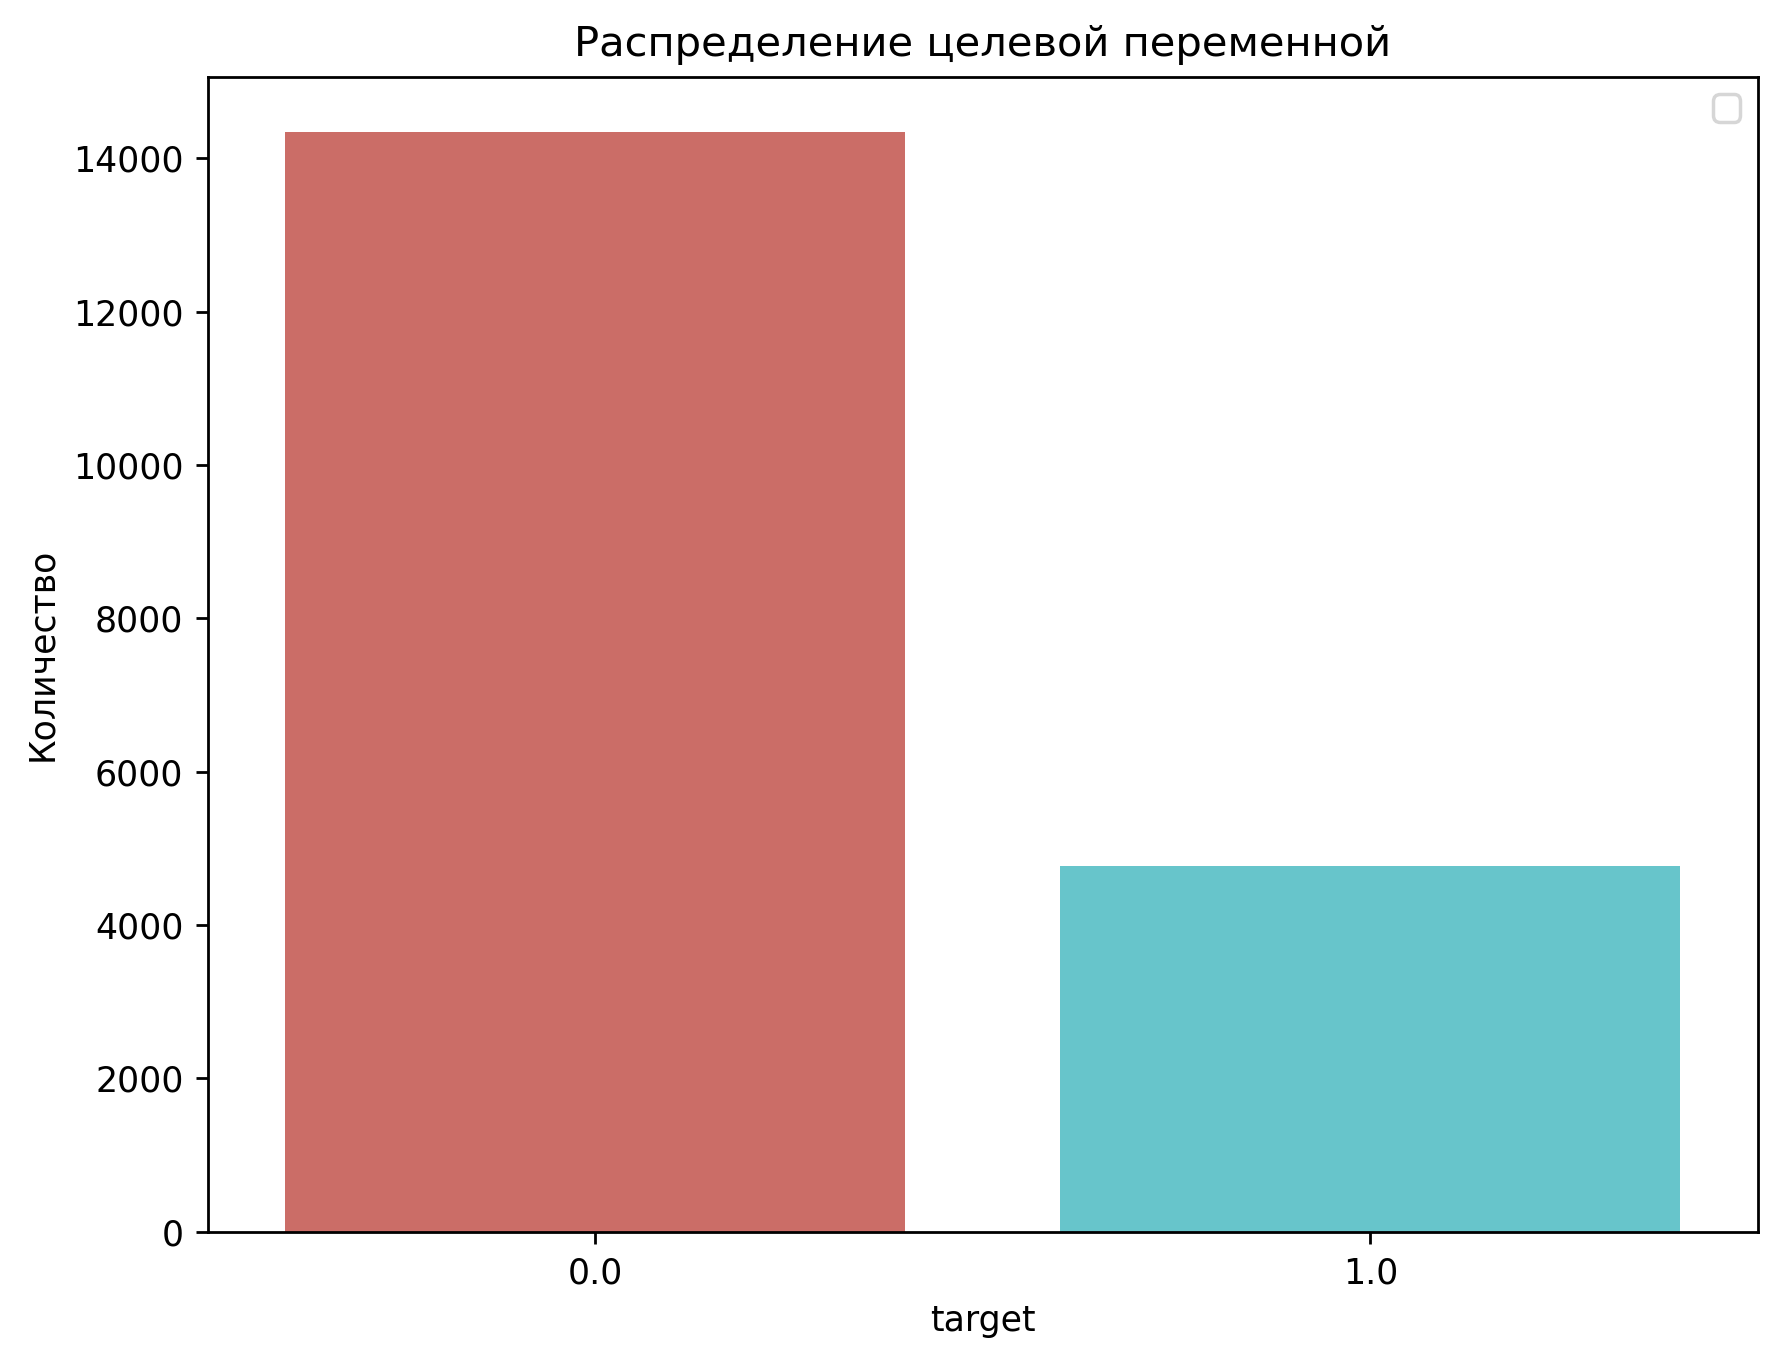

In [87]:
notna_index = df[df["target"].notna()].index

print(f"Процент положительного класса: {round(df[df["target"]==1].shape[0]/len(df.loc[notna_index])*100, 3)}%")
print(f"Процент отрицательного класса: {round(df[df["target"]==0].shape[0]/len(df.loc[notna_index])*100, 3)}%")

fig = plt.figure(figsize=(8, 6), dpi=250)
plt.title("Распределение целевой переменной")
plt.ylabel("Количество")
sns.countplot(data=df.loc[notna_index], x="target", palette="hls")
plt.legend()
plt.show()

### Результат
- Наблюдается дисбаланс классов, тогда будем использовать метрики precision, recall, pr

In [37]:
#Разделим колонки на вещесвенные и категориальные
df_num_columns = df[df.columns[df.dtypes != object]]
df_cat_columns = pd.concat([df[df.columns[df.dtypes == object]], df["target"]], axis=1)
print(f"Количество колонок: {df_num_columns.shape[1] + df_cat_columns.shape[1] - 1}")

Количество колонок: 13


In [44]:
#Сделаем вспомогательный словарик для перевода колонок на русский язык
feature_descriptions = {
    'enrollee_id': 'Уникальный идентификатор кандидата',
    'city': 'Код города',
    'city_development_index': 'Индекс развития города (масштабный)',
    'gender': 'Пол кандидата',
    'relevent_experience': 'Релевантный опыт кандидата',
    'enrolled_university': 'Тип университетского курса, если таковой имеется',
    'education_level': 'Уровень образования кандидата',
    'major_discipline': 'Образование Профильная дисциплина кандидата',
    'experience': 'Общий опыт кандидата в годах',  # Ключ изменен, чтобы соответствовать стандартным именам колонок
    'company_size': 'Количество сотрудников в компании текущего работодателя',
    'company_type': 'Тип текущего работодателя',
    'last_new_job': 'Разница в годах между предыдущей и текущей работой',
    'training_hours': 'Количество часов обучения завершено',
    'target': 'Целевая переменная: 0 – Не ищу смену работы, 1 – Ищу смену работы'
}

### Анализ вещественных колонок

In [45]:
#Метод, который отрисовывает ящыки с усами
def df_drow_boxplot(df, col, description):
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(description)
    sns.boxplot(data=df, y=col)
    plt.show()

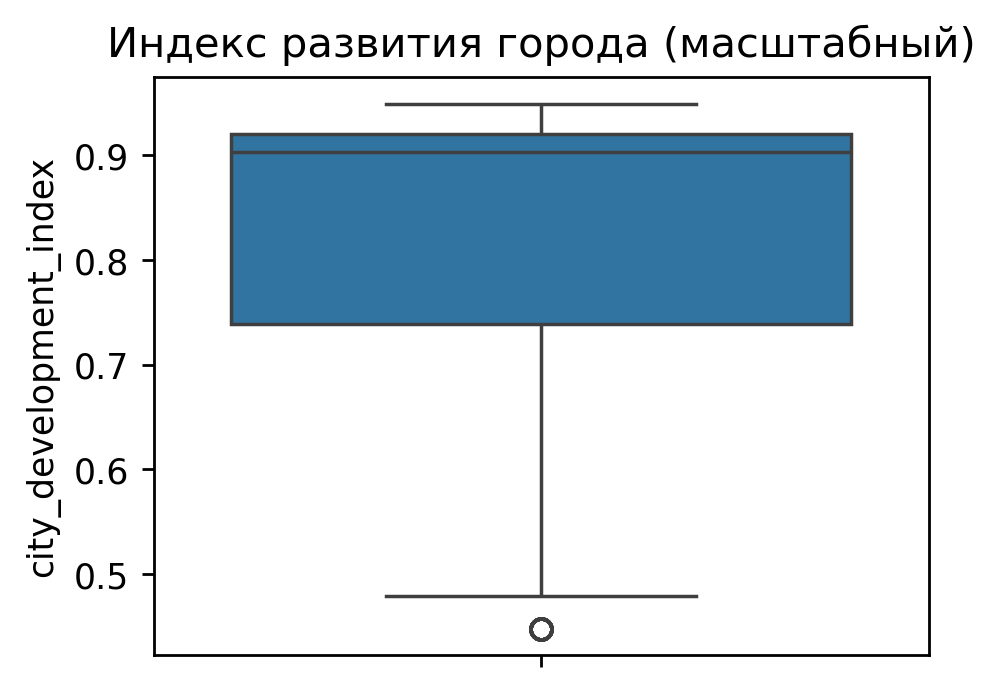

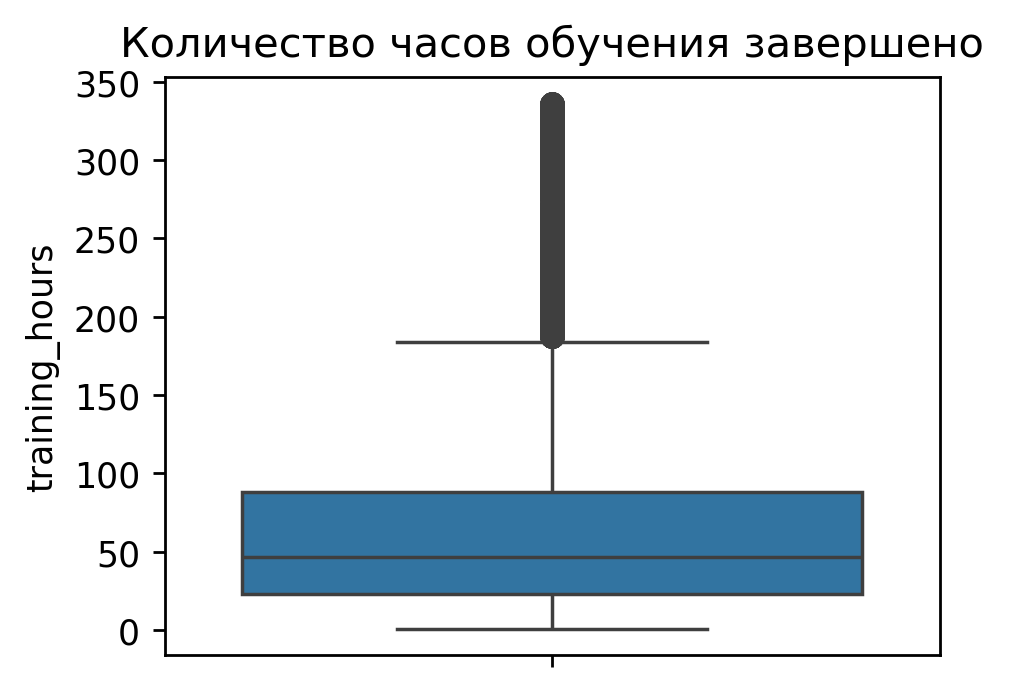

In [46]:
for col in df_num_columns.drop("target", axis=1).columns:
    df_drow_boxplot(df_num_columns, col, feature_descriptions[col])

### Результат
- Сильных выбросов не наблюдается, то есть нет выбросов, который противоречат задаче

In [47]:
#Метод, который отрисовывает distplot
def df_distplot(df, col, description):
    pozitive_class, negative_class = df[df["target"]==1], df[df["target"]==0]
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(description)
    sns.distplot(a=pozitive_class[col], color="green", bins=15)
    sns.distplot(a=negative_class[col], color="red", bins=15)
    plt.show()

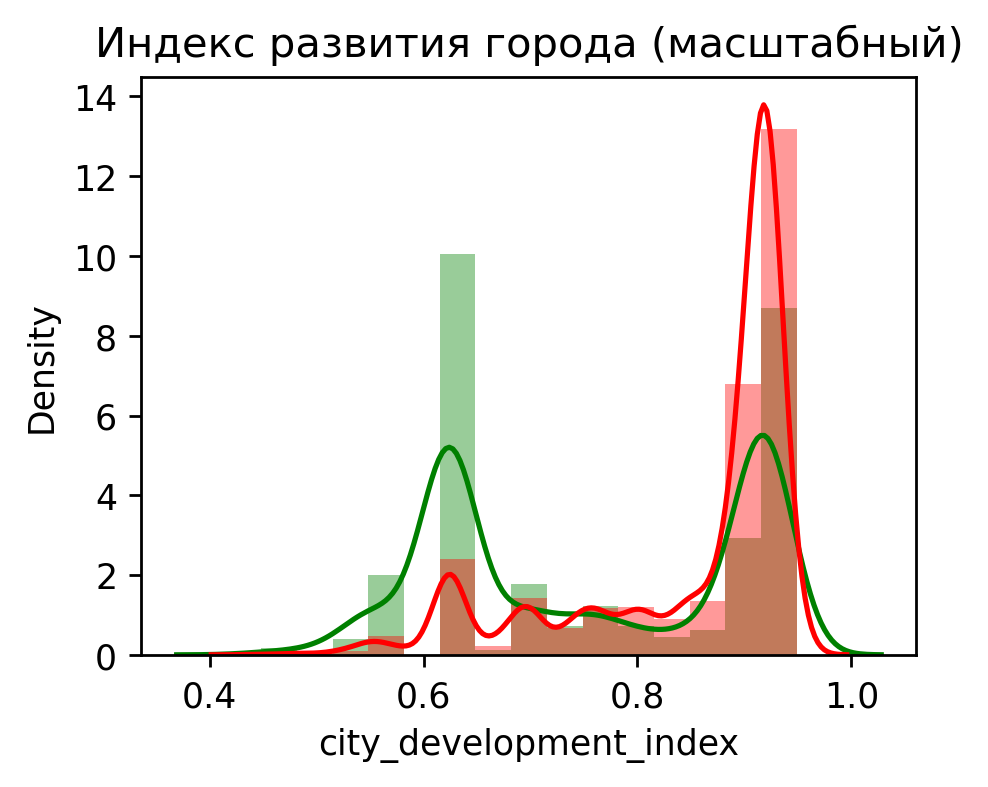

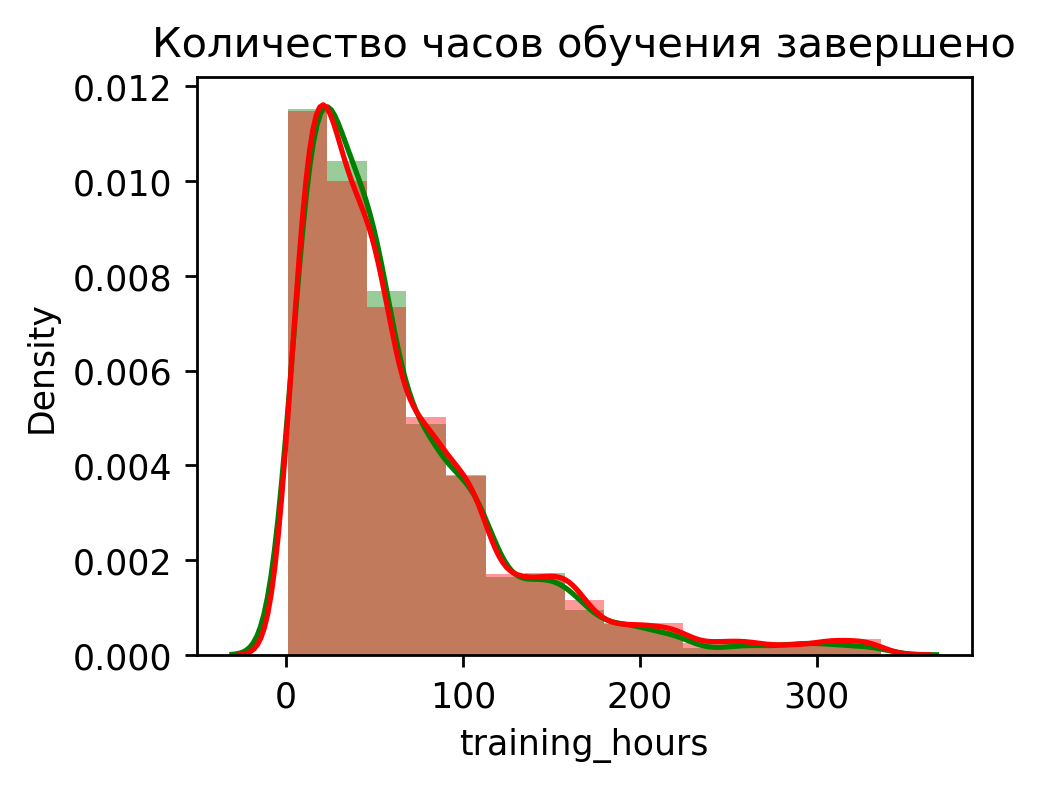

In [48]:
for col in df_num_columns.drop("target", axis=1).columns:
    df_distplot(df_num_columns, col, feature_descriptions[col])

In [49]:
#Метод, который отрисовывает языки с усами для каждого target
def df_drow_boxplot_hue_target(df, col, description):
    fig = plt.figure(figsize=(4, 3), dpi=250)
    plt.title(description)
    sns.boxplot(data=df, y=col, hue="target")
    plt.show()

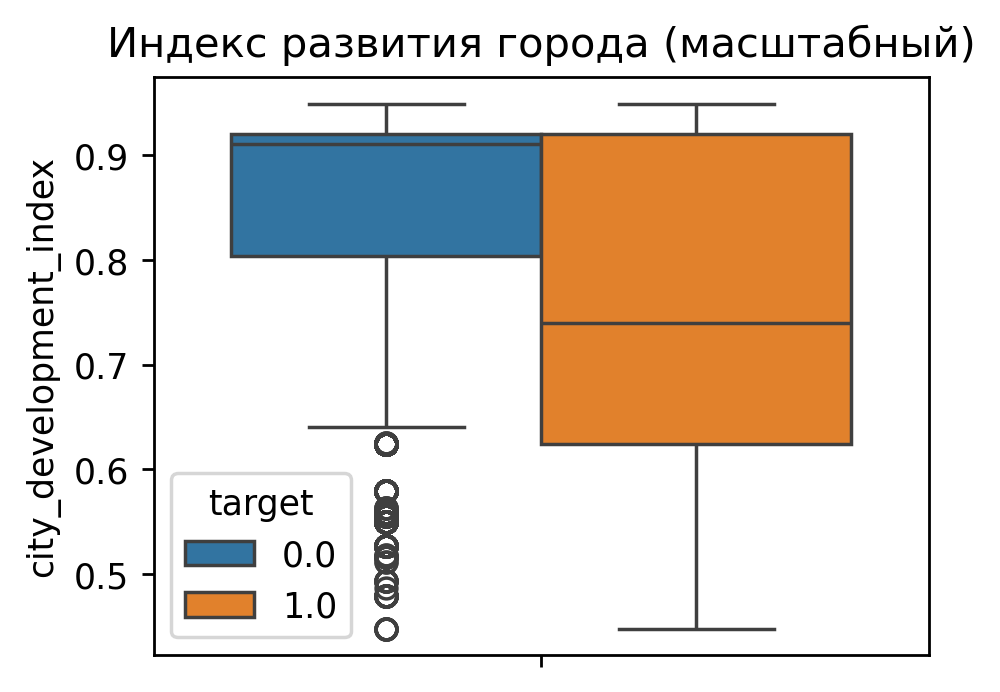

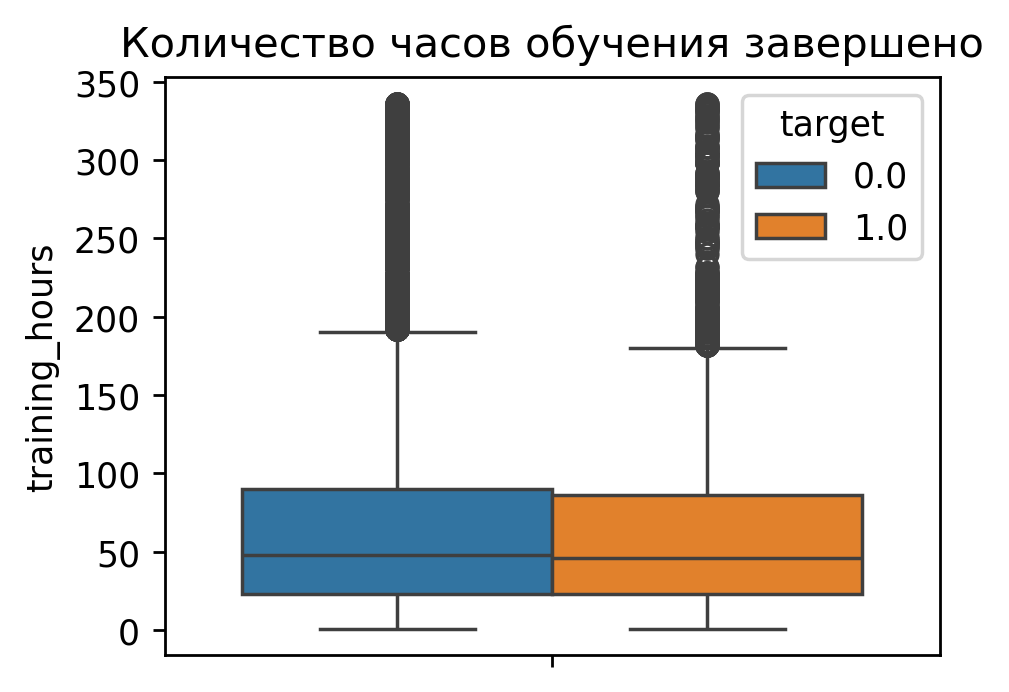

In [50]:
for col in df_num_columns.drop("target", axis=1).columns:
    df_drow_boxplot_hue_target(df_num_columns, col, feature_descriptions[col])

In [51]:
df_num_columns.groupby("target").mean()

city_development_index  training_hours
target                                        
0.0                   0.852974       66.176450
1.0                   0.755616       63.231899

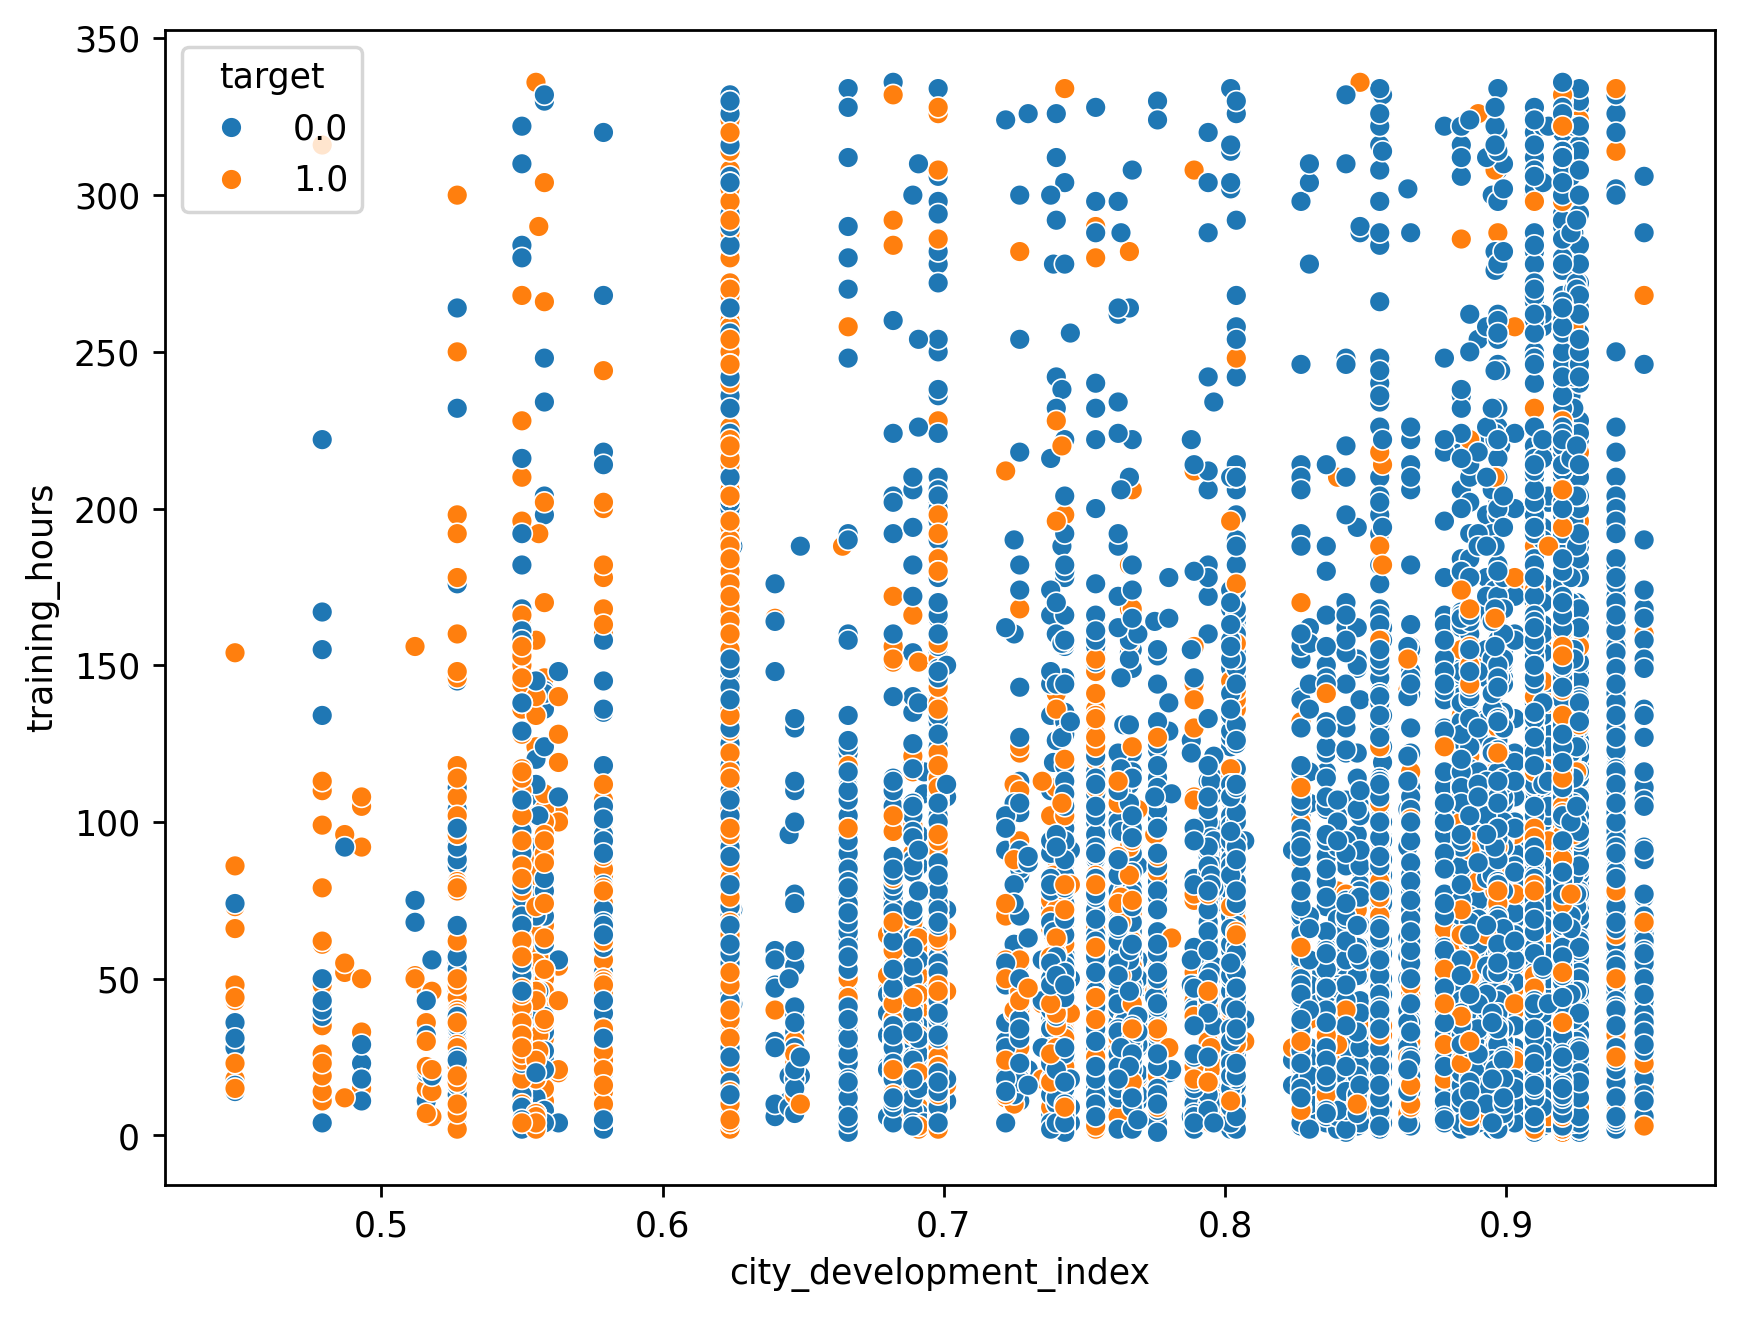

In [53]:
#Отрисуем точки по 2-м признакам
fig = plt.figure(figsize=(8, 6), dpi=250)
sns.scatterplot(data=df_num_columns, x="city_development_index", y="training_hours", hue="target")
plt.show()

### Результат
- Видно, что индекс развития города, хоть как-то меняет распределение целевого значения, в отличие от количество часов обучения, скорее всего люди, которые живут в городах с низким индексом просто хотят попасть в более крутой город, так как там уровень жизни выше
- На данный момент колонка количетсво часов обучение является хорошим кондидатом на удаление

In [54]:
#Посмотрим на пропуски
df_num_columns.drop("target", axis=1).isna().sum()

city_development_index    0
training_hours            0
dtype: int64

In [55]:
#Посмотрим попарную корреляцию между признаками
df_num_columns.drop("target", axis=1).corr()

city_development_index  training_hours
city_development_index                1.000000       -0.000211
training_hours                       -0.000211        1.000000

### Анализ категориальных признаков

In [56]:
df_cat_columns.head()

city gender      relevent_experience  ...    company_type last_new_job target
enrollee_id                                            ...                                    
8949         city_103   Male  Has relevent experience  ...             NaN            1    1.0
29725         city_40   Male   No relevent experience  ...         Pvt Ltd           >4    0.0
11561         city_21    NaN   No relevent experience  ...             NaN        never    0.0
33241        city_115    NaN   No relevent experience  ...         Pvt Ltd        never    1.0
666          city_162   Male  Has relevent experience  ...  Funded Startup            4    0.0

[5 rows x 11 columns]

In [58]:
df_cat_columns.describe(include="object")

city gender      relevent_experience enrolled_university  ... experience company_size company_type last_new_job
count      21237  16221                    21237               20820  ...      21167        14695        14481        20774
unique       123      3                        2                   3  ...         22            8            6            6
top     city_103   Male  Has relevent experience       no_enrollment  ...        >20        50-99      Pvt Ltd            1
freq        4790  14632                    15272               15290  ...       3635         3418        10928         8911

[4 rows x 10 columns]

In [62]:
#Отрисуем гистограмму распределений для каждой категории
def drow_countplot_cat(df, col, description):
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(description)
    sns.countplot(data=df, x=col, palette="hls")
    plt.xticks(rotation=90)
    plt.show()

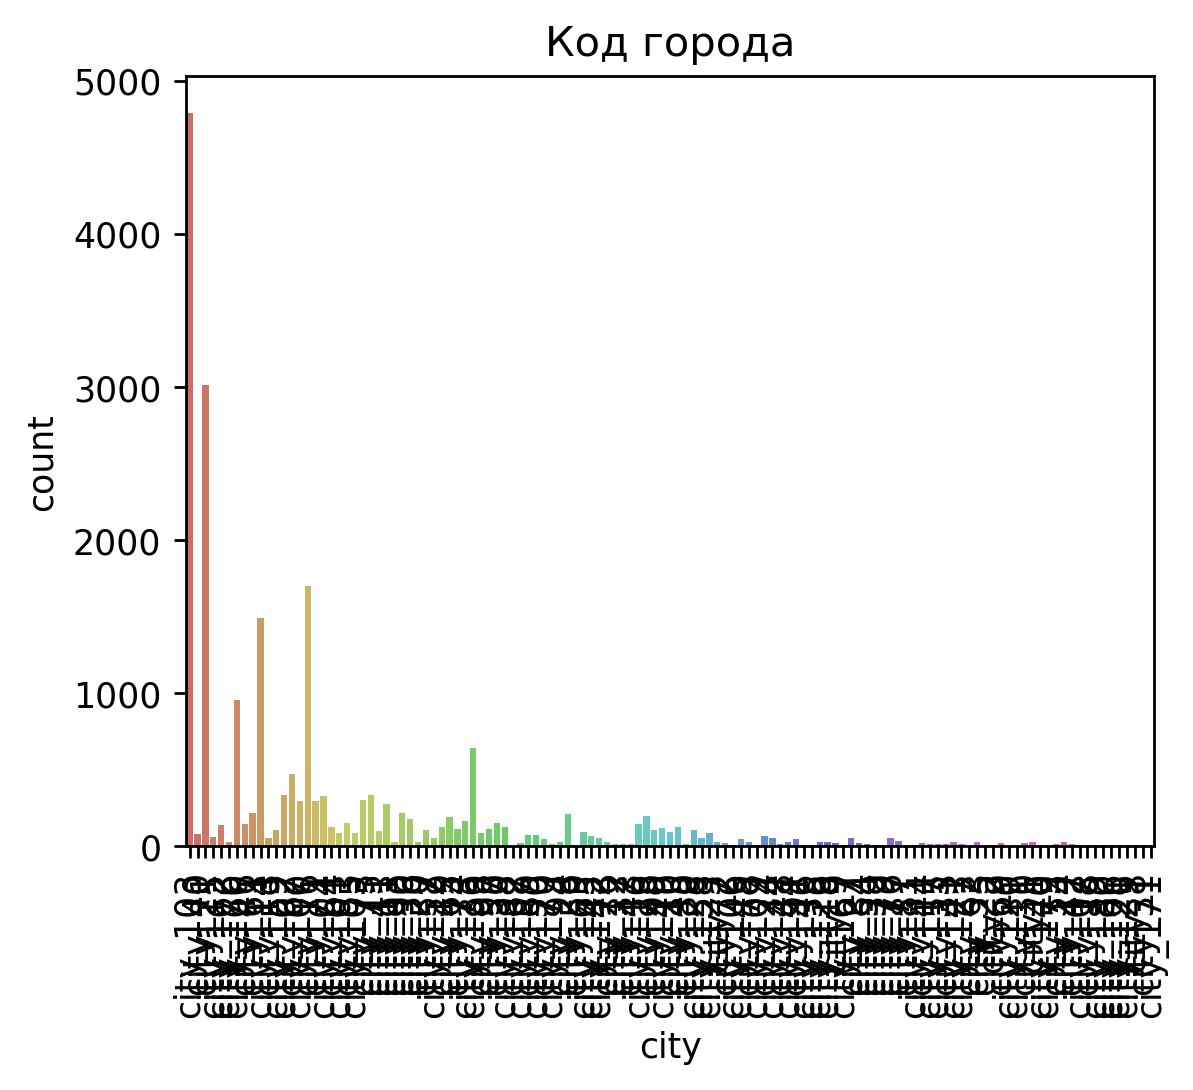

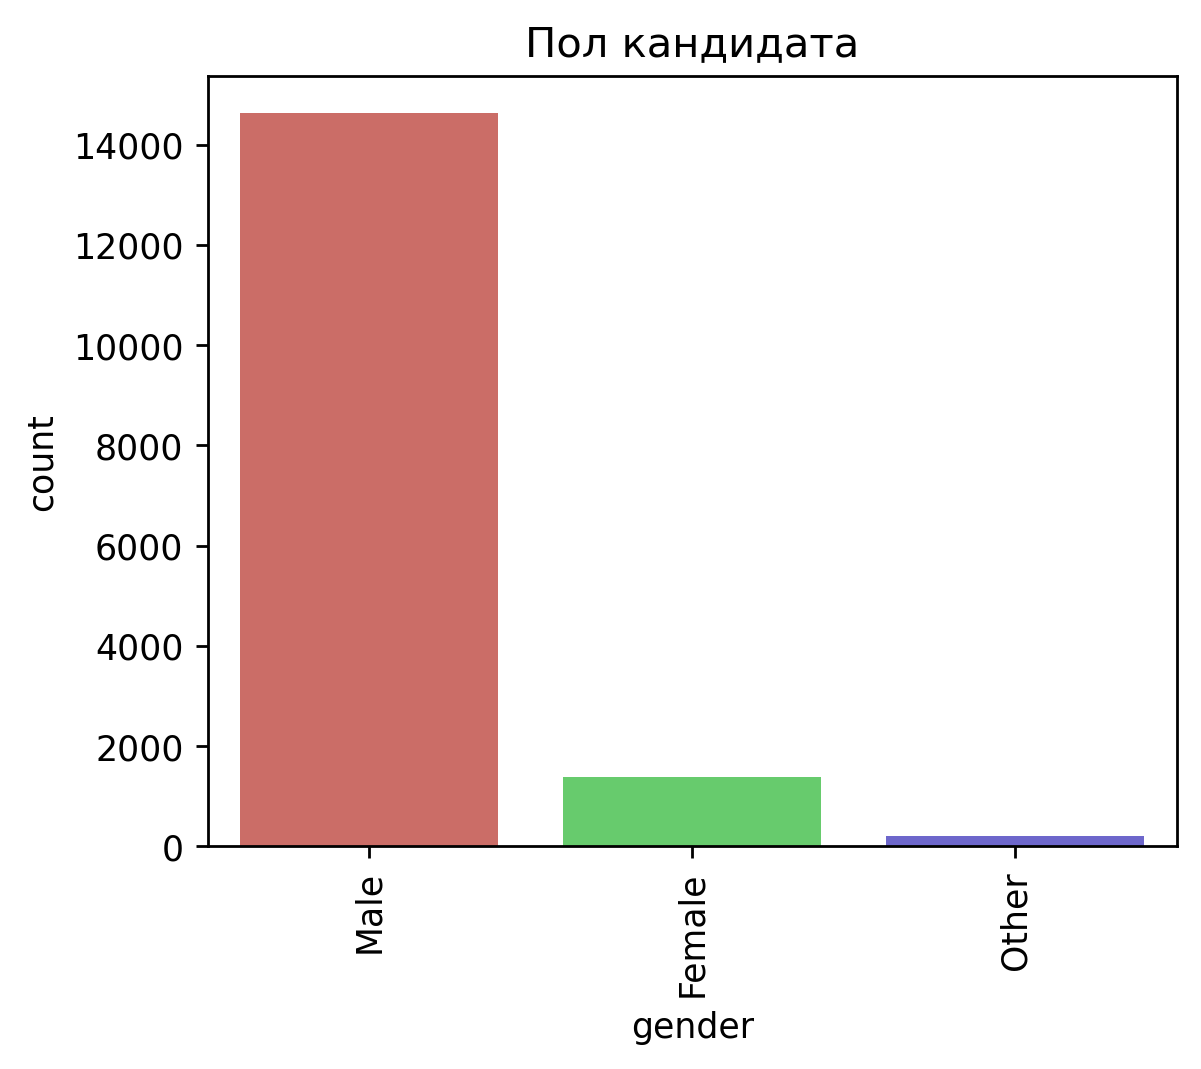

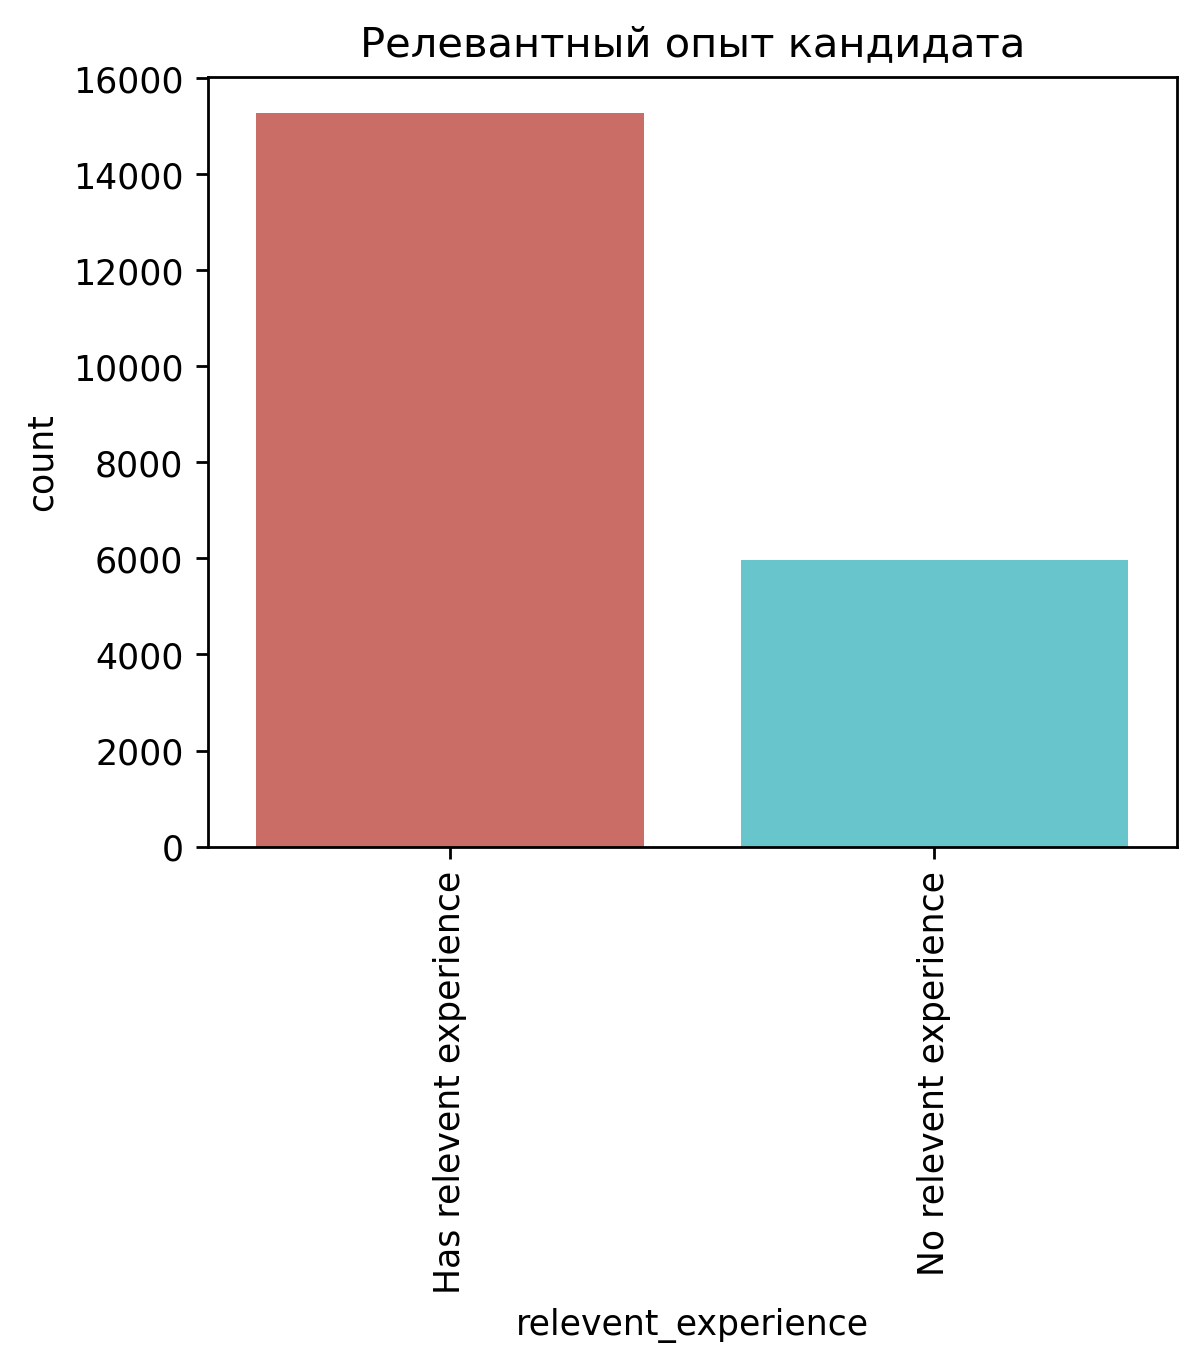

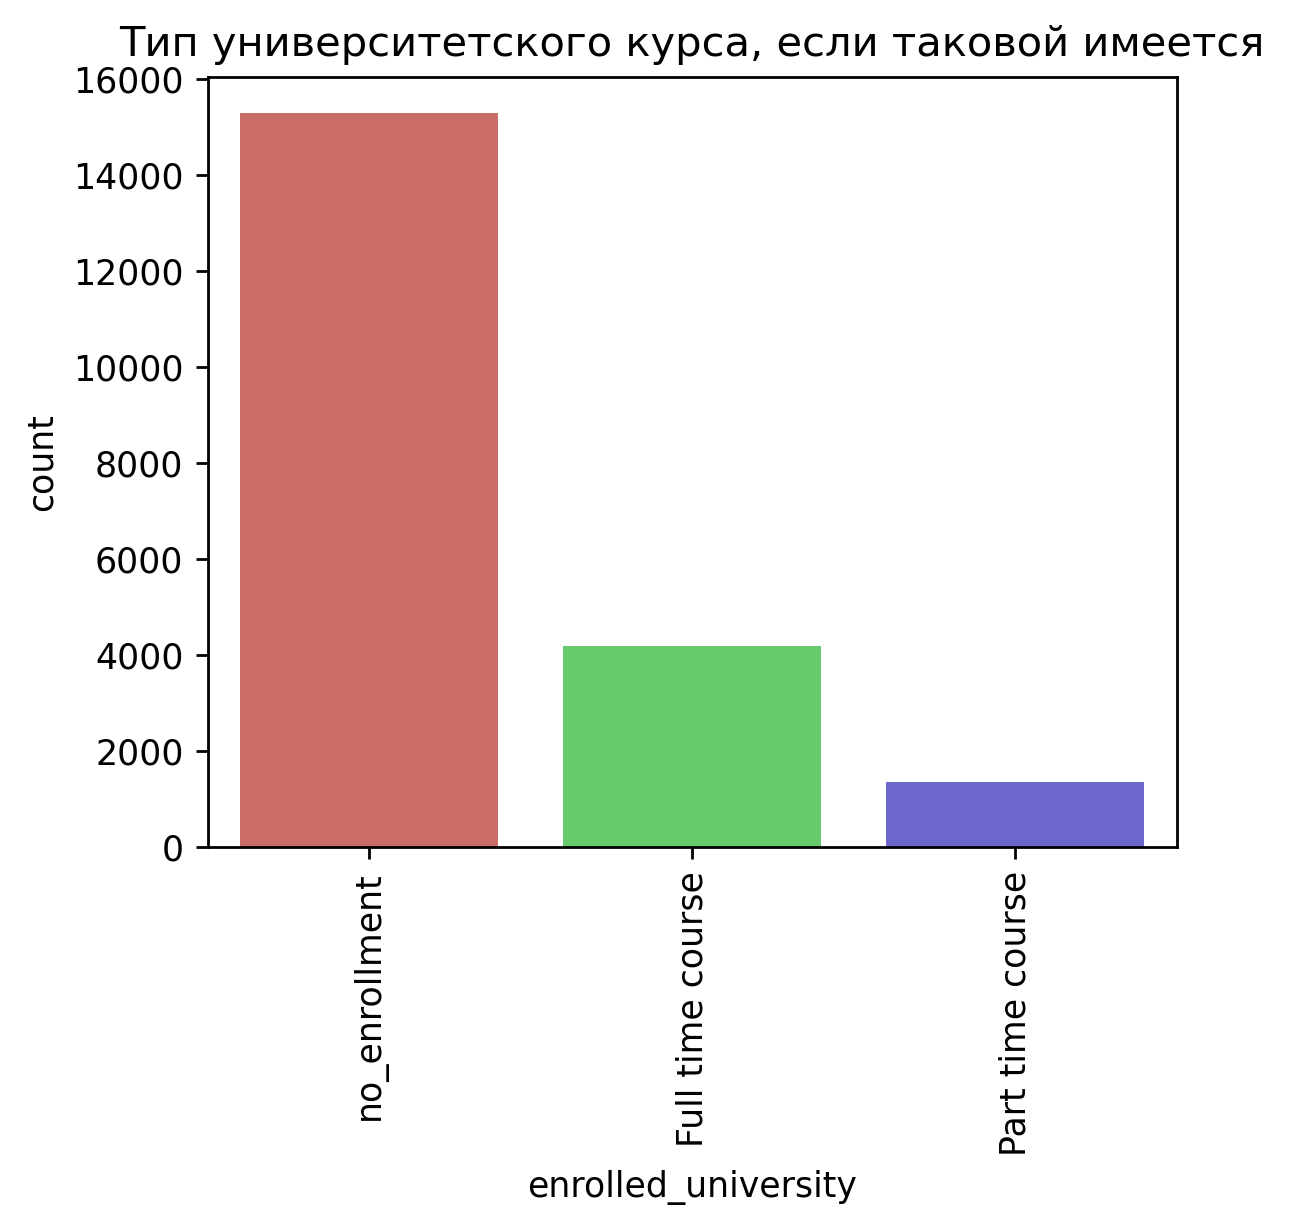

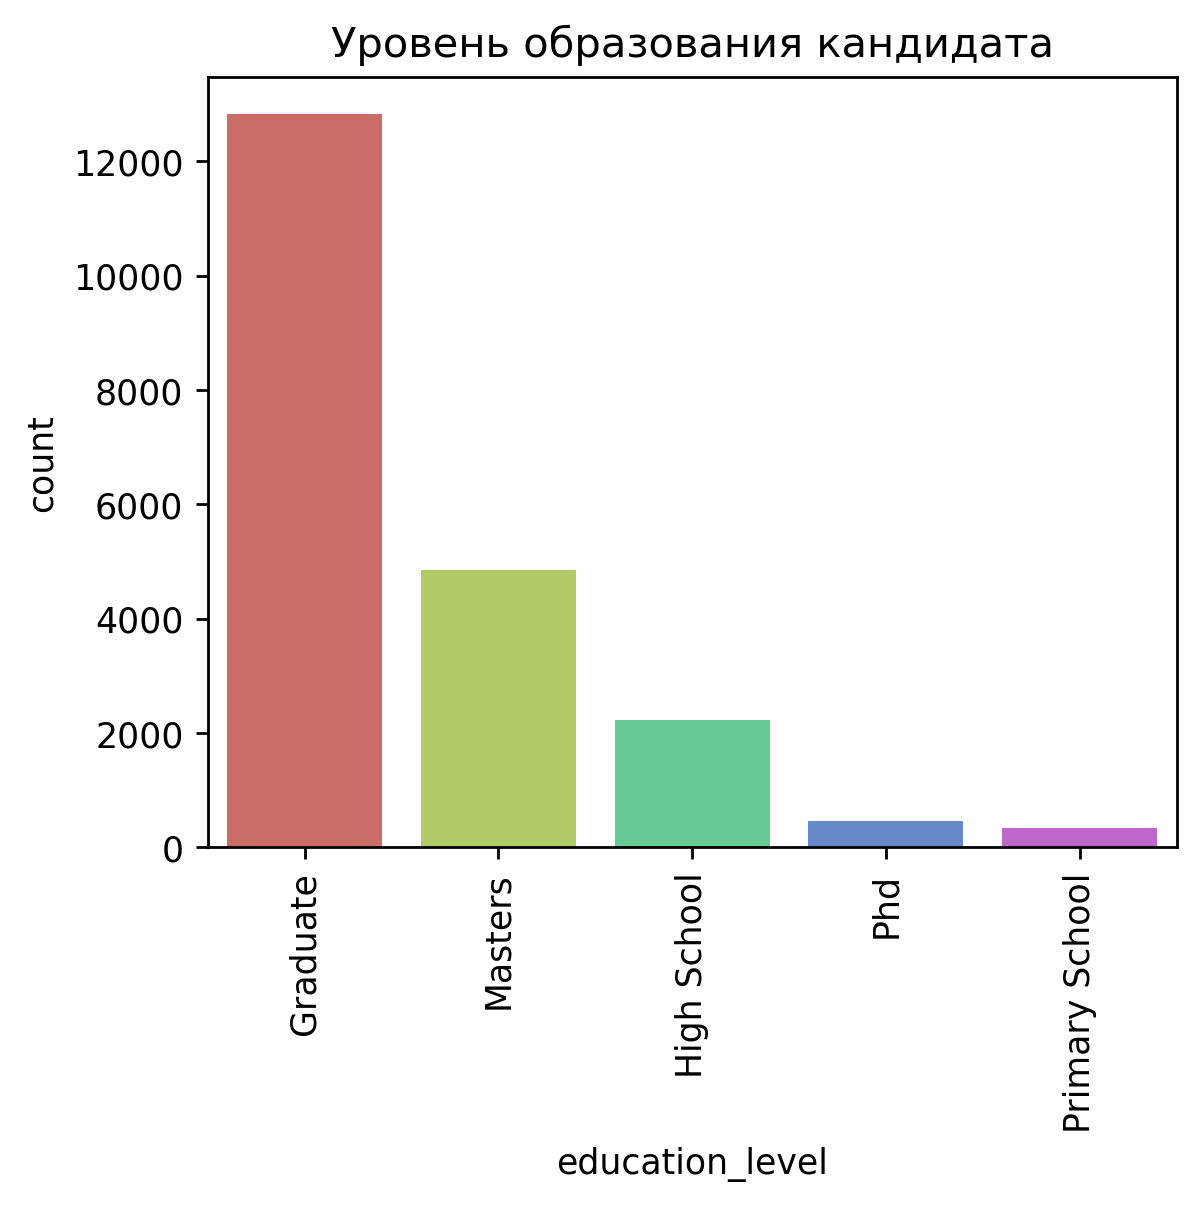

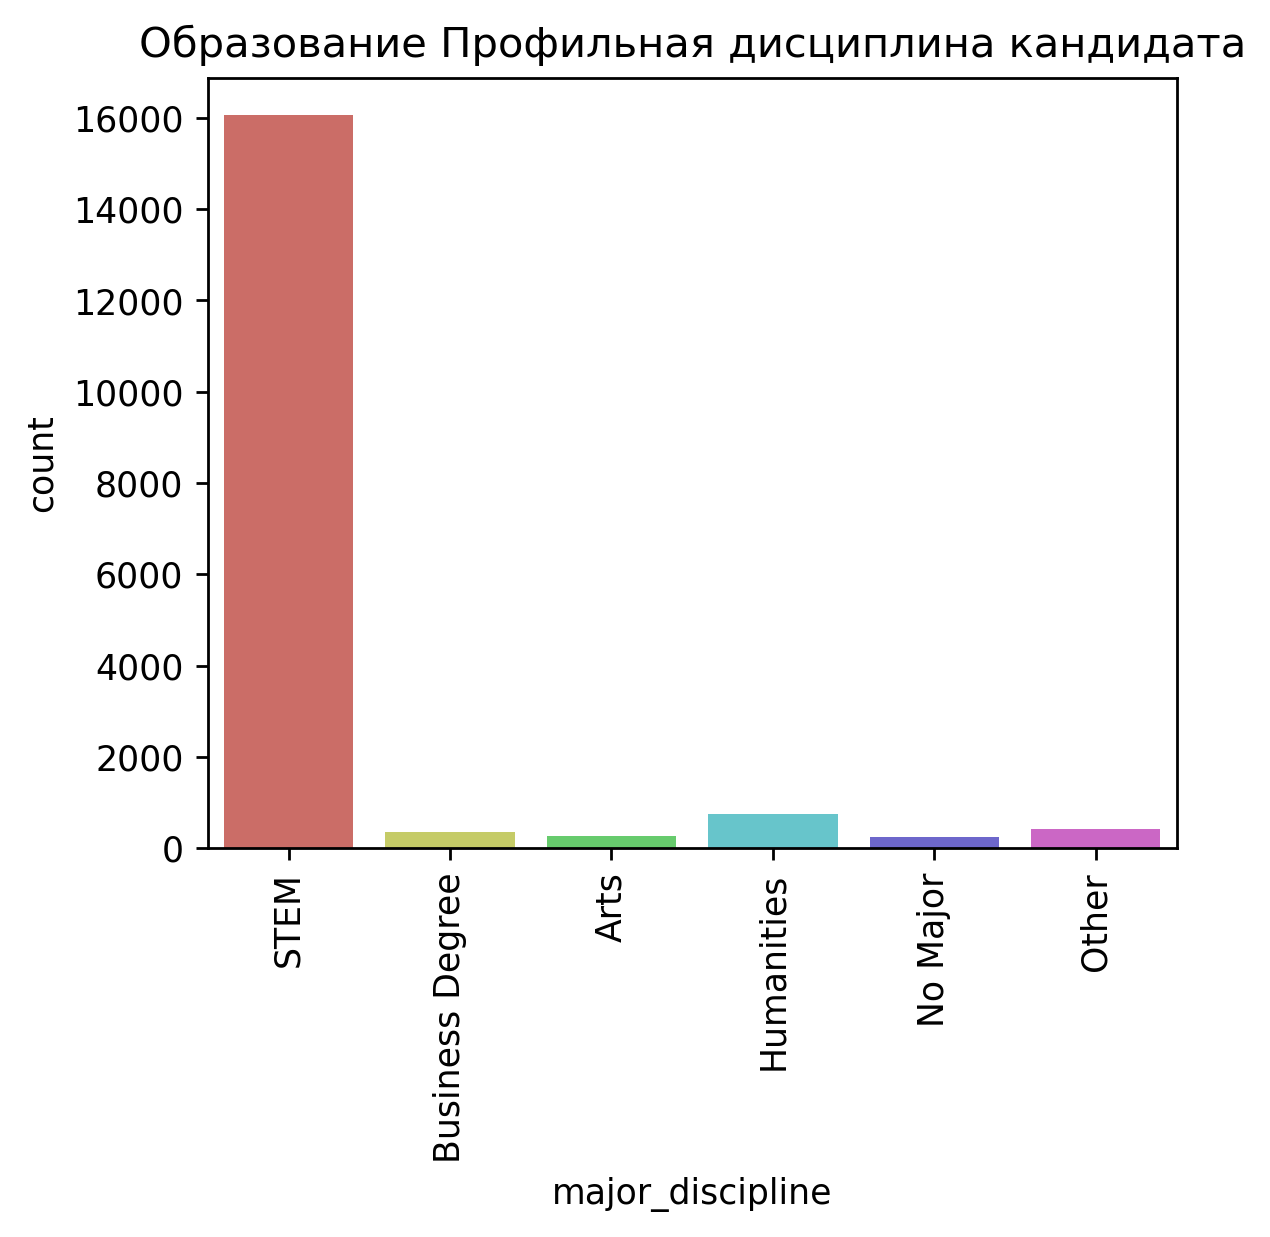

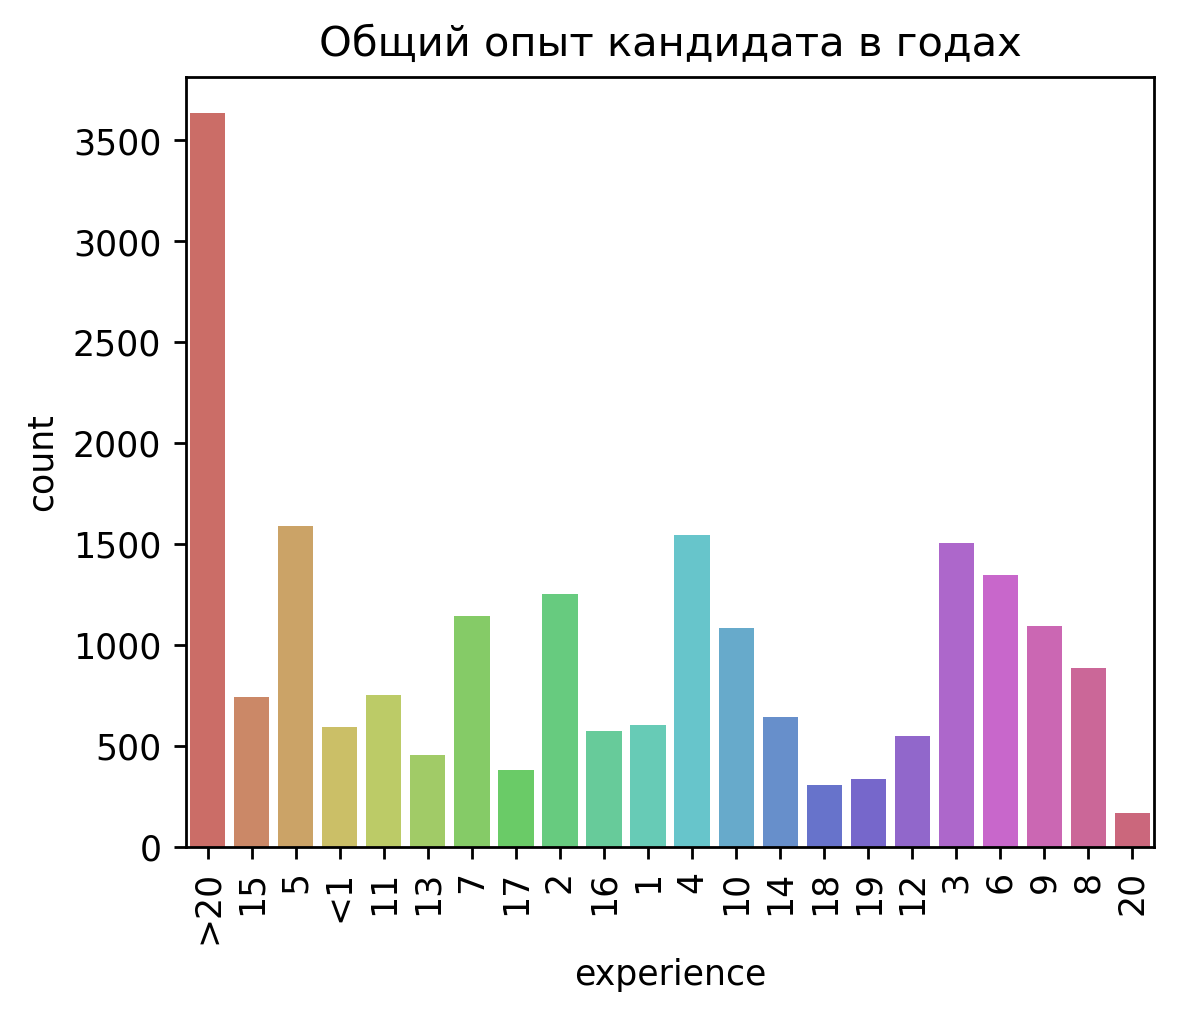

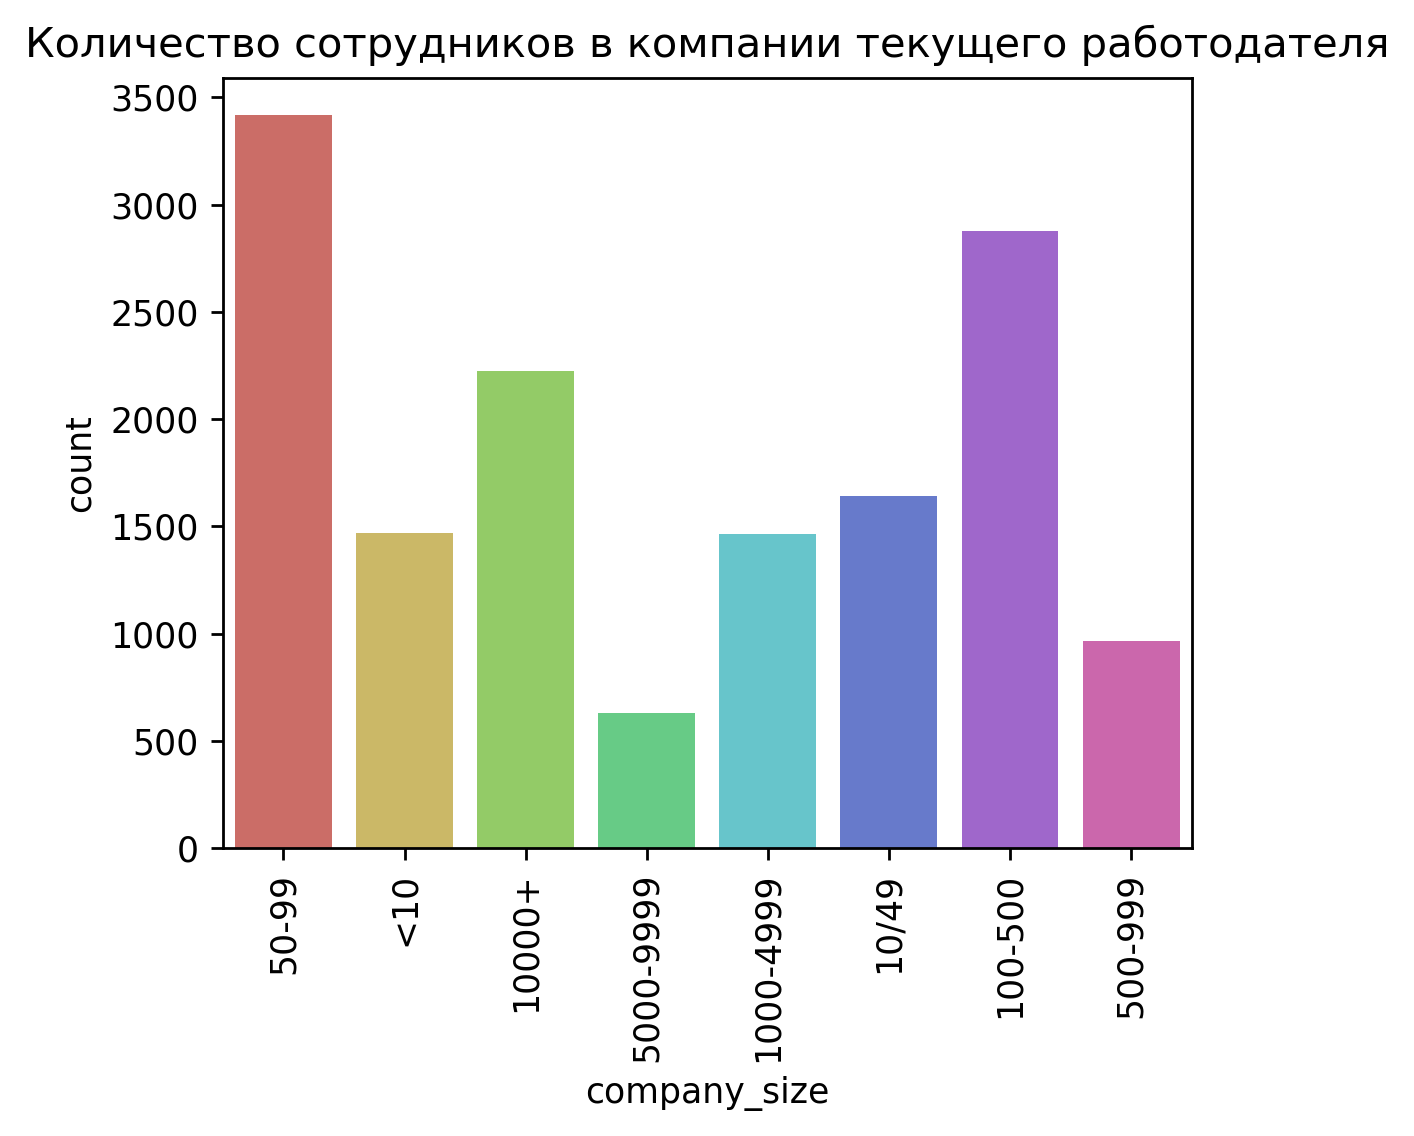

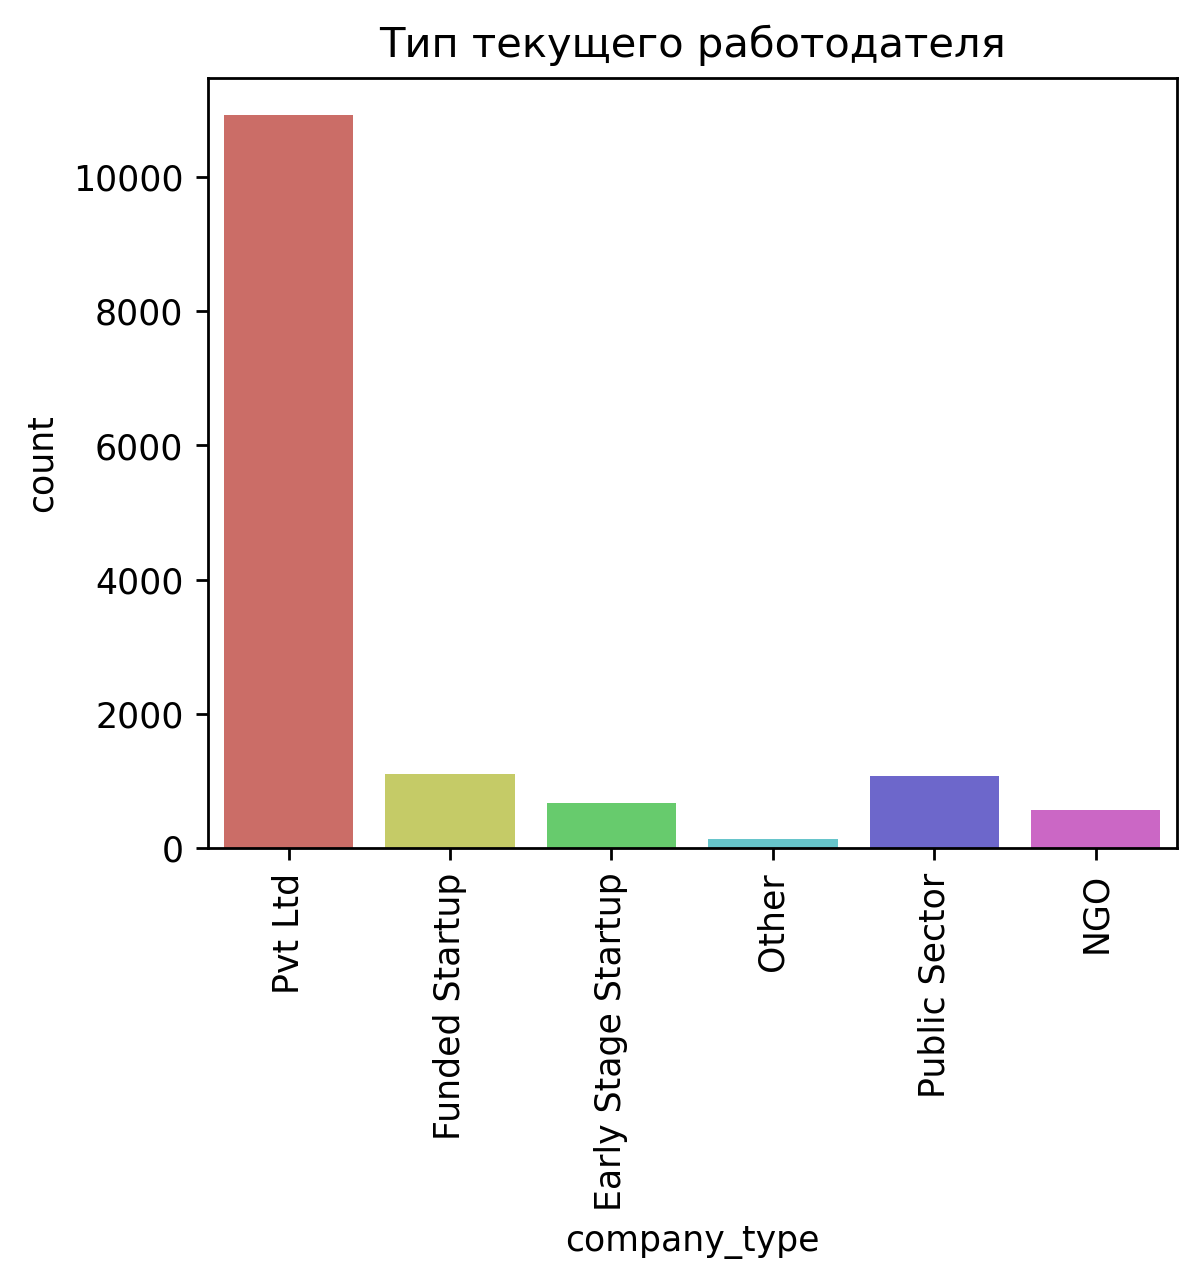

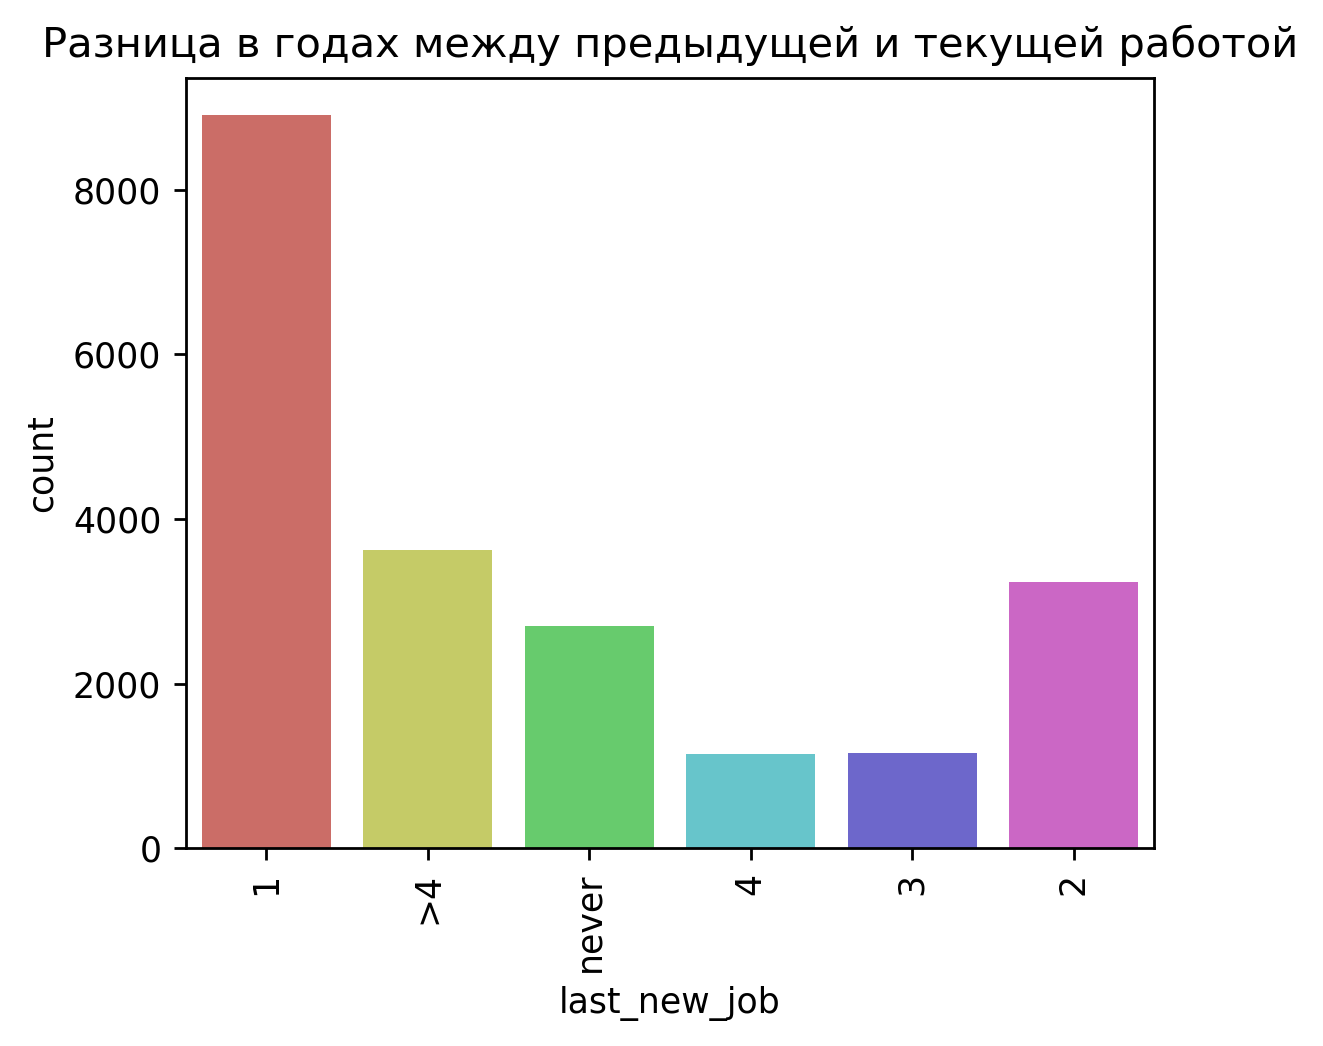

In [63]:
for col in df_cat_columns.drop("target", axis=1).columns:
    drow_countplot_cat(df_cat_columns, col, feature_descriptions[col])

### Результат
- В категориях нет квазиконстантных колонок

In [75]:
#Метод, который отрировывает гистограмму распределений для категорий, разделяя на целевые значения
def drow_countplot_cat_hue_target(df, col, description):
    print(pd.crosstab(df_cat_columns[col], df_cat_columns["target"], normalize=True))
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(description)
    sns.countplot(data=df, x=col, palette="hls", hue="target")
    plt.xticks(rotation=90)
    plt.show()

target       0.0       1.0
gender                    
Female  0.062393  0.022327
Male    0.696733  0.205465
Other   0.009657  0.003424


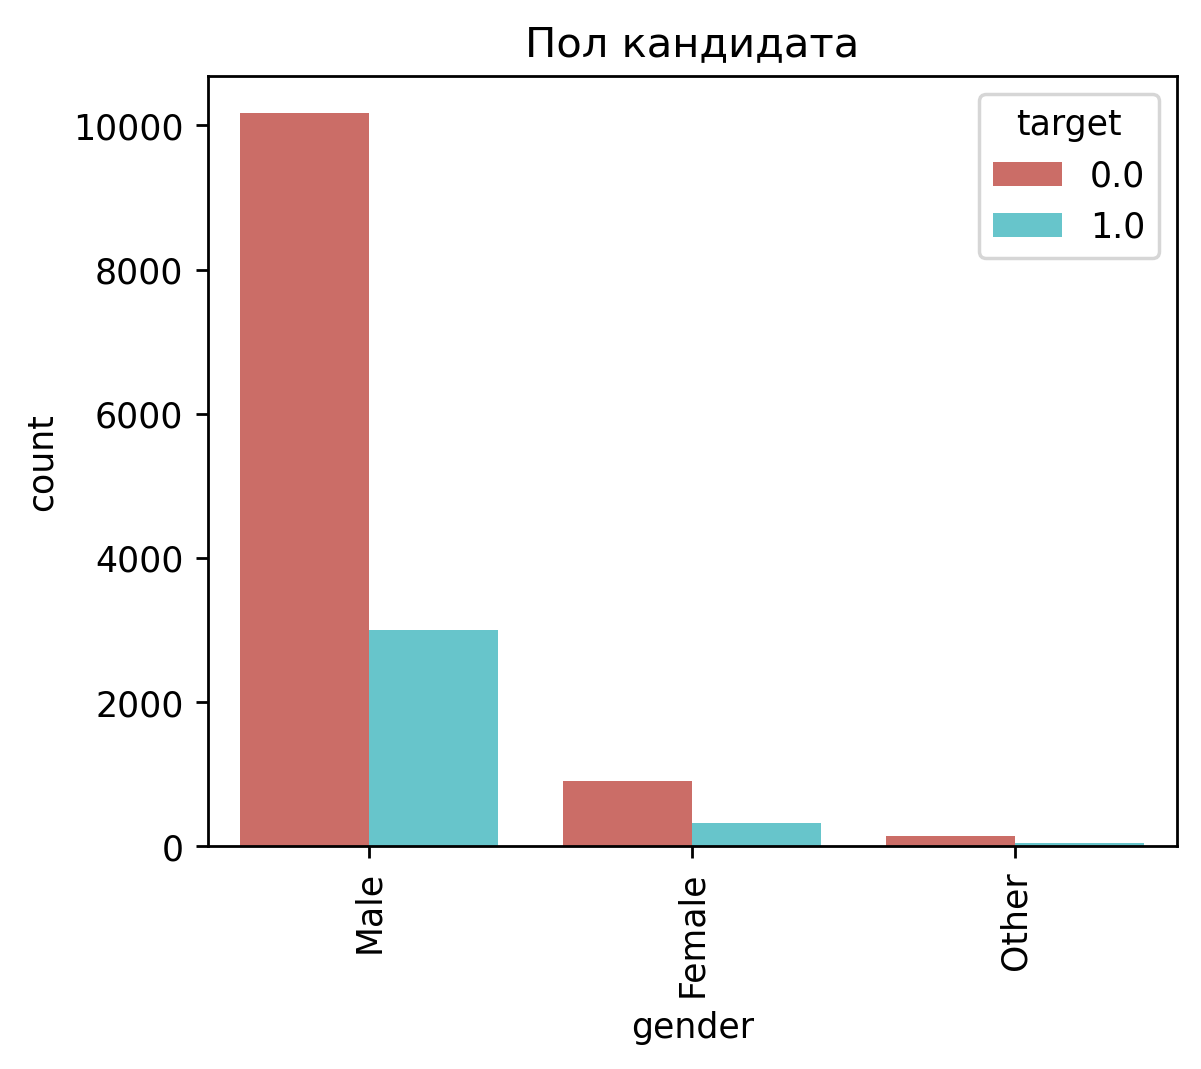

target                        0.0       1.0
relevent_experience                        
Has relevent experience  0.564969  0.154535
No relevent experience   0.185672  0.094824


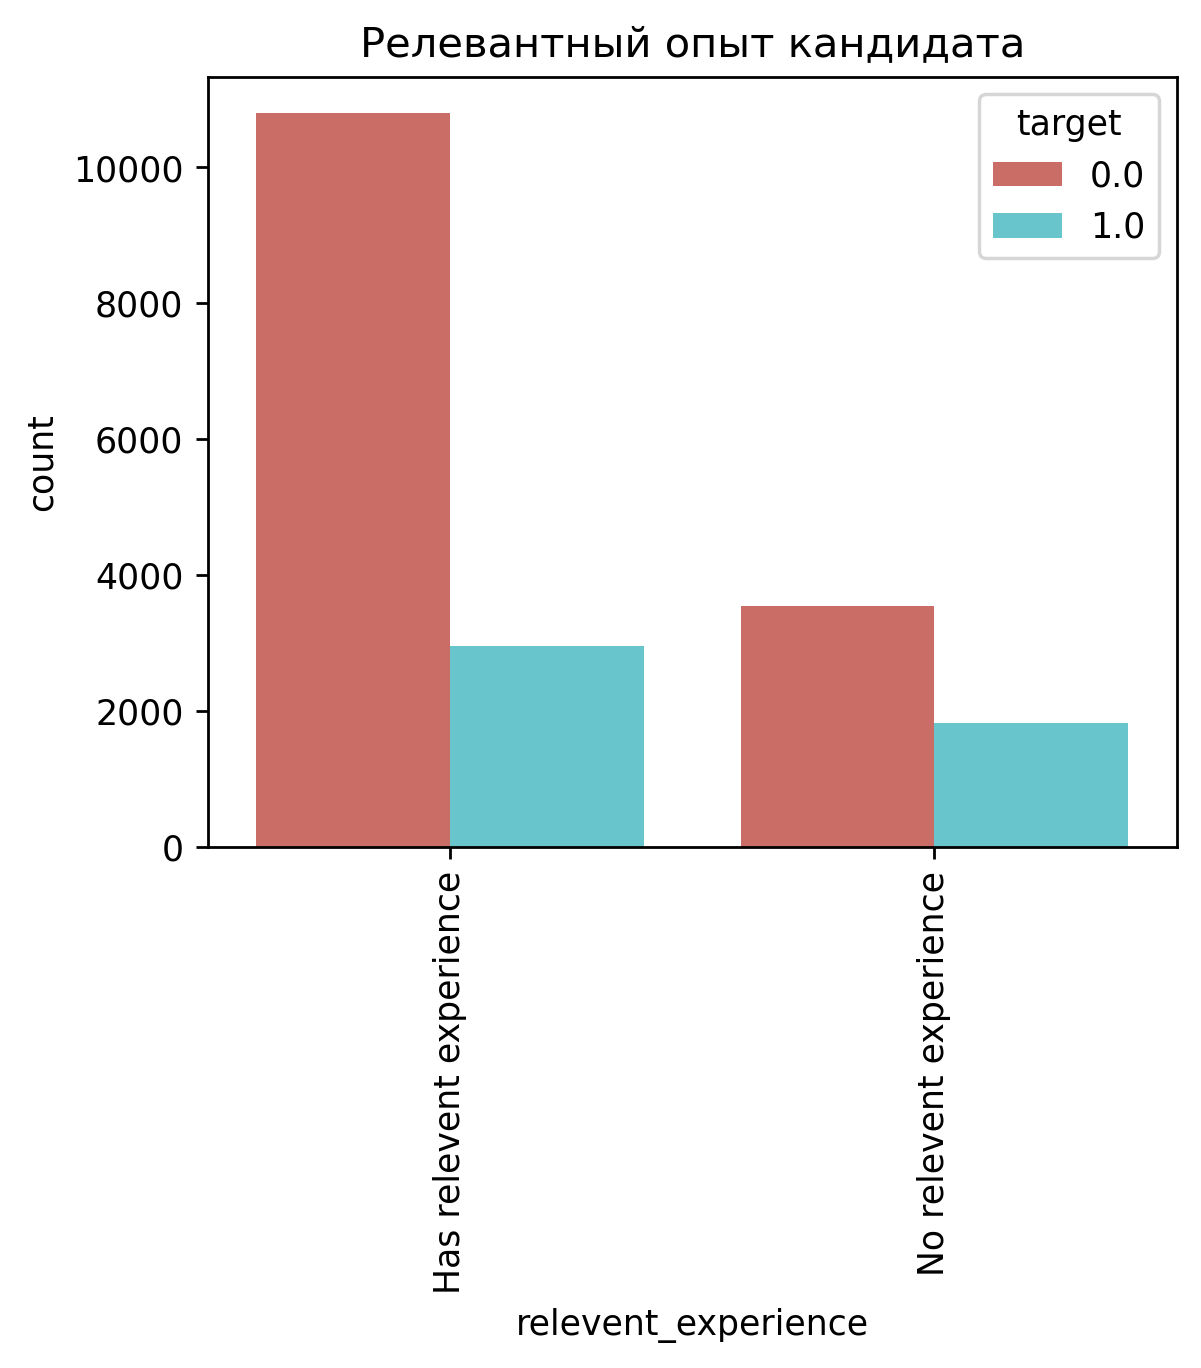

target                    0.0       1.0
enrolled_university                    
Full time course     0.124232  0.076216
Part time course     0.047856  0.016130
no_enrollment        0.579982  0.155584


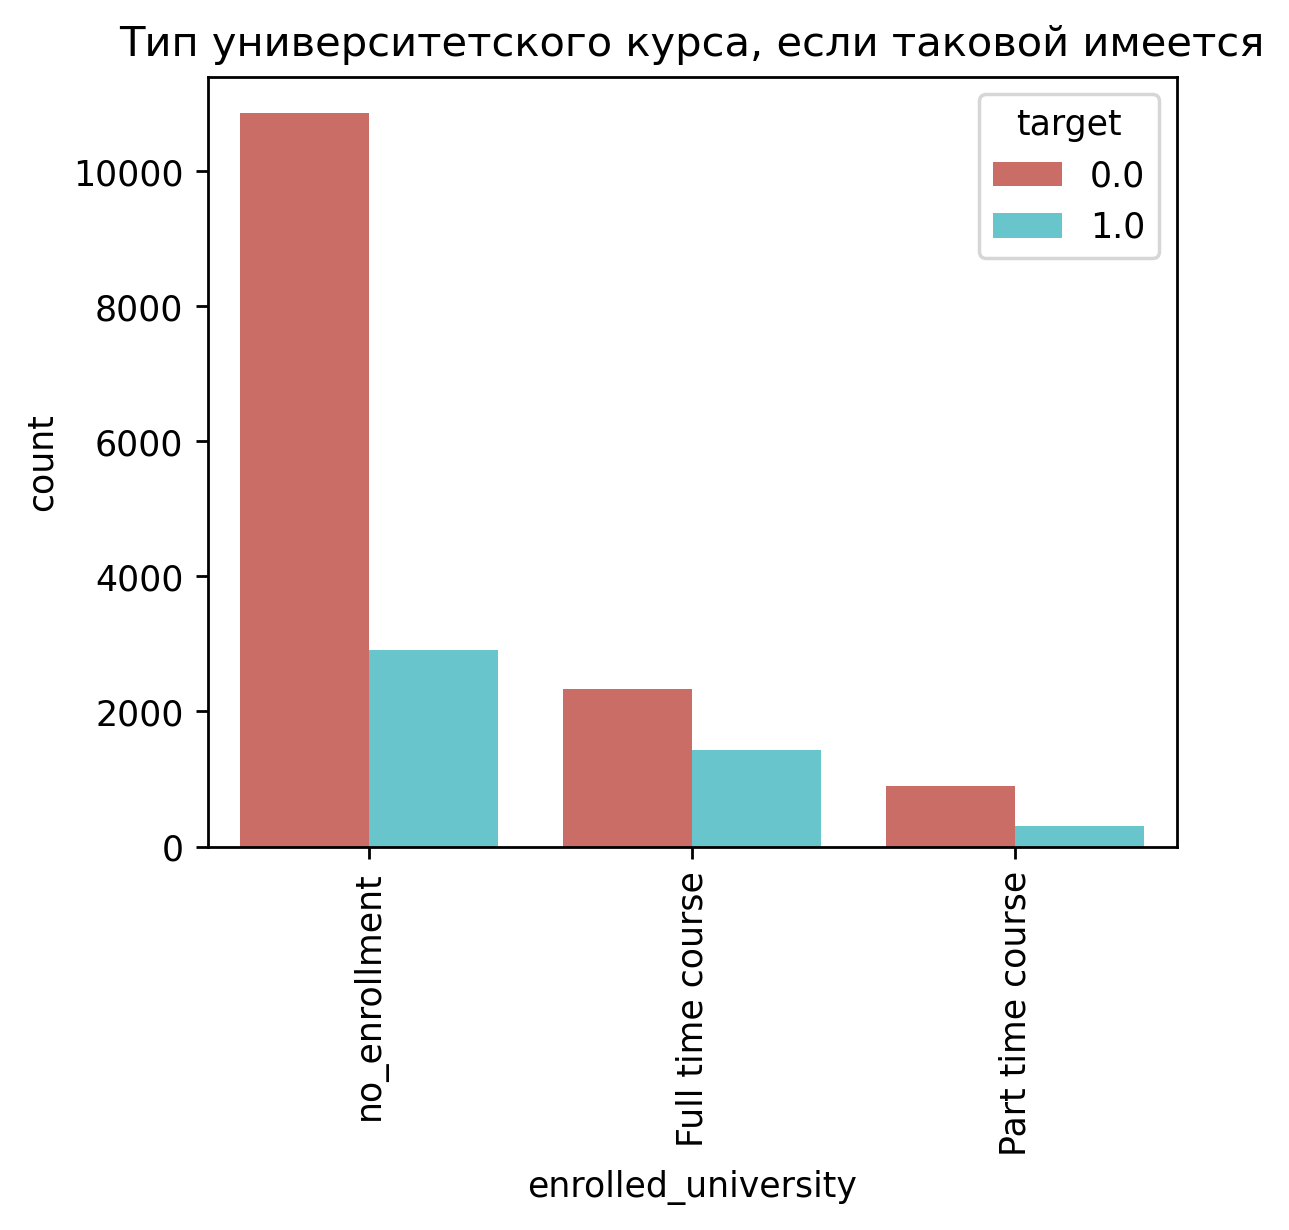

target                0.0       1.0
education_level                    
Graduate         0.446244  0.173414
High School      0.086868  0.021074
Masters          0.183549  0.050137
Phd              0.019089  0.003110
Primary School   0.014317  0.002199


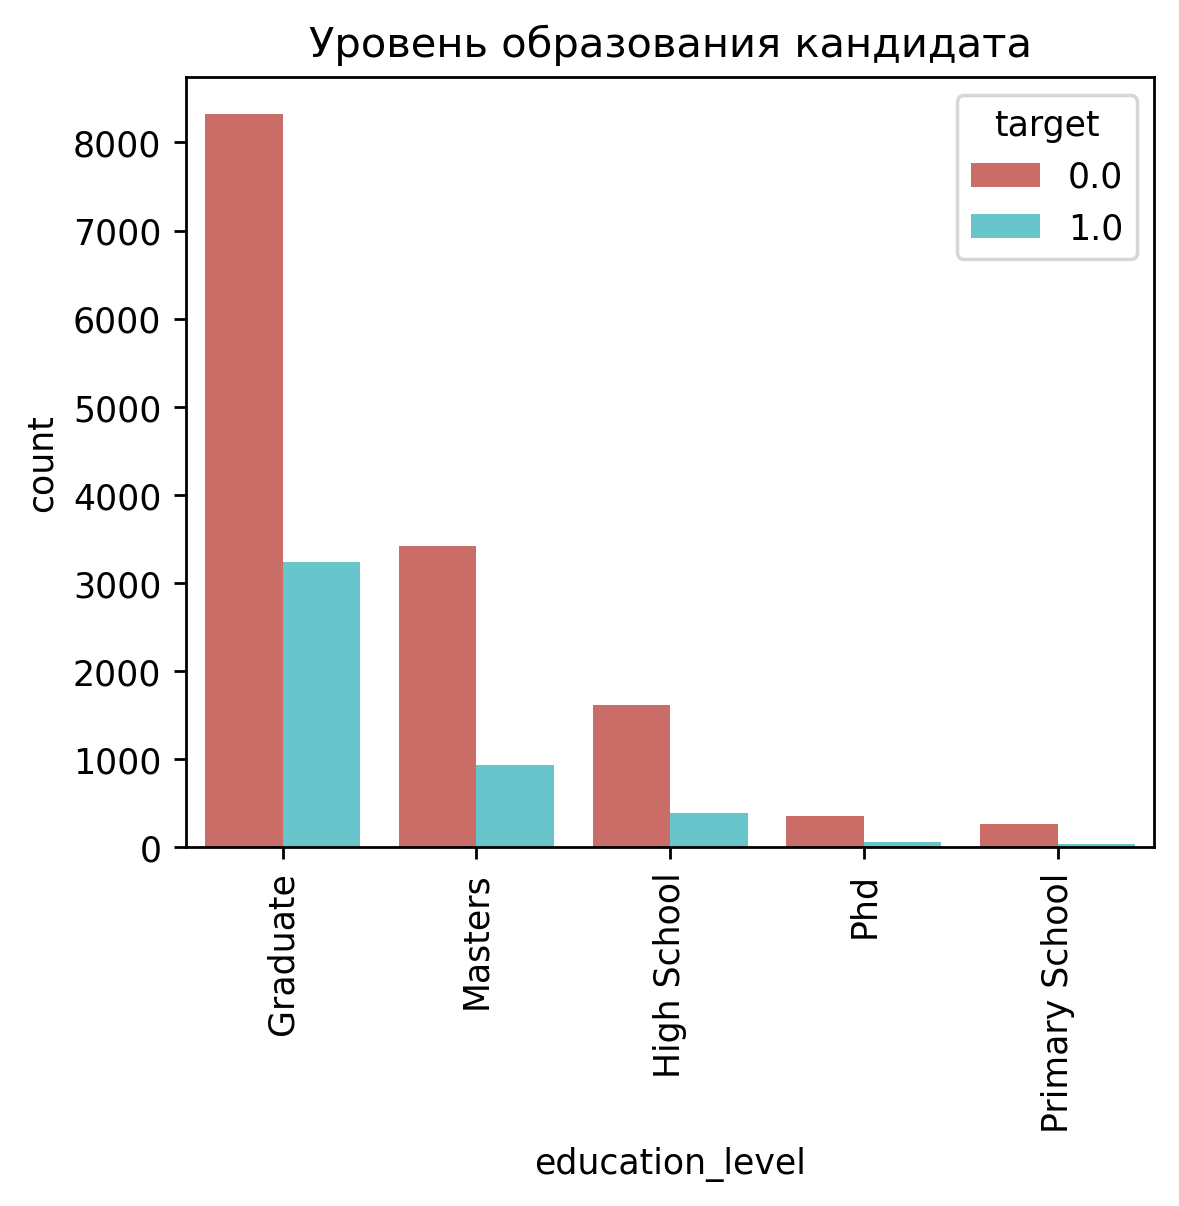

target                 0.0       1.0
major_discipline                    
Arts              0.012270  0.003252
Business Degree   0.014785  0.005276
Humanities        0.032393  0.008650
No Major          0.010307  0.003374
Other             0.017117  0.006258
STEM              0.654417  0.231902


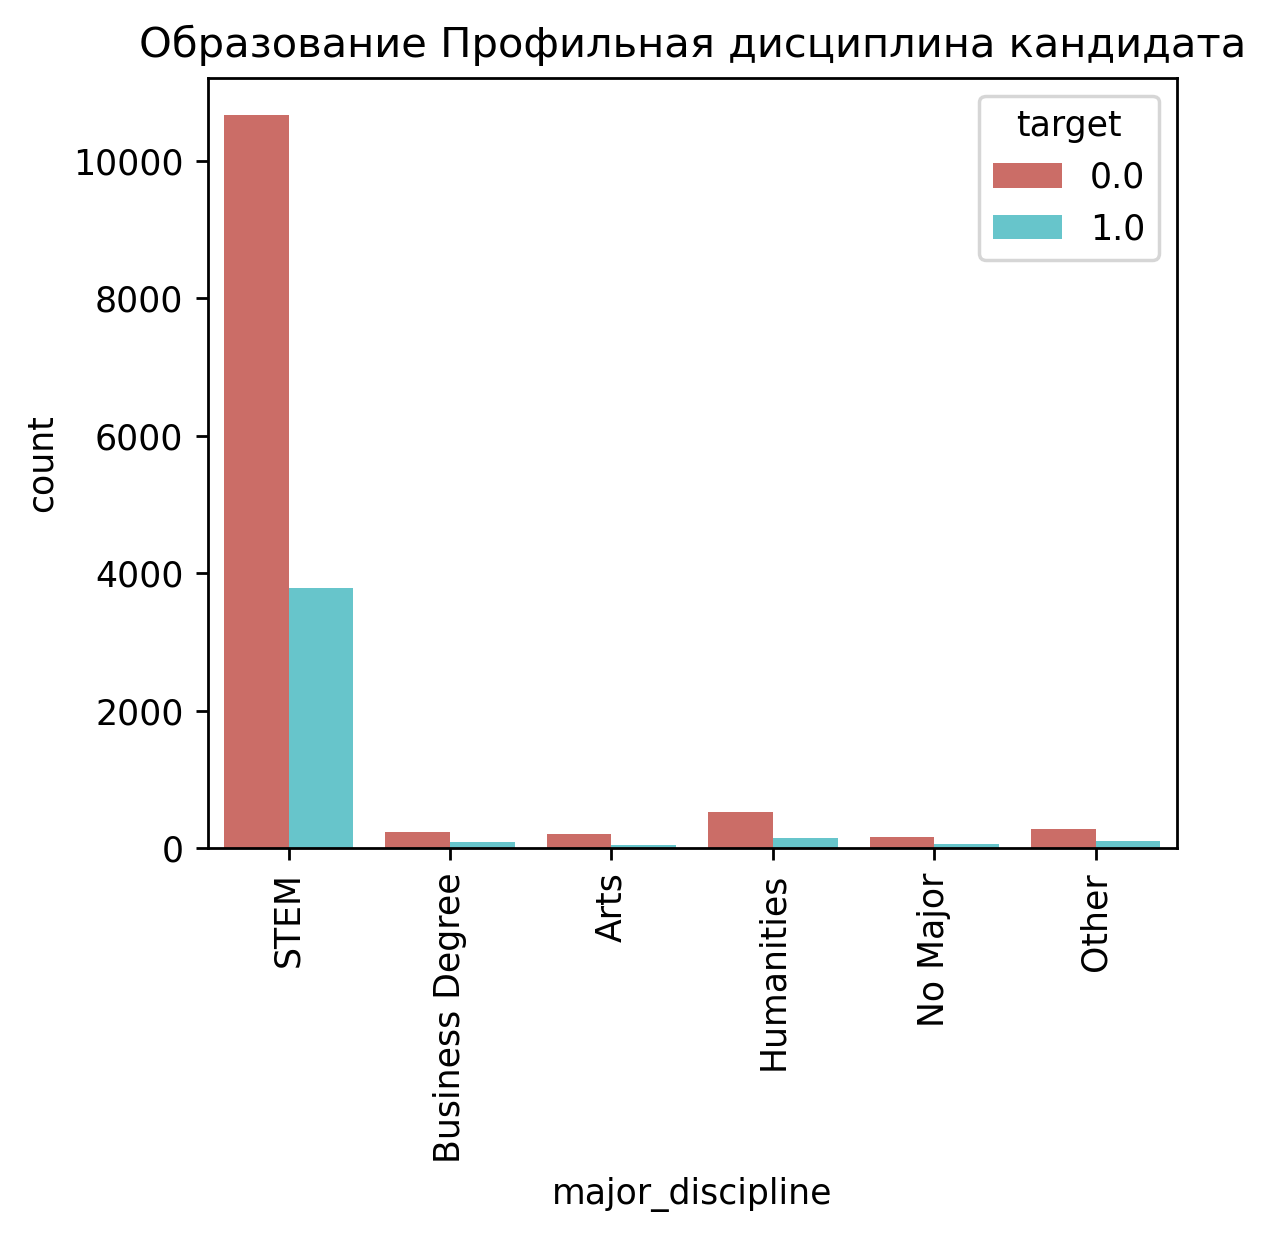

target           0.0       1.0
experience                    
1           0.016593  0.012235
10          0.040853  0.010870
11          0.026938  0.007929
12          0.021109  0.004831
13          0.016908  0.004043
14          0.025152  0.005619
15          0.029878  0.005986
16          0.022842  0.003781
17          0.014965  0.002993
18          0.012445  0.002258
19          0.013180  0.002783
2           0.039540  0.019534
20          0.006039  0.001733
3           0.045946  0.025100
4           0.049622  0.023945
5           0.053403  0.021582
6           0.045789  0.017958
7           0.038070  0.015858
8           0.031874  0.010239
9           0.040223  0.011185
<1          0.014965  0.012392
>20         0.144665  0.026150


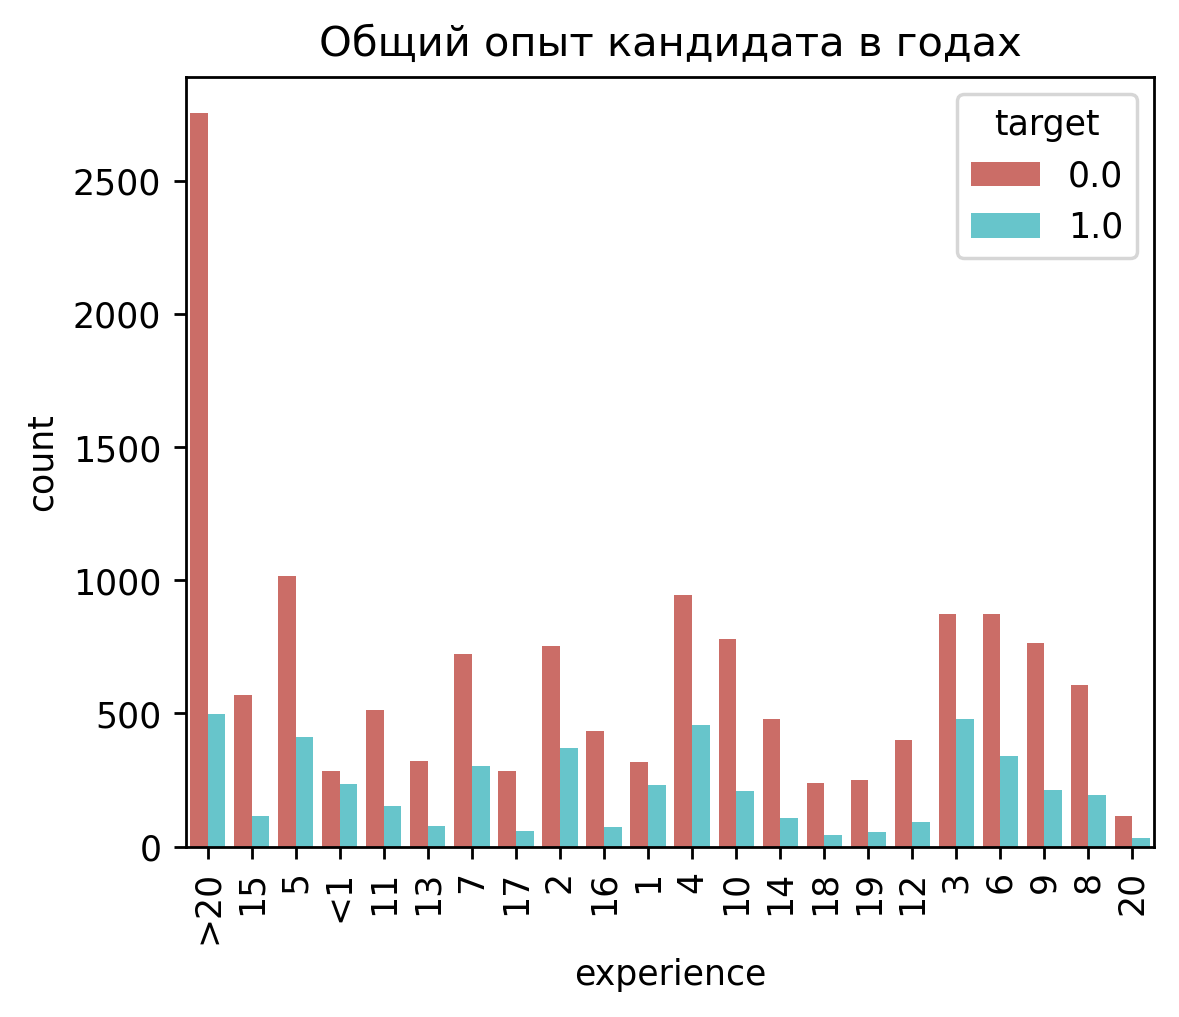

target             0.0       1.0
company_size                    
10/49         0.085374  0.026082
100-500       0.162863  0.031314
1000-4999     0.085071  0.015164
10000+        0.123209  0.029115
50-99         0.192206  0.041322
500-999       0.054970  0.011525
5000-9999     0.034878  0.007734
<10           0.082190  0.016984


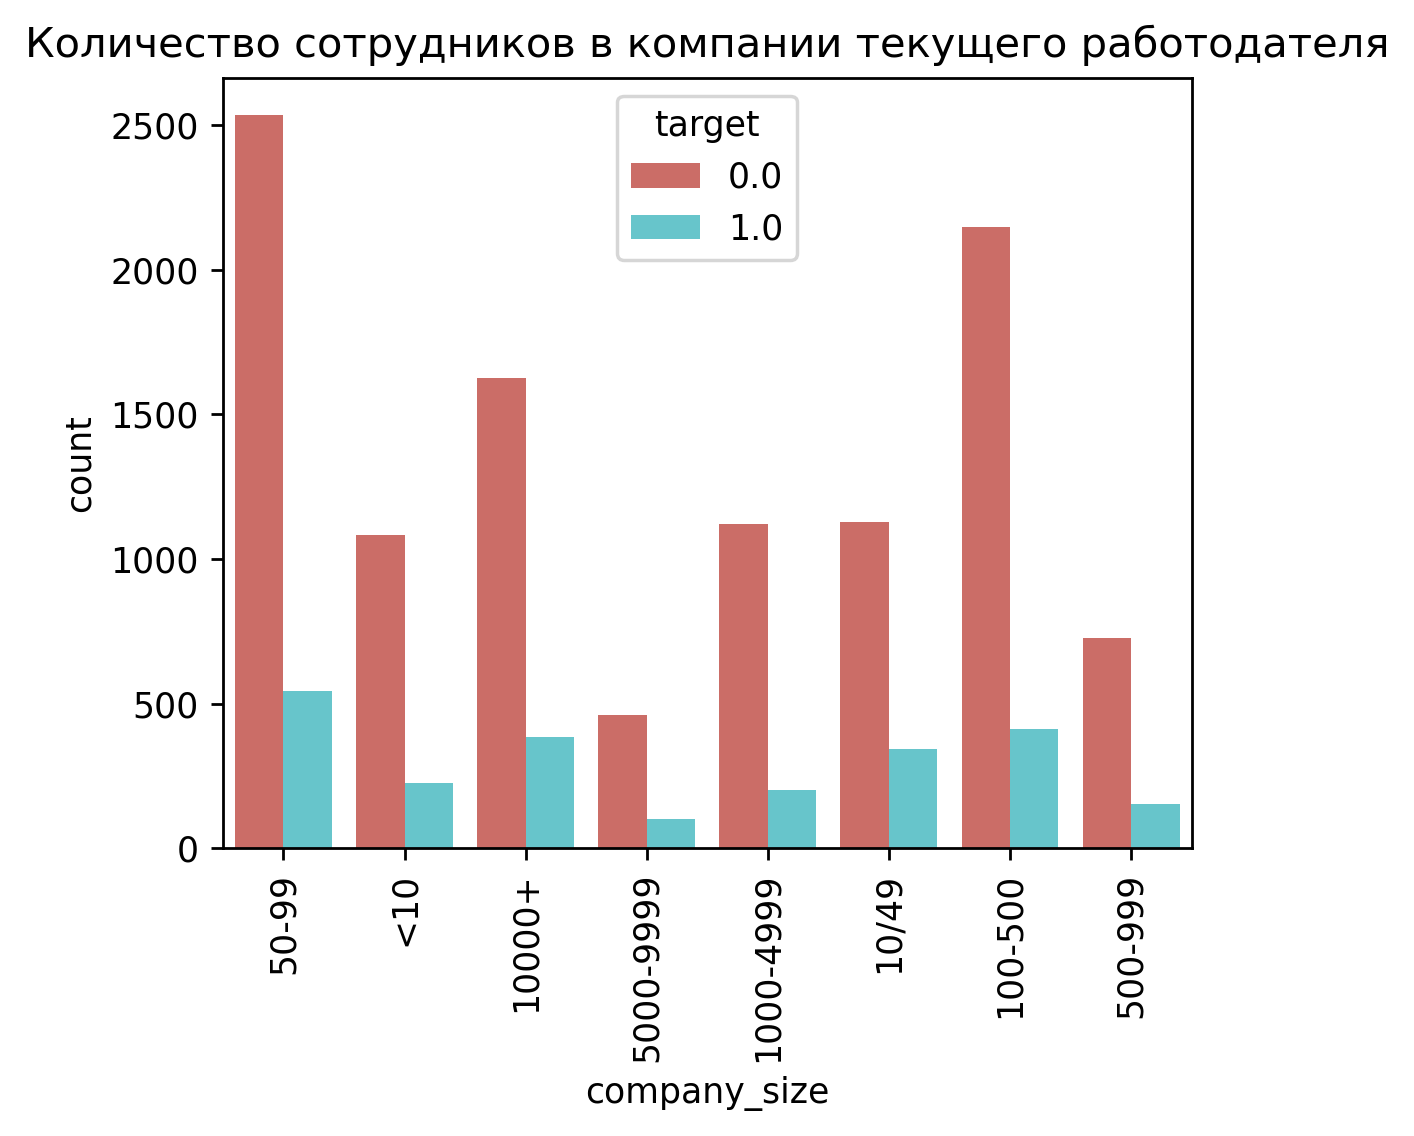

target                    0.0       1.0
company_type                           
Early Stage Startup  0.035497  0.010934
Funded Startup       0.066297  0.010780
NGO                  0.032648  0.007469
Other                0.007084  0.002233
Public Sector        0.057211  0.016170
Pvt Ltd              0.617233  0.136444


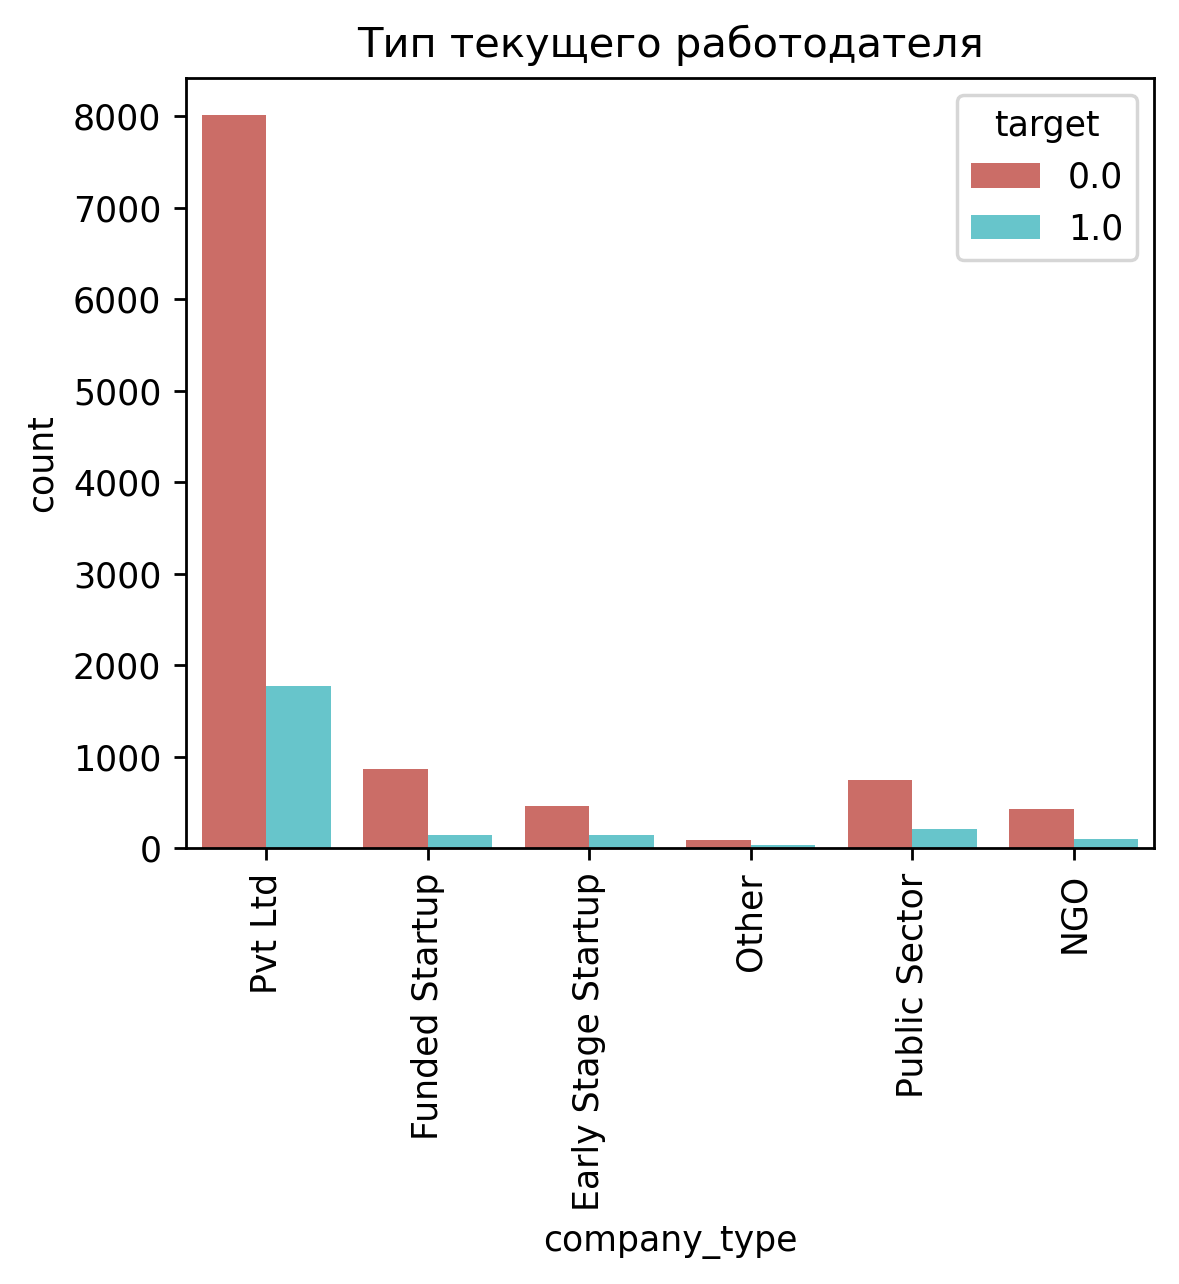

target             0.0       1.0
last_new_job                    
1             0.316066  0.113507
2             0.117414  0.037408
3             0.042438  0.012255
4             0.042866  0.012202
>4            0.142888  0.032003
never         0.091566  0.039388


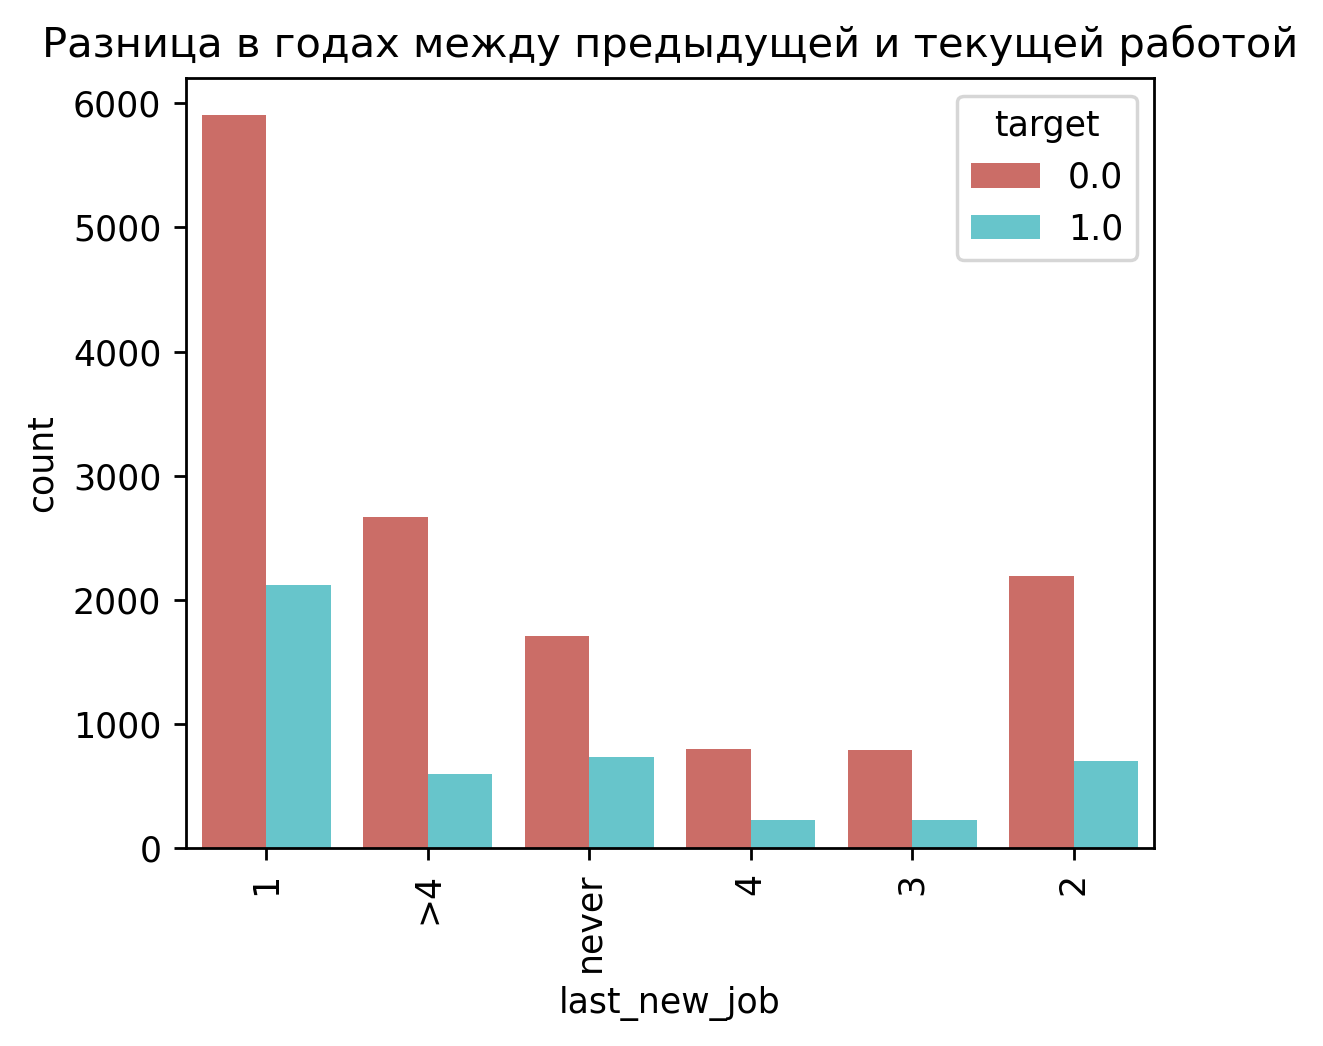

In [76]:
for col in df_cat_columns.drop(["target", "city"], axis=1).columns:
    drow_countplot_cat_hue_target(df_cat_columns, col, feature_descriptions[col])

Процент положительного класса: 24.936%
Процент отрицательного класса: 75.064%


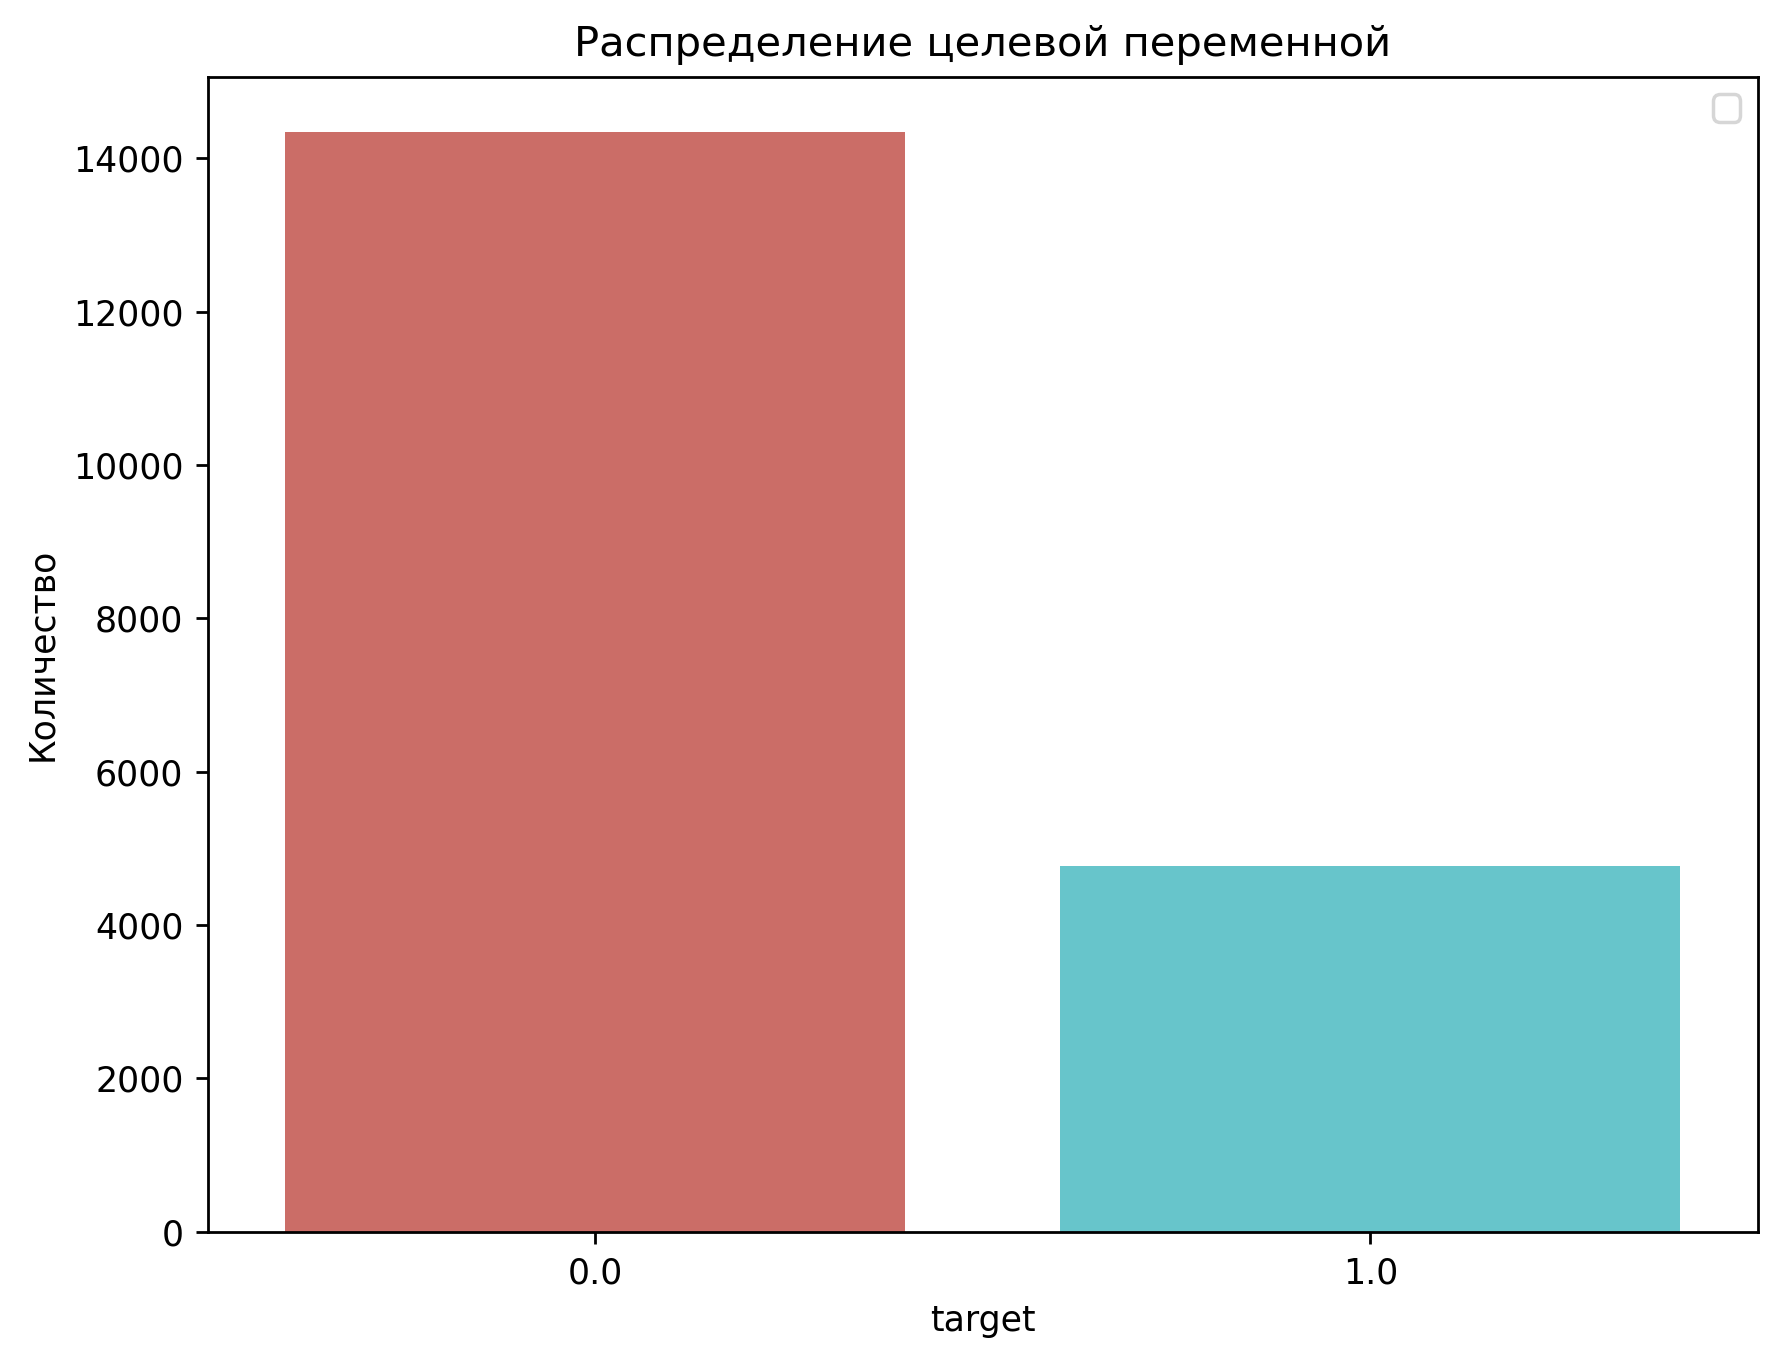

In [88]:
notna_index = df[df["target"].notna()].index

print(f"Процент положительного класса: {round(df[df["target"]==1].shape[0]/len(df.loc[notna_index])*100, 3)}%")
print(f"Процент отрицательного класса: {round(df[df["target"]==0].shape[0]/len(df.loc[notna_index])*100, 3)}%")

fig = plt.figure(figsize=(8, 6), dpi=250)
plt.title("Распределение целевой переменной")
plt.ylabel("Количество")
sns.countplot(data=df.loc[notna_index], x="target", palette="hls")
plt.legend()
plt.show()

### Видно, что отрицательных ровно в 3 раза больше, чем положительных классов
- Проведем эксперемент, пронормируем в crosstable данные так, что положительный класс всегда будет иметь размерность 1, тогда отрицательный клсса таакже будет норммирован на эту величину, суть в том, что есть распределение в отрицательном классе везде будет почти равен 3, то это говорит, что признак не важен, так как доля положительно и отрицательного класса будет походит на исходное распределение, а если будет число, которое сильно отличается от 3, тогда это говорит, что категориая сильно влияет на распределение целевого значения
- Пронормируем данные в crosstable так, что доля для класса 1 будет равна 1, а для класса 0 будет перевзвешана на такую же константу, что и для класса 1

In [106]:
#Метод, который не просто отрисовывает гистограмму для различных target, но и отрисовывает нормированную crosstable
def drow_countplot_cat_crosstab(df, col, description):
    normal_coef = 1 / pd.crosstab(df_cat_columns[col], df_cat_columns["target"], normalize=True)[1.0]
    cross_table = pd.crosstab(df_cat_columns[col], df_cat_columns["target"], normalize=True)
    cross_table[0.0] = cross_table[0.0] * normal_coef
    cross_table[1.0] = cross_table[1.0] * normal_coef
    print(cross_table)
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(description)
    sns.countplot(data=df, x=col, palette="hls", hue="target")
    plt.xticks(rotation=90)
    plt.show()

target       0.0  1.0
gender               
Female  2.794479  1.0
Male    3.391000  1.0
Other   2.820000  1.0


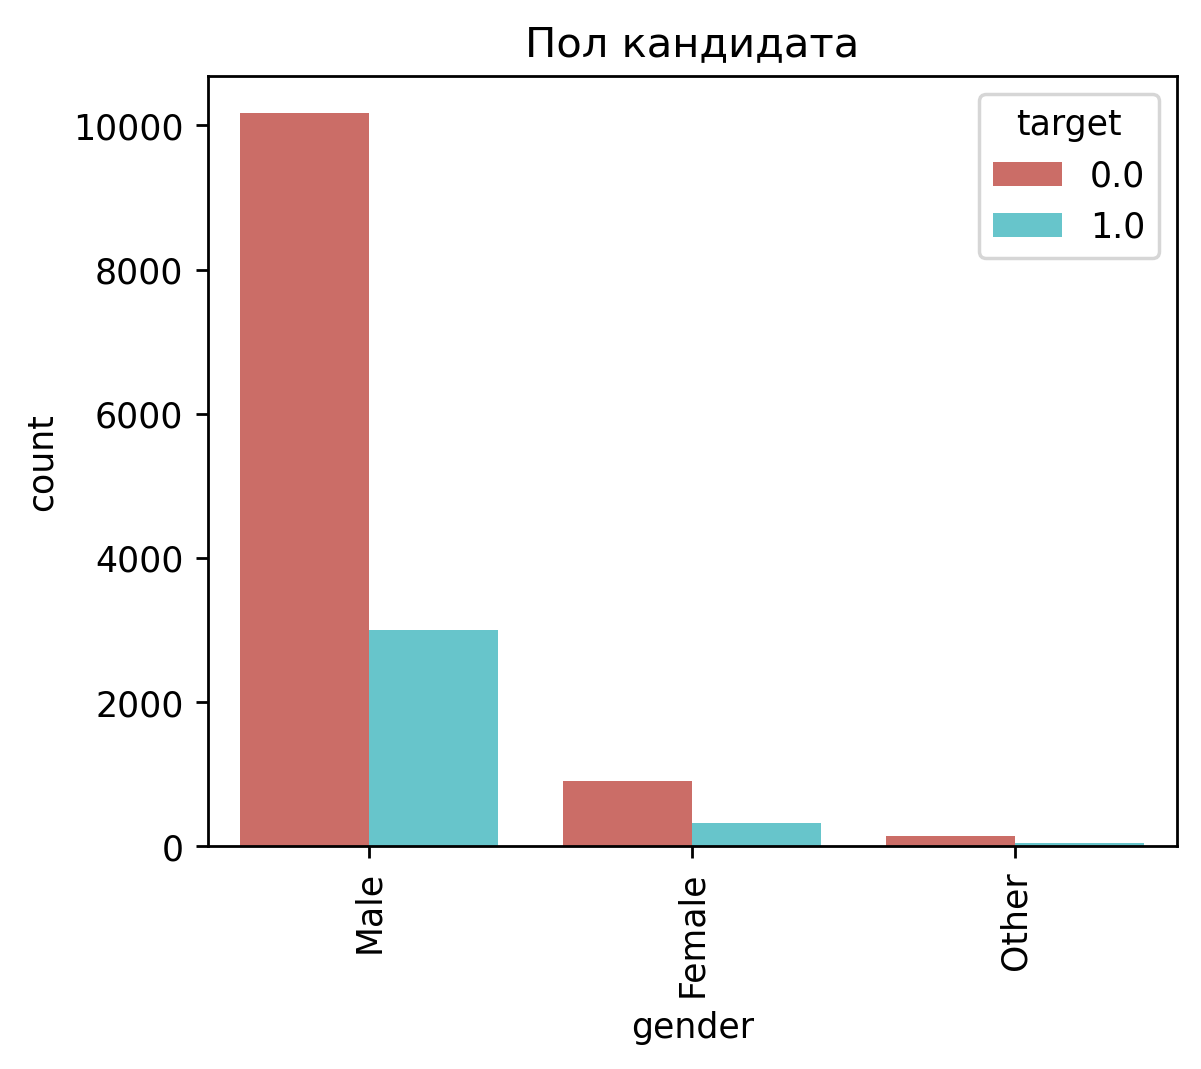

target                        0.0  1.0
relevent_experience                   
Has relevent experience  3.655943  1.0
No relevent experience   1.958057  1.0


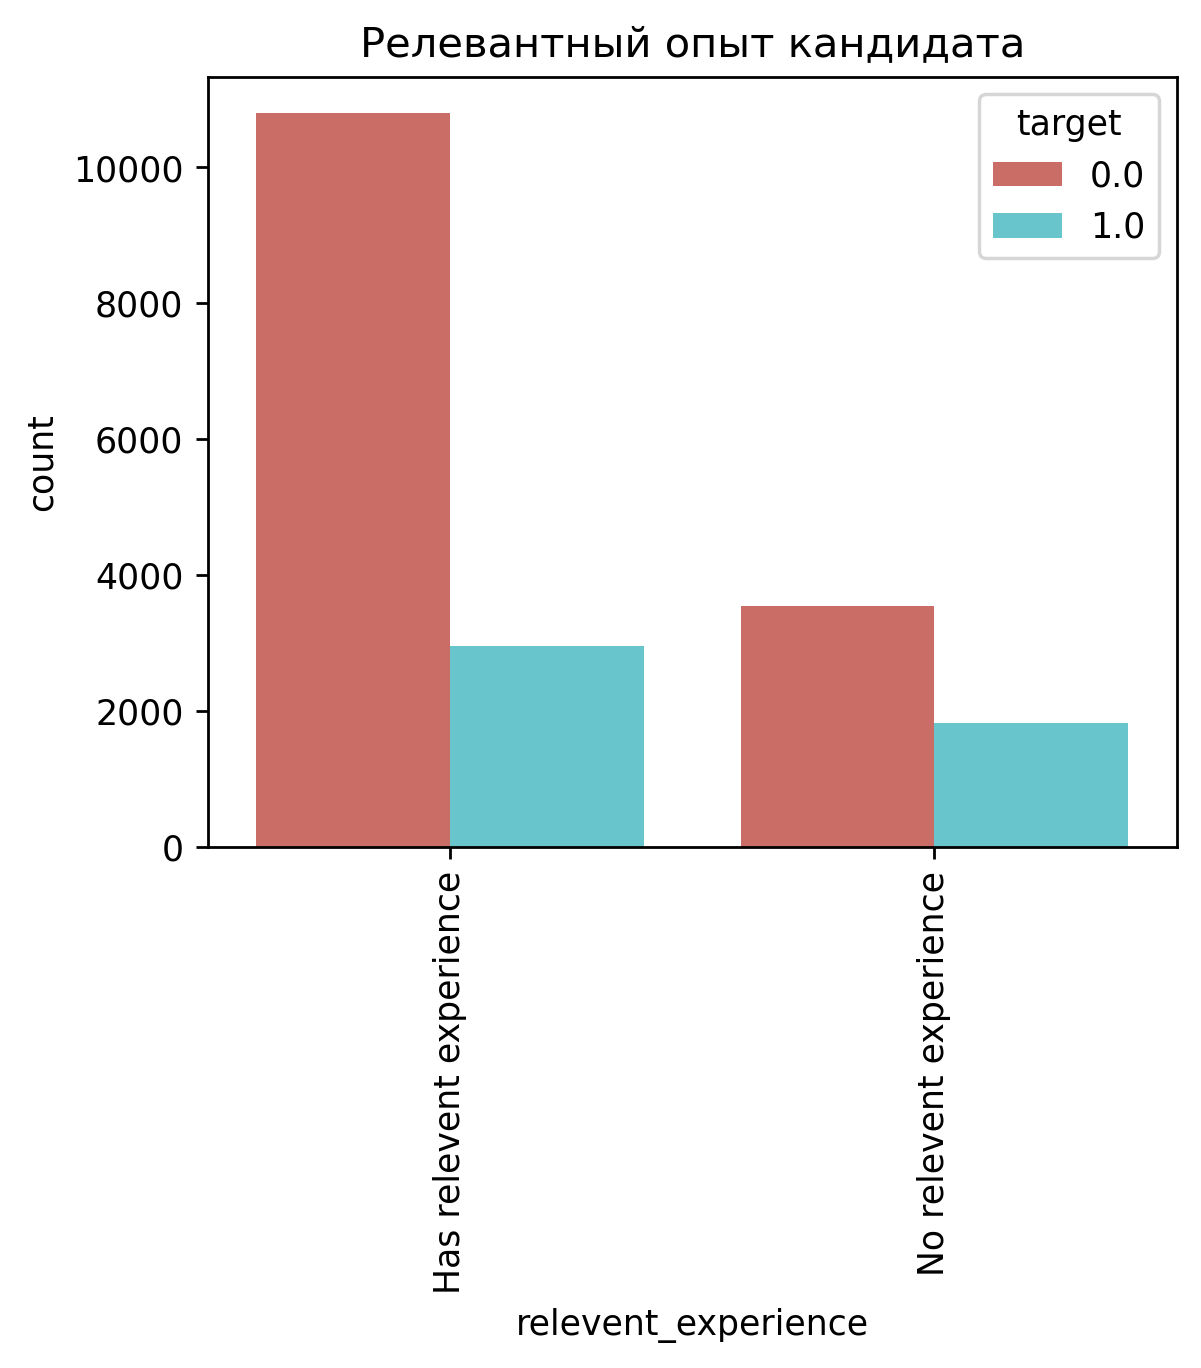

target                    0.0  1.0
enrolled_university               
Full time course     1.629993  1.0
Part time course     2.966887  1.0
no_enrollment        3.727772  1.0


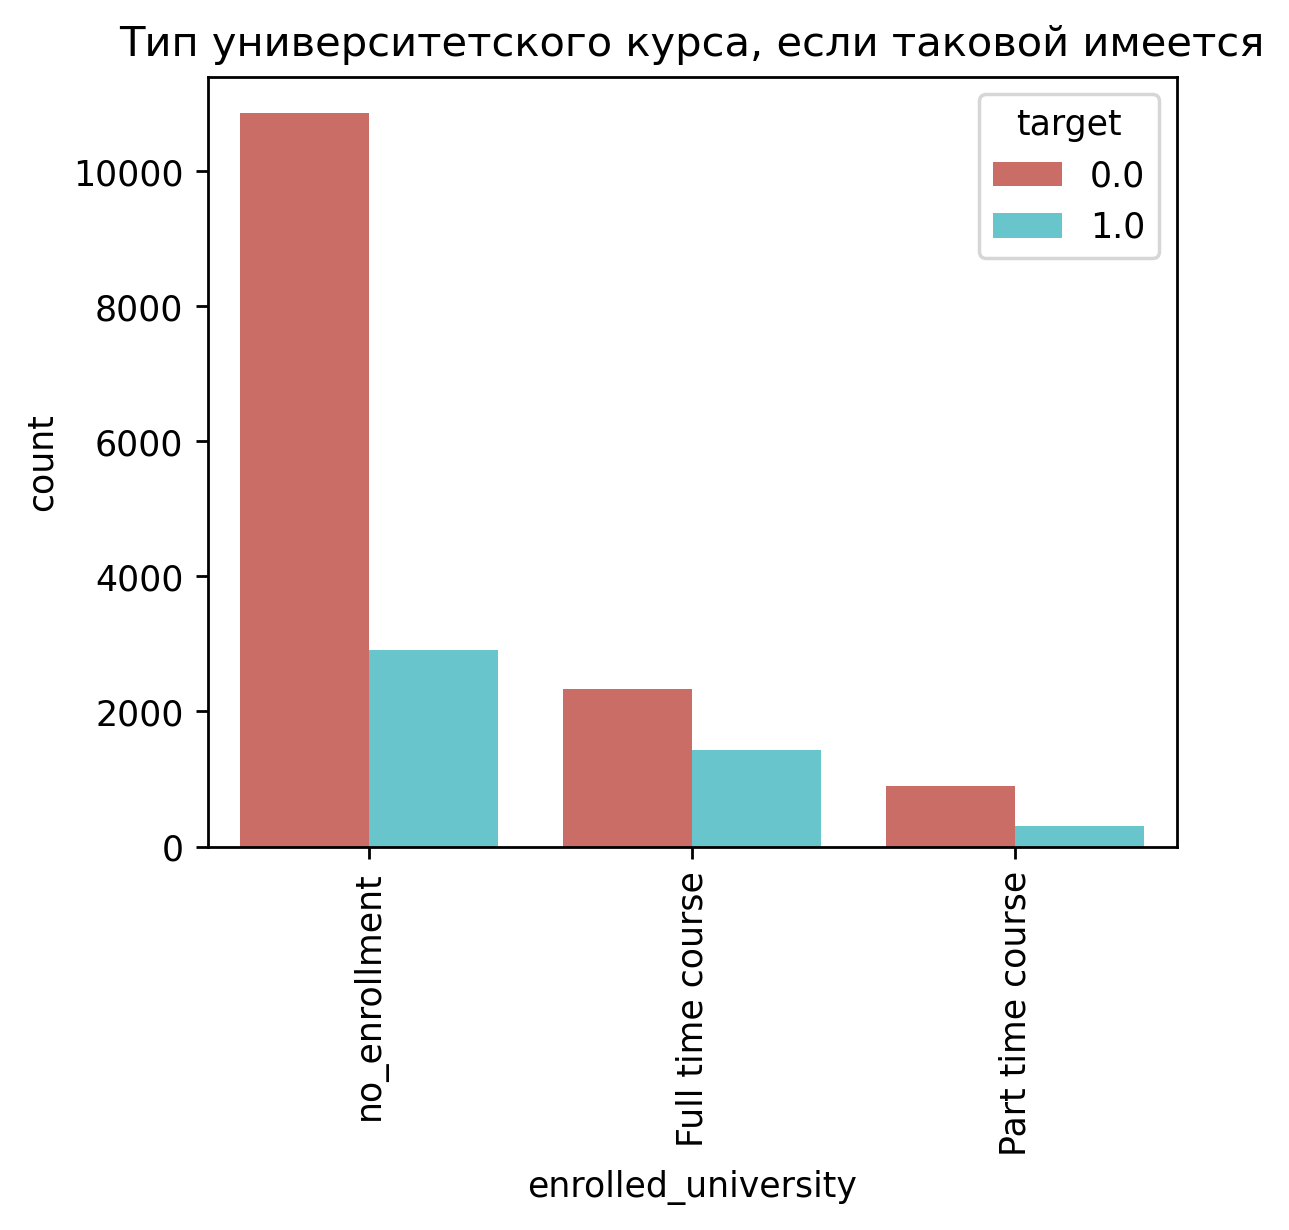

target                0.0  1.0
education_level               
Graduate         2.573284  1.0
High School      4.122137  1.0
Masters          3.660963  1.0
Phd              6.137931  1.0
Primary School   6.512195  1.0


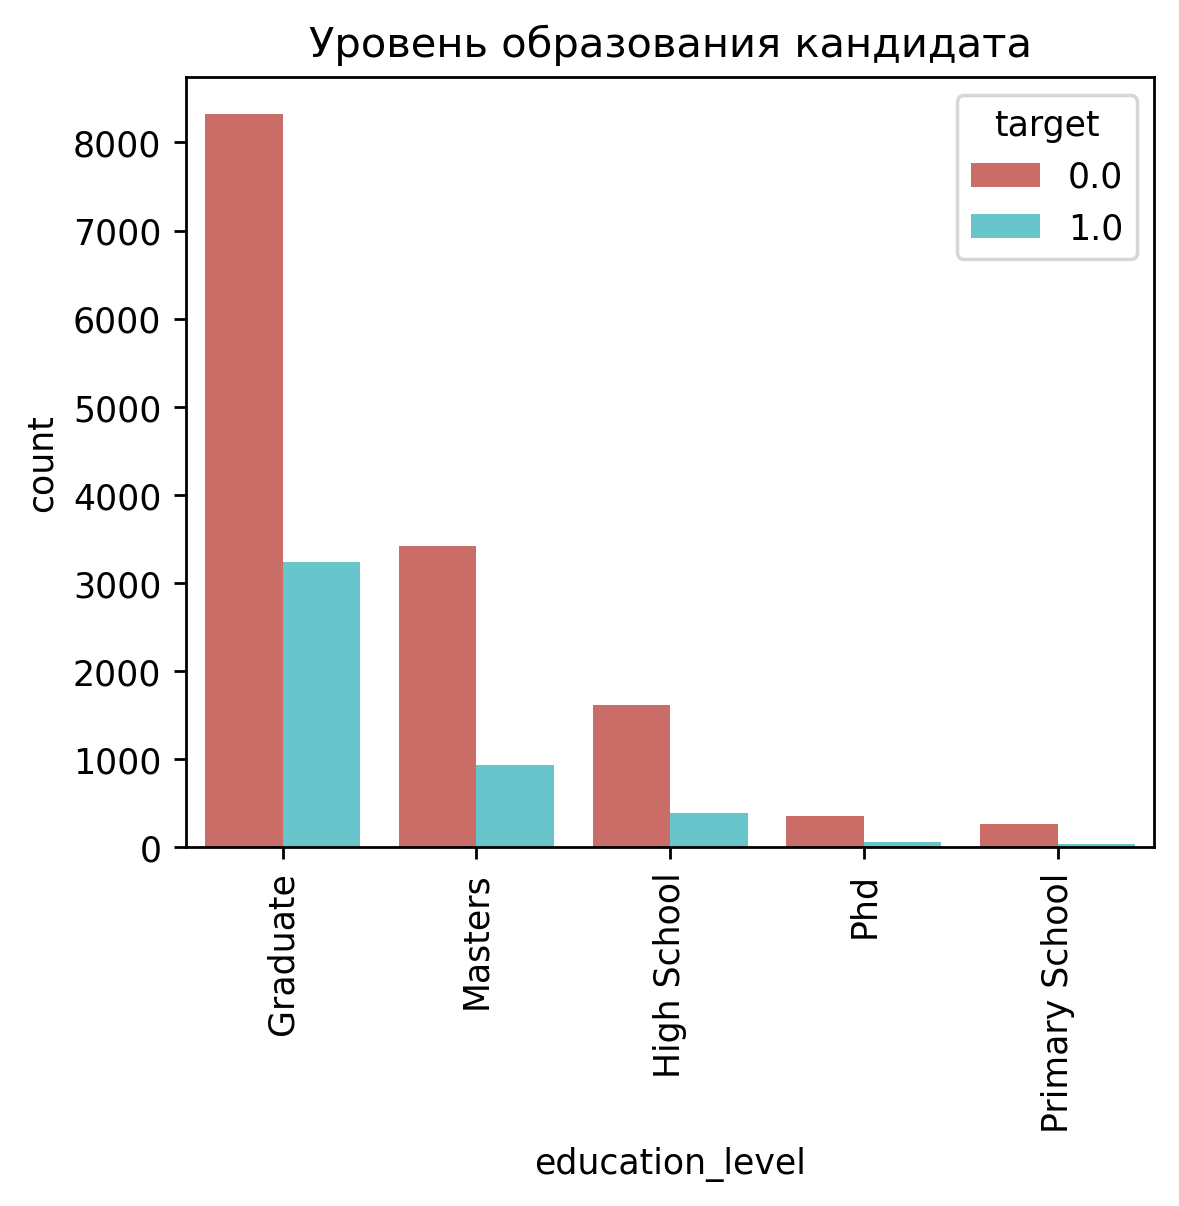

target                 0.0  1.0
major_discipline               
Arts              3.773585  1.0
Business Degree   2.802326  1.0
Humanities        3.744681  1.0
No Major          3.054545  1.0
Other             2.735294  1.0
STEM              2.821958  1.0


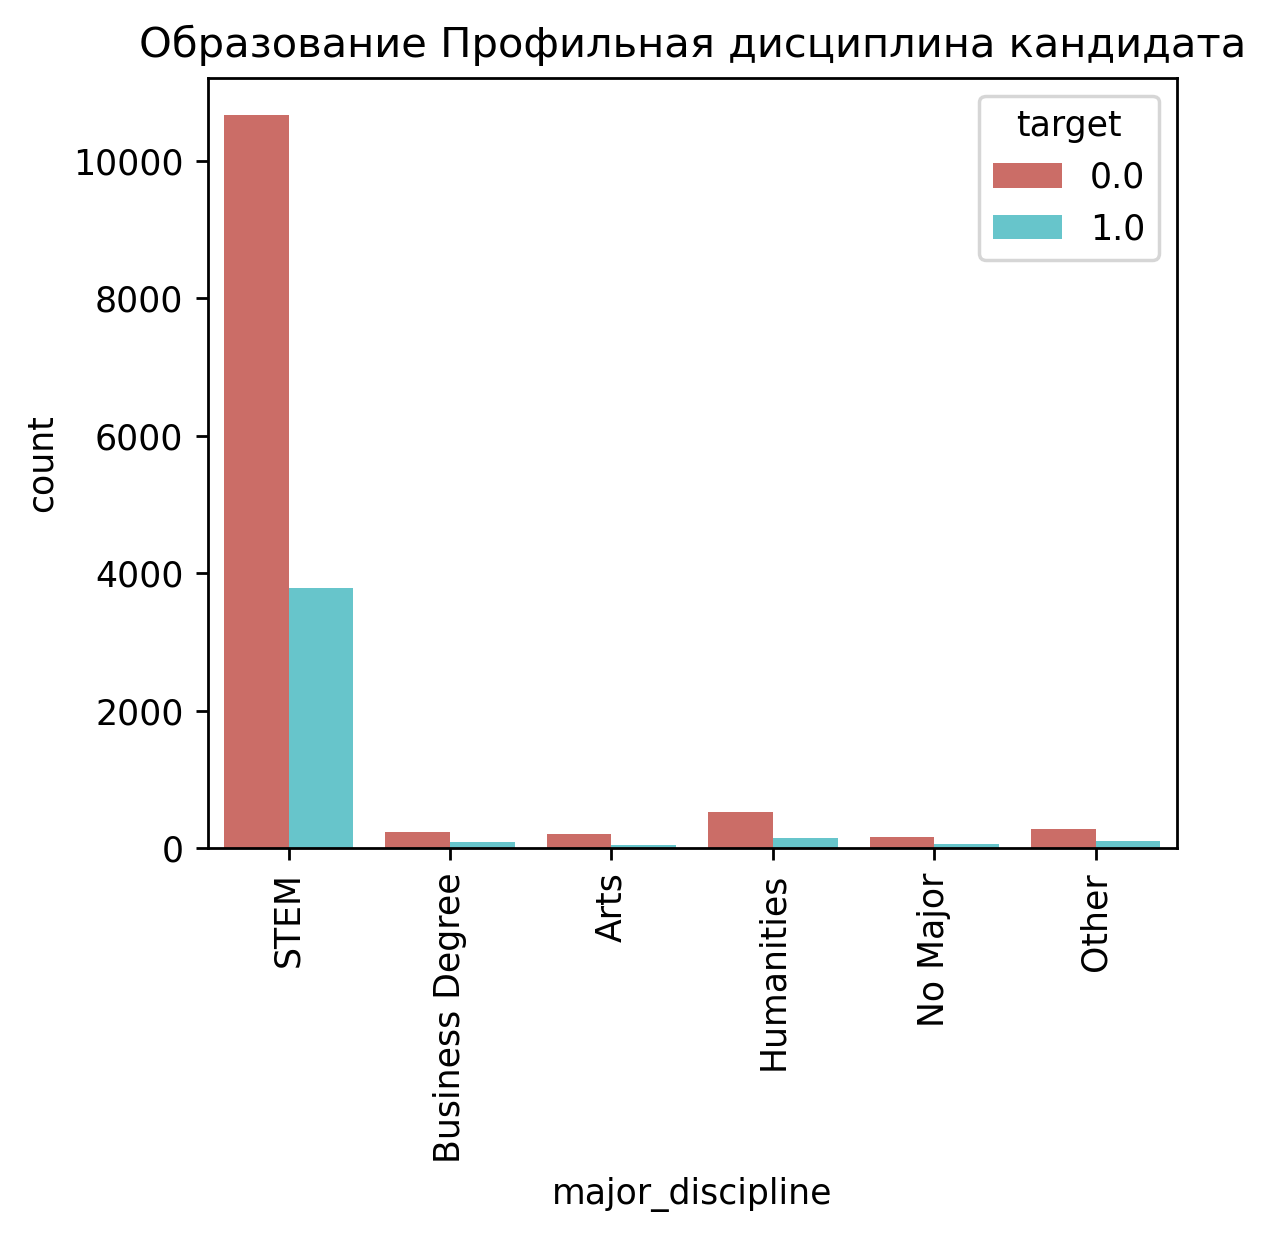

target           0.0  1.0
experience               
1           1.356223  1.0
10          3.758454  1.0
11          3.397351  1.0
12          4.369565  1.0
13          4.181818  1.0
14          4.476636  1.0
15          4.991228  1.0
16          6.041667  1.0
17          5.000000  1.0
18          5.511628  1.0
19          4.735849  1.0
2           2.024194  1.0
20          3.484848  1.0
3           1.830544  1.0
4           2.072368  1.0
5           2.474453  1.0
6           2.549708  1.0
7           2.400662  1.0
8           3.112821  1.0
9           3.596244  1.0
<1          1.207627  1.0
>20         5.532129  1.0


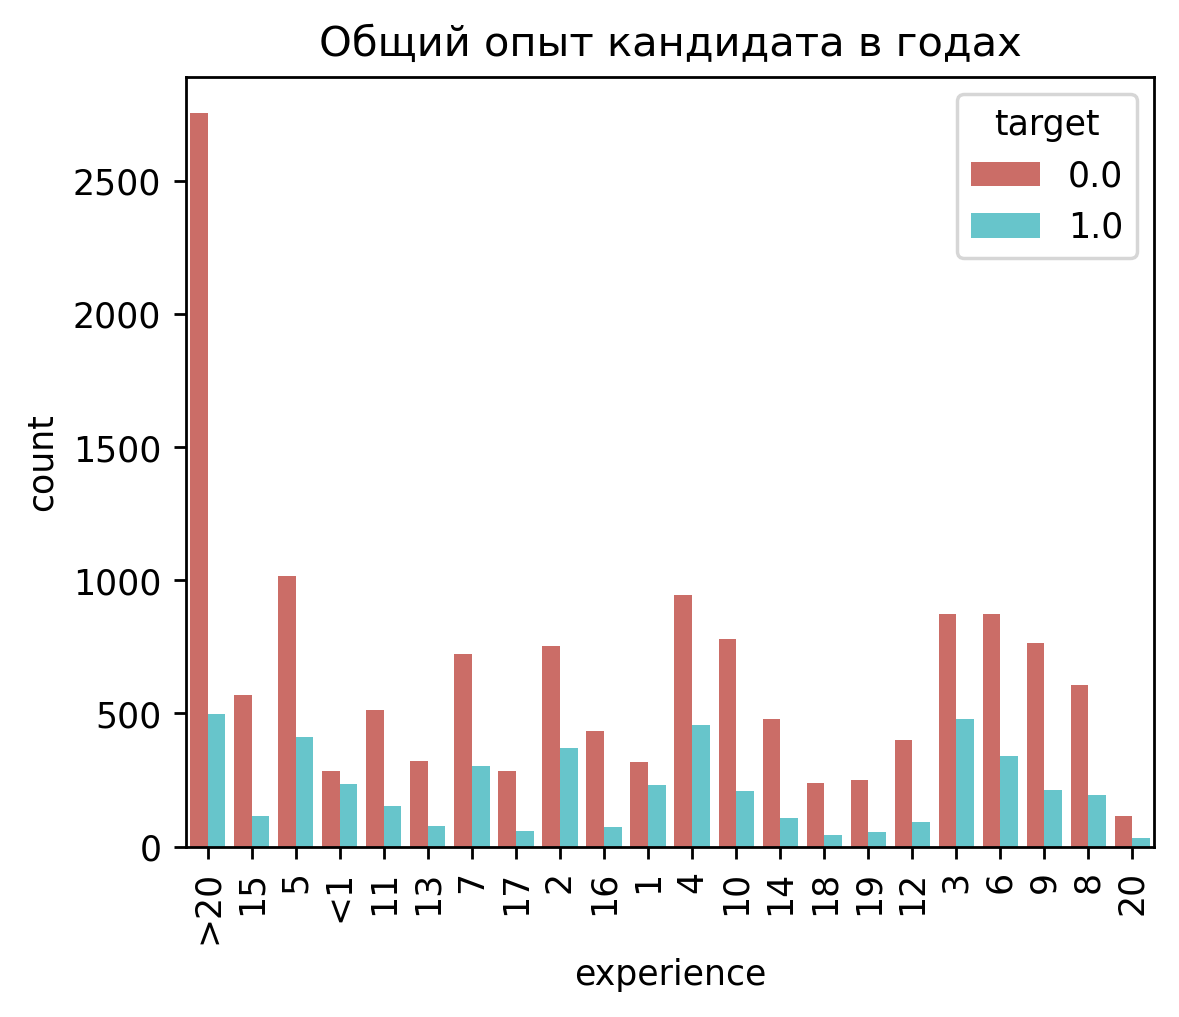

target             0.0  1.0
company_size               
10/49         3.273256  1.0
100-500       5.200969  1.0
1000-4999     5.610000  1.0
10000+        4.231771  1.0
50-99         4.651376  1.0
500-999       4.769737  1.0
5000-9999     4.509804  1.0
<10           4.839286  1.0


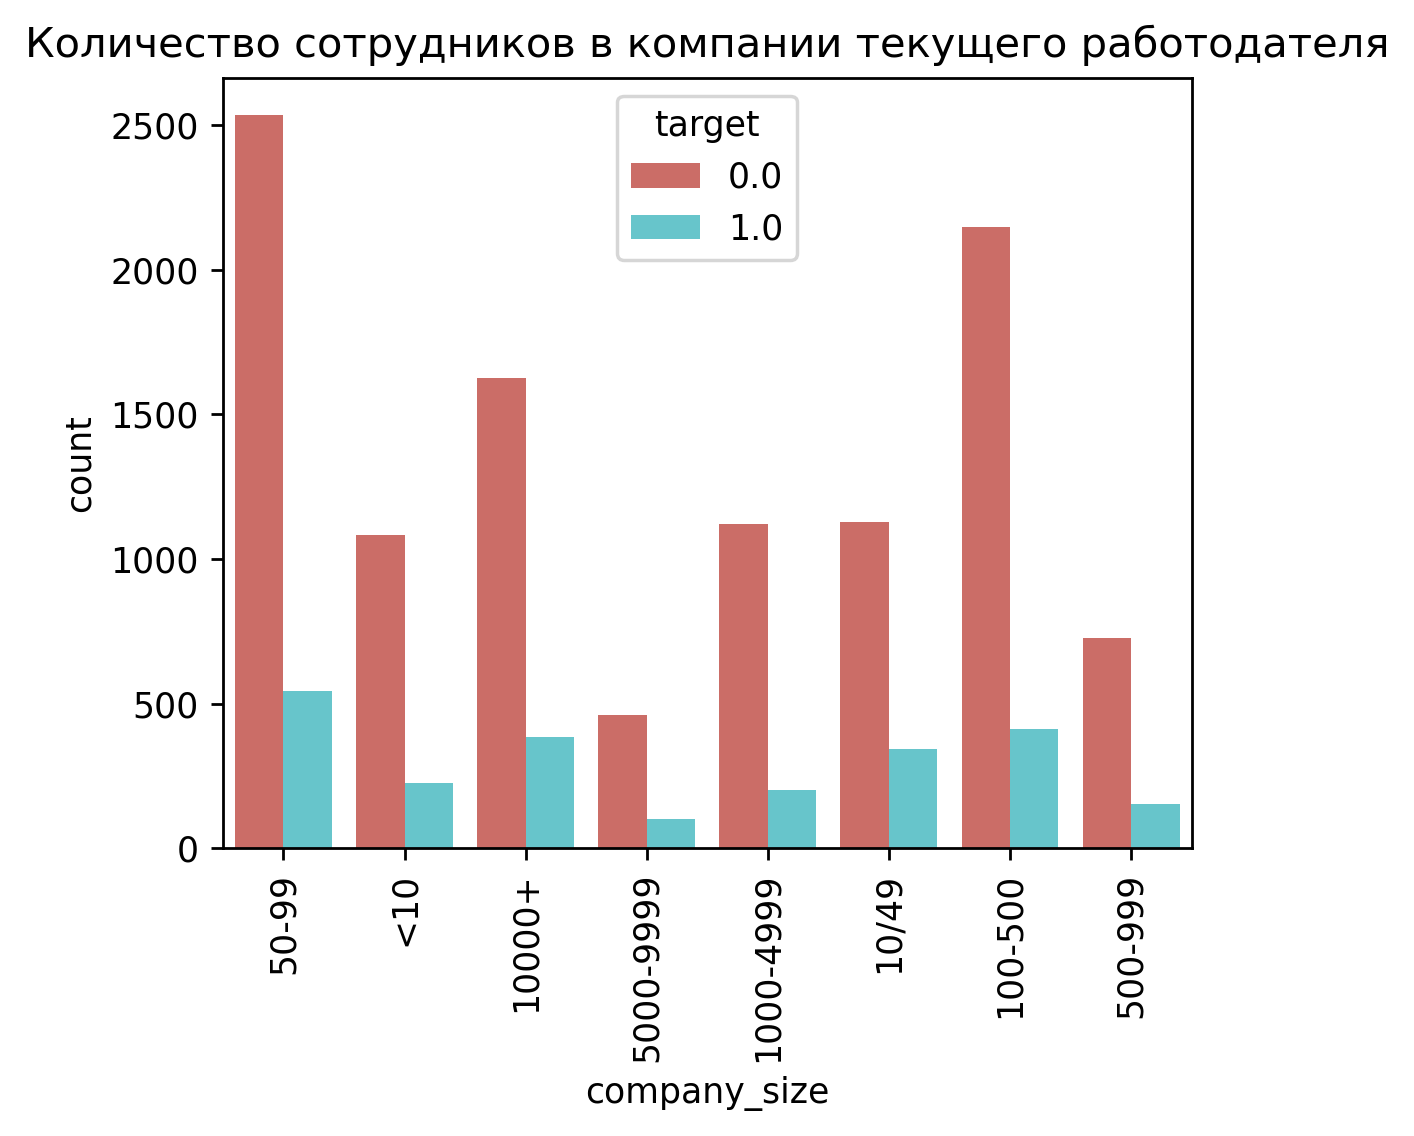

target                    0.0  1.0
company_type                      
Early Stage Startup  3.246479  1.0
Funded Startup       6.150000  1.0
NGO                  4.371134  1.0
Other                3.172414  1.0
Public Sector        3.538095  1.0
Pvt Ltd              4.523702  1.0


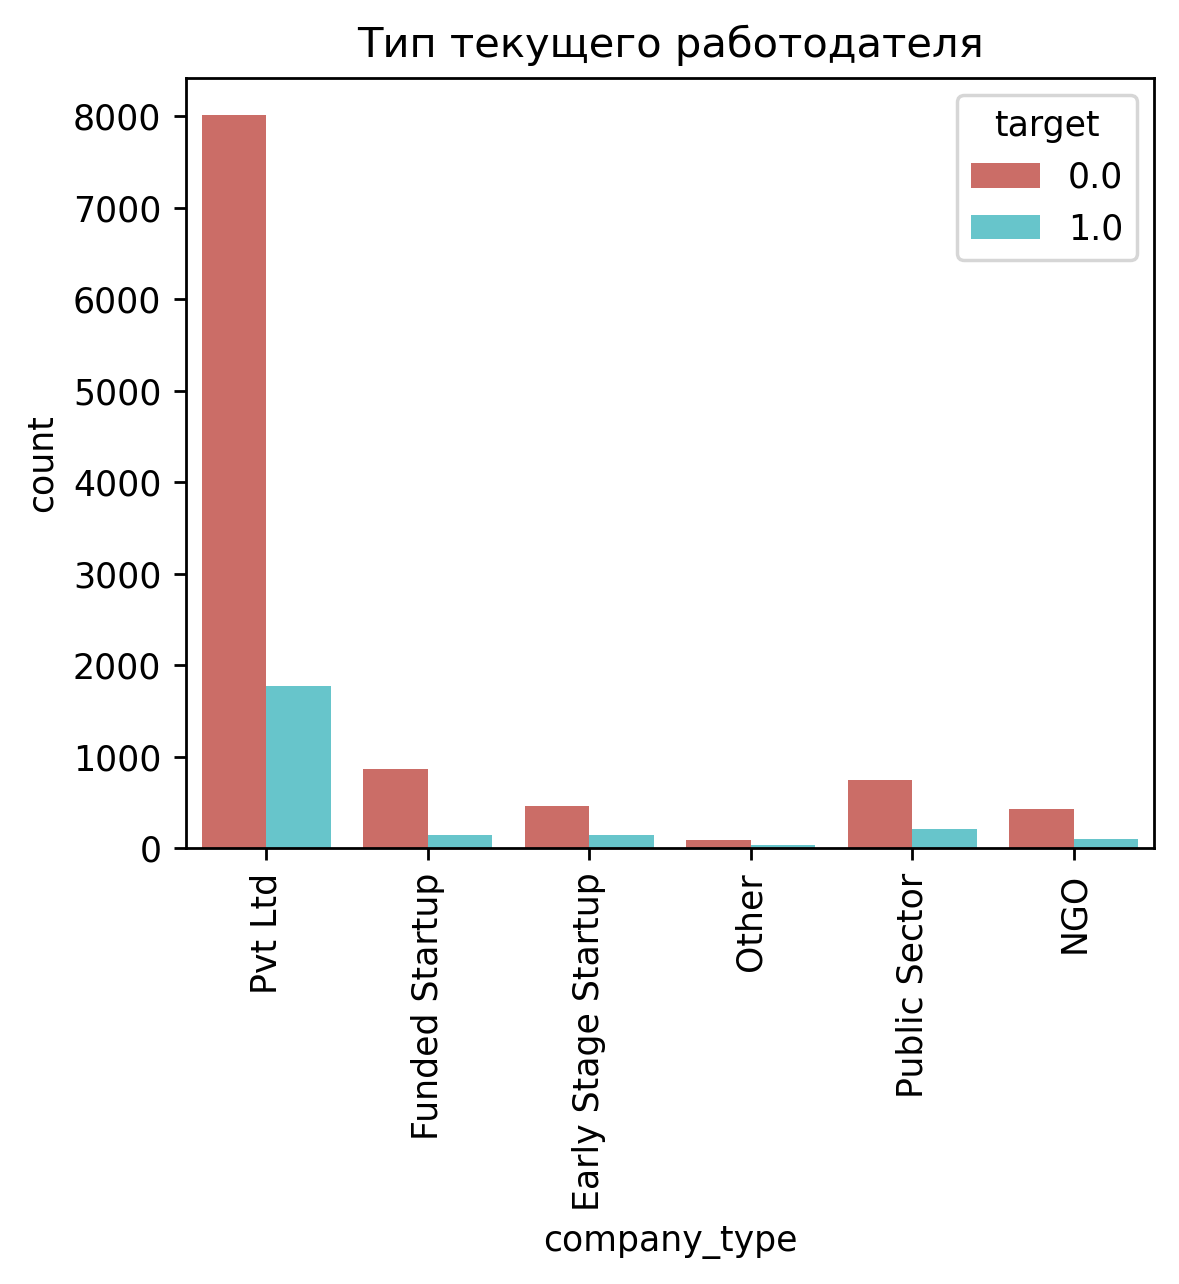

target             0.0  1.0
last_new_job               
1             2.784536  1.0
2             3.138770  1.0
3             3.462882  1.0
4             3.513158  1.0
>4            4.464883  1.0
never         2.324728  1.0


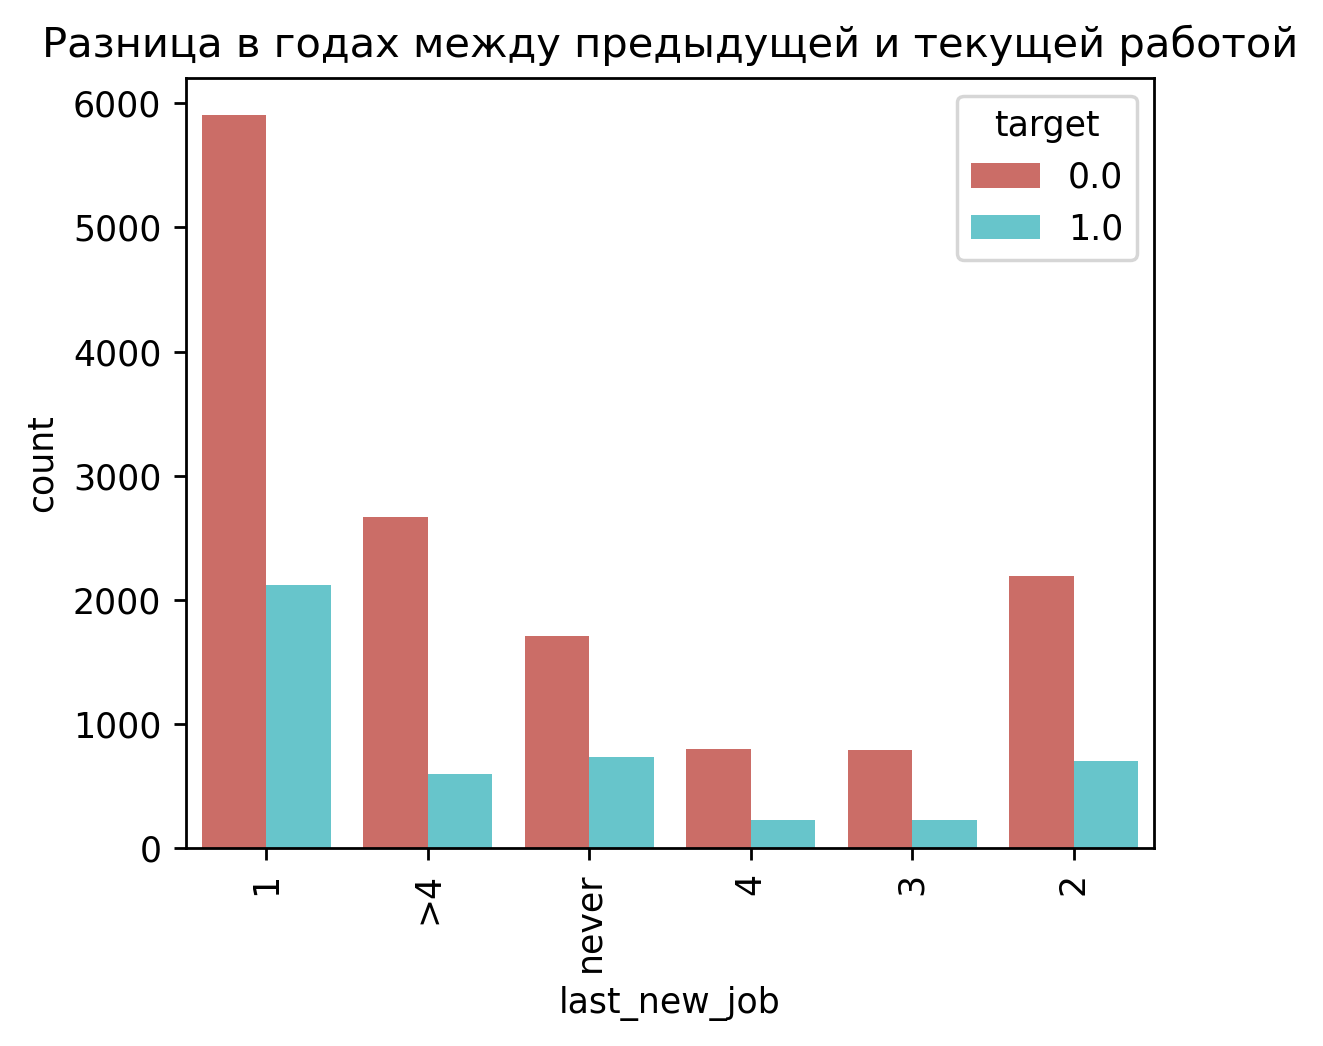

In [110]:
for col in df_cat_columns.loc[df_cat_columns[df_cat_columns["target"].notna()].index].drop(["target", "city"], axis=1).columns:
    drow_countplot_cat_crosstab(df_cat_columns, col, feature_descriptions[col])

### Результат
- В каждой категории, есть есть отличия для распределения, поэтому данные категории оставляем

In [116]:
#Метод, который отрисовывает распределение различных категории для положительного таргета, при этом упорядочив его
def plot_conversion_by_category(col, df, description):
    percentage_ratio = df.groupby(col)["target"].value_counts(normalize=True).unstack()
    percentage_ratio = percentage_ratio.sort_values(by=1, ascending=False)
    
    fig = plt.figure(figsize=(5, 4), dpi=250)
    plt.title(f"Процентное положительное соотношение колонки {description}")
    plt.xlabel(f"Категории признака {col}")
    plt.ylabel(f"Процентное соотношение признака {col} для y=1")
    sns.barplot(x=percentage_ratio.index, y=percentage_ratio[1], palette='viridis')
    plt.xticks(rotation=45)
    plt.show()

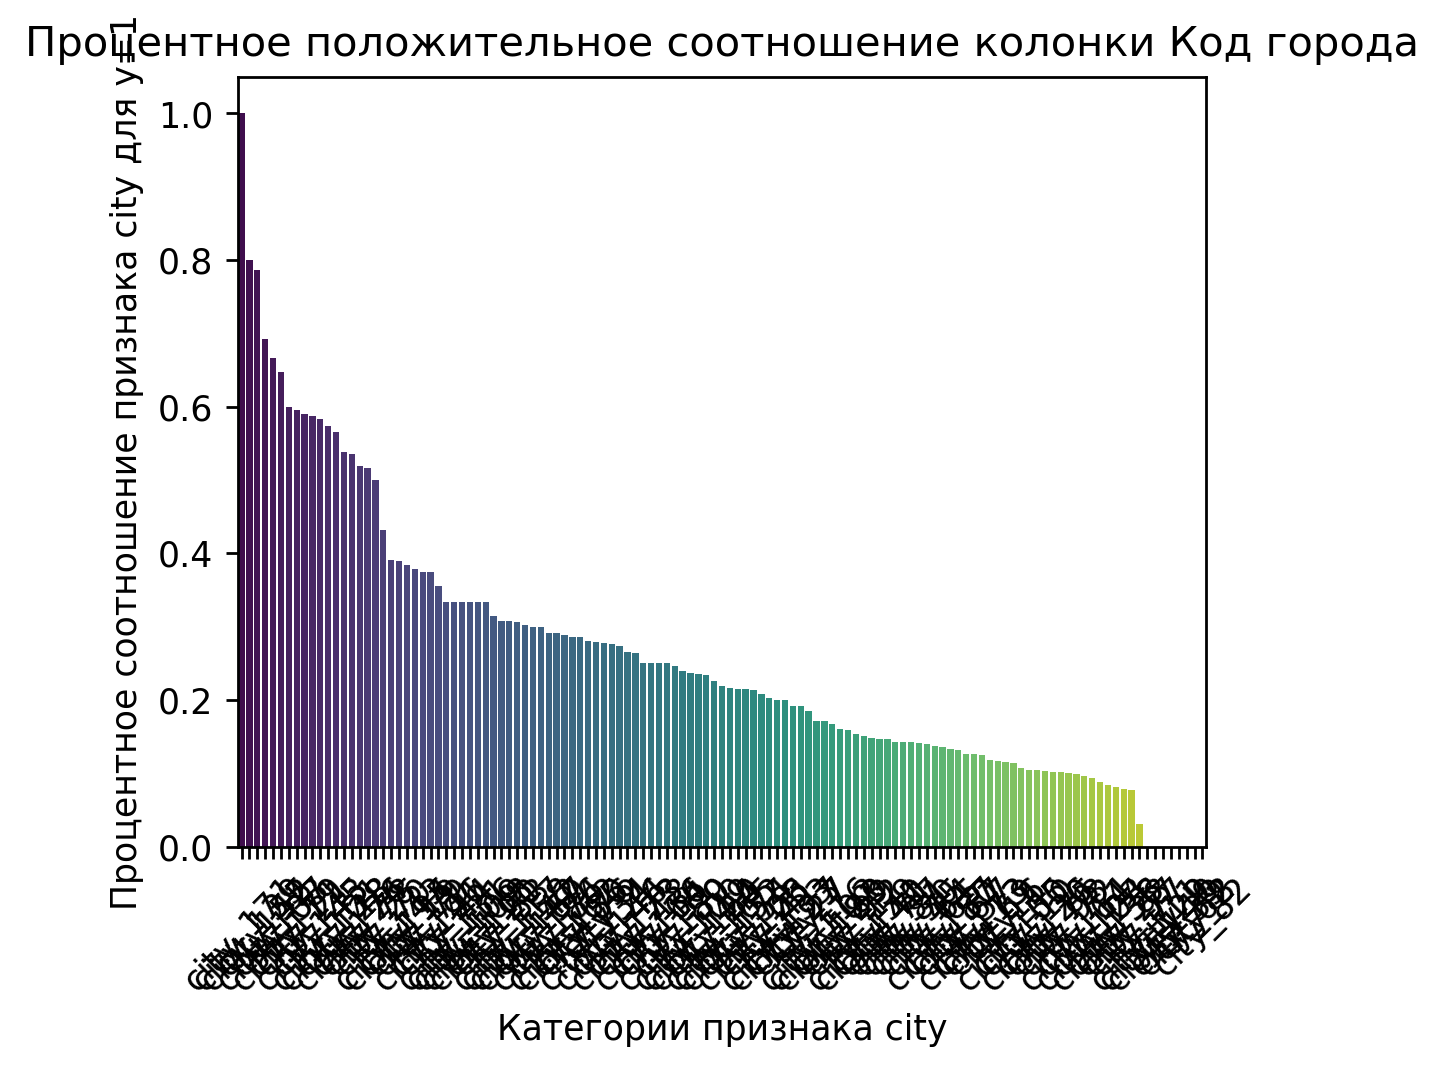

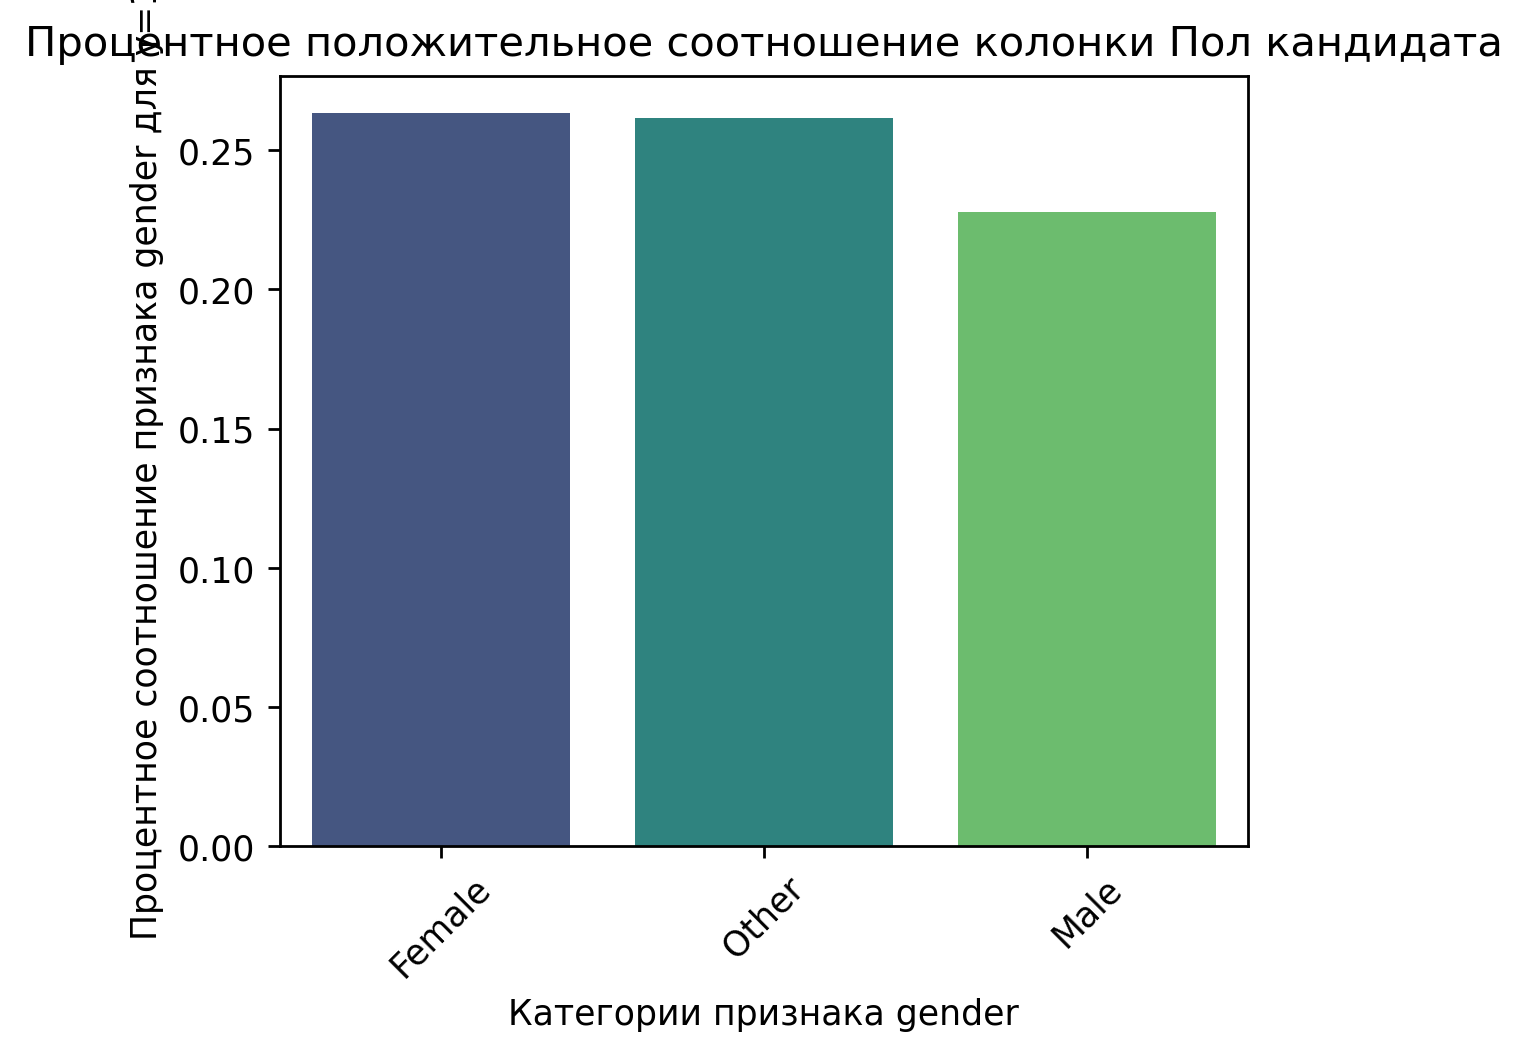

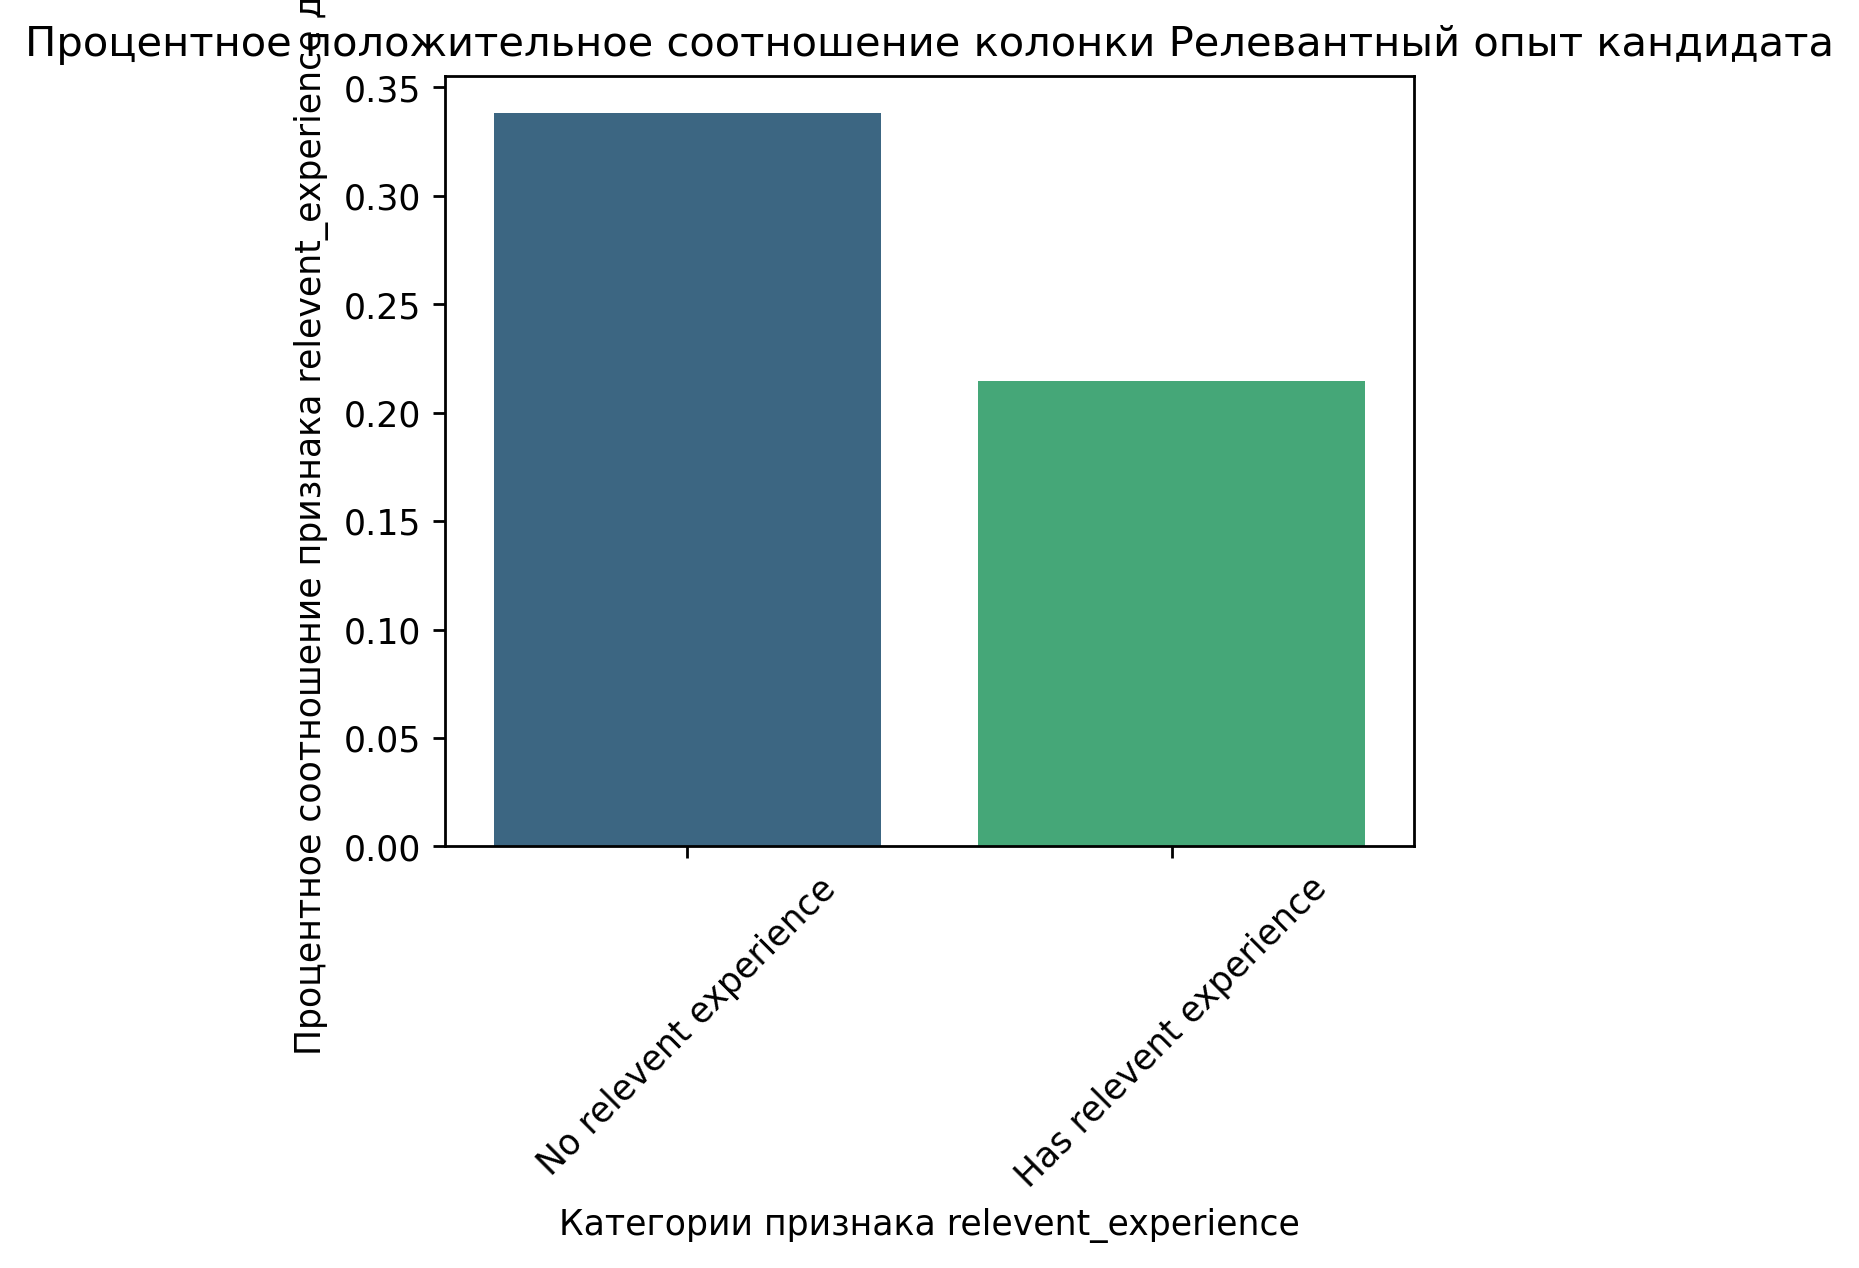

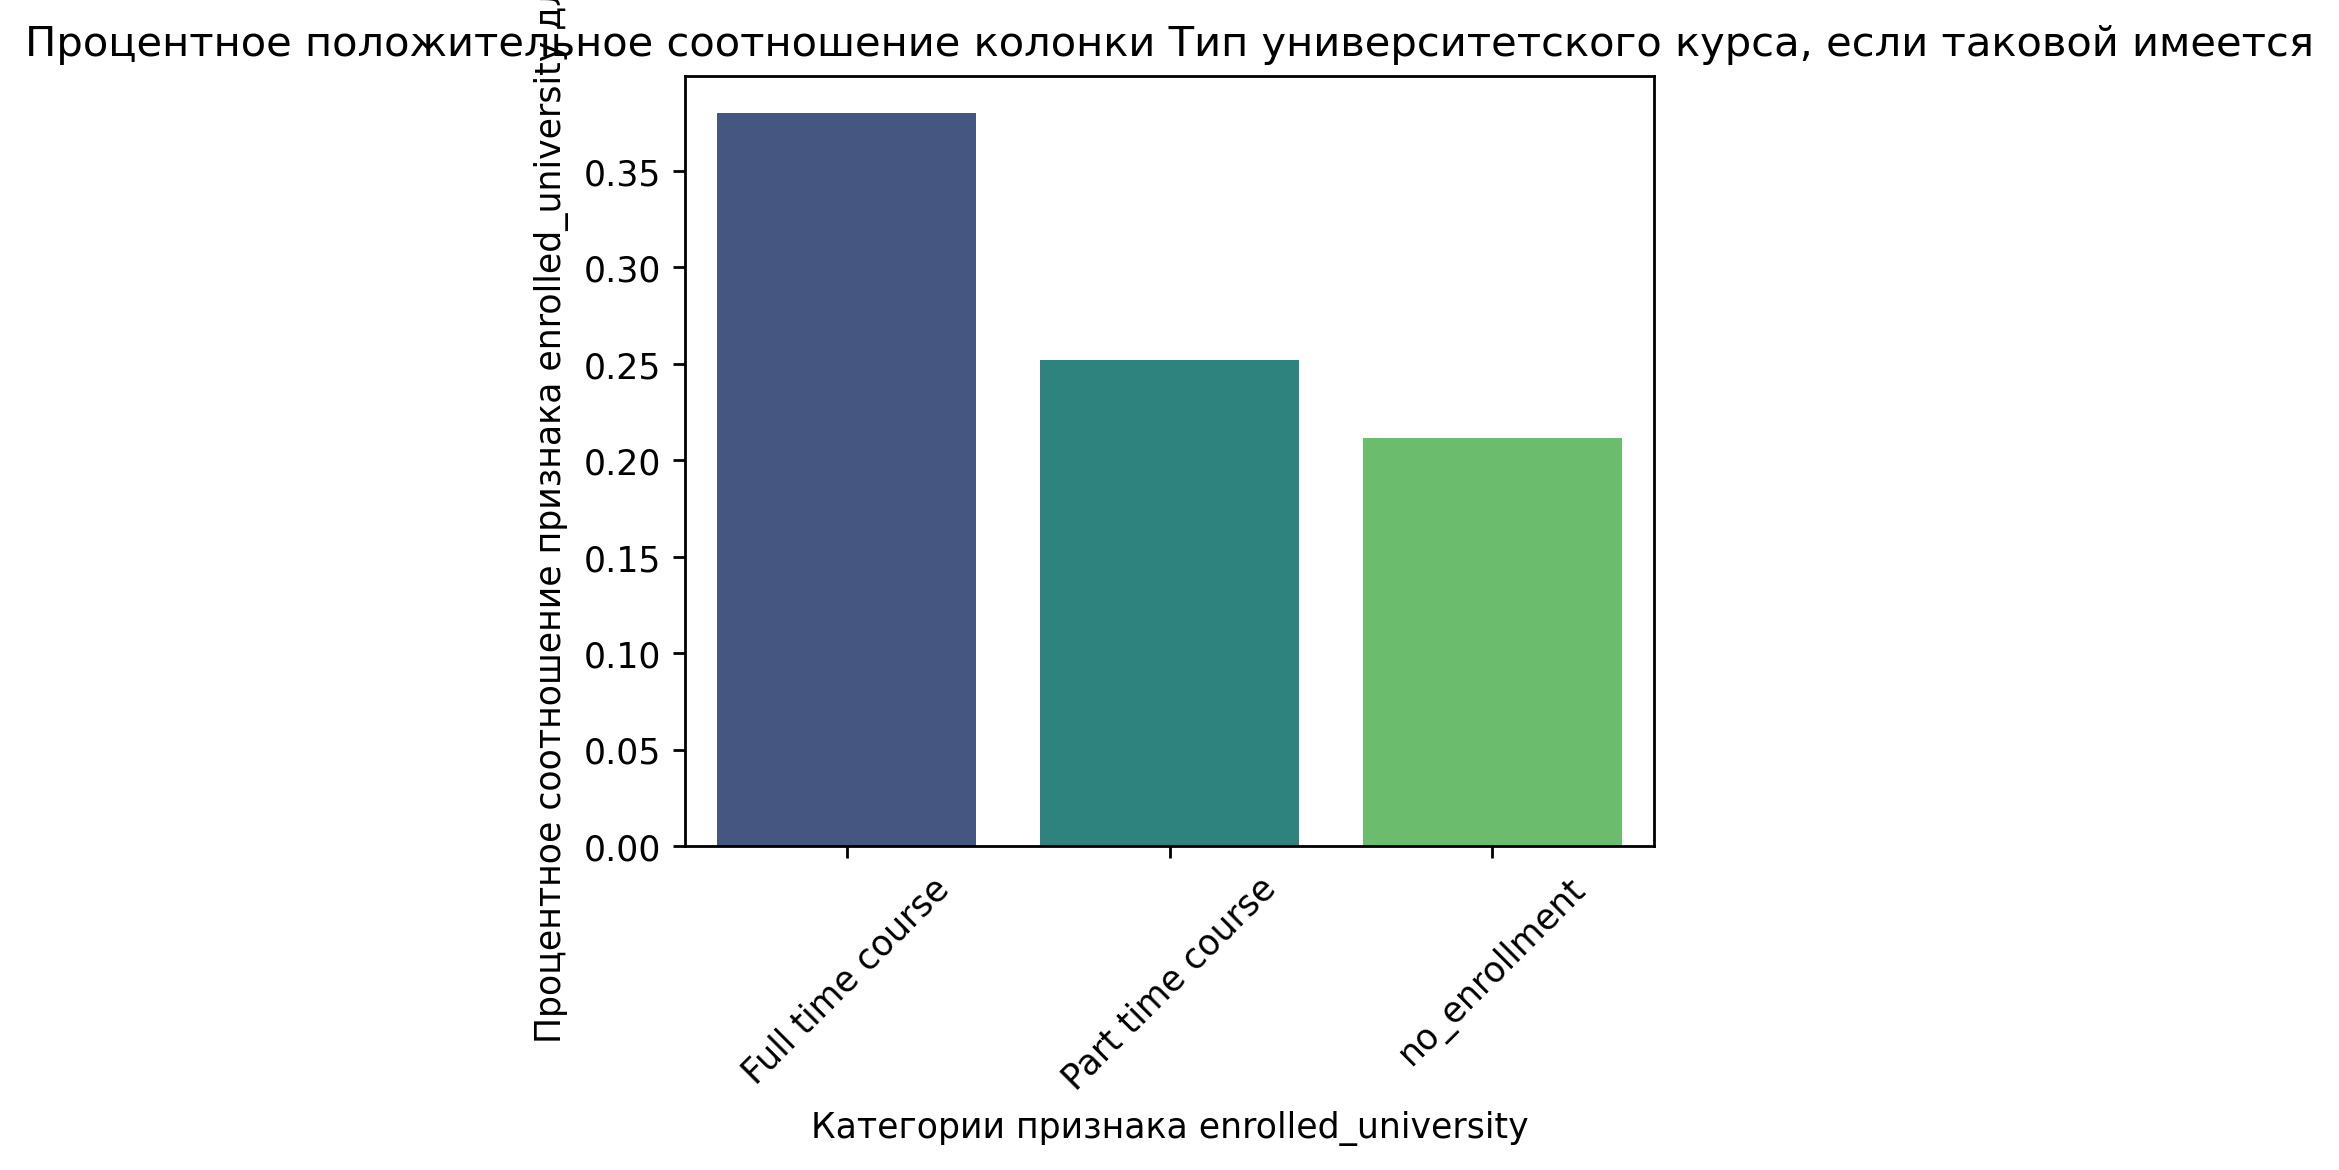

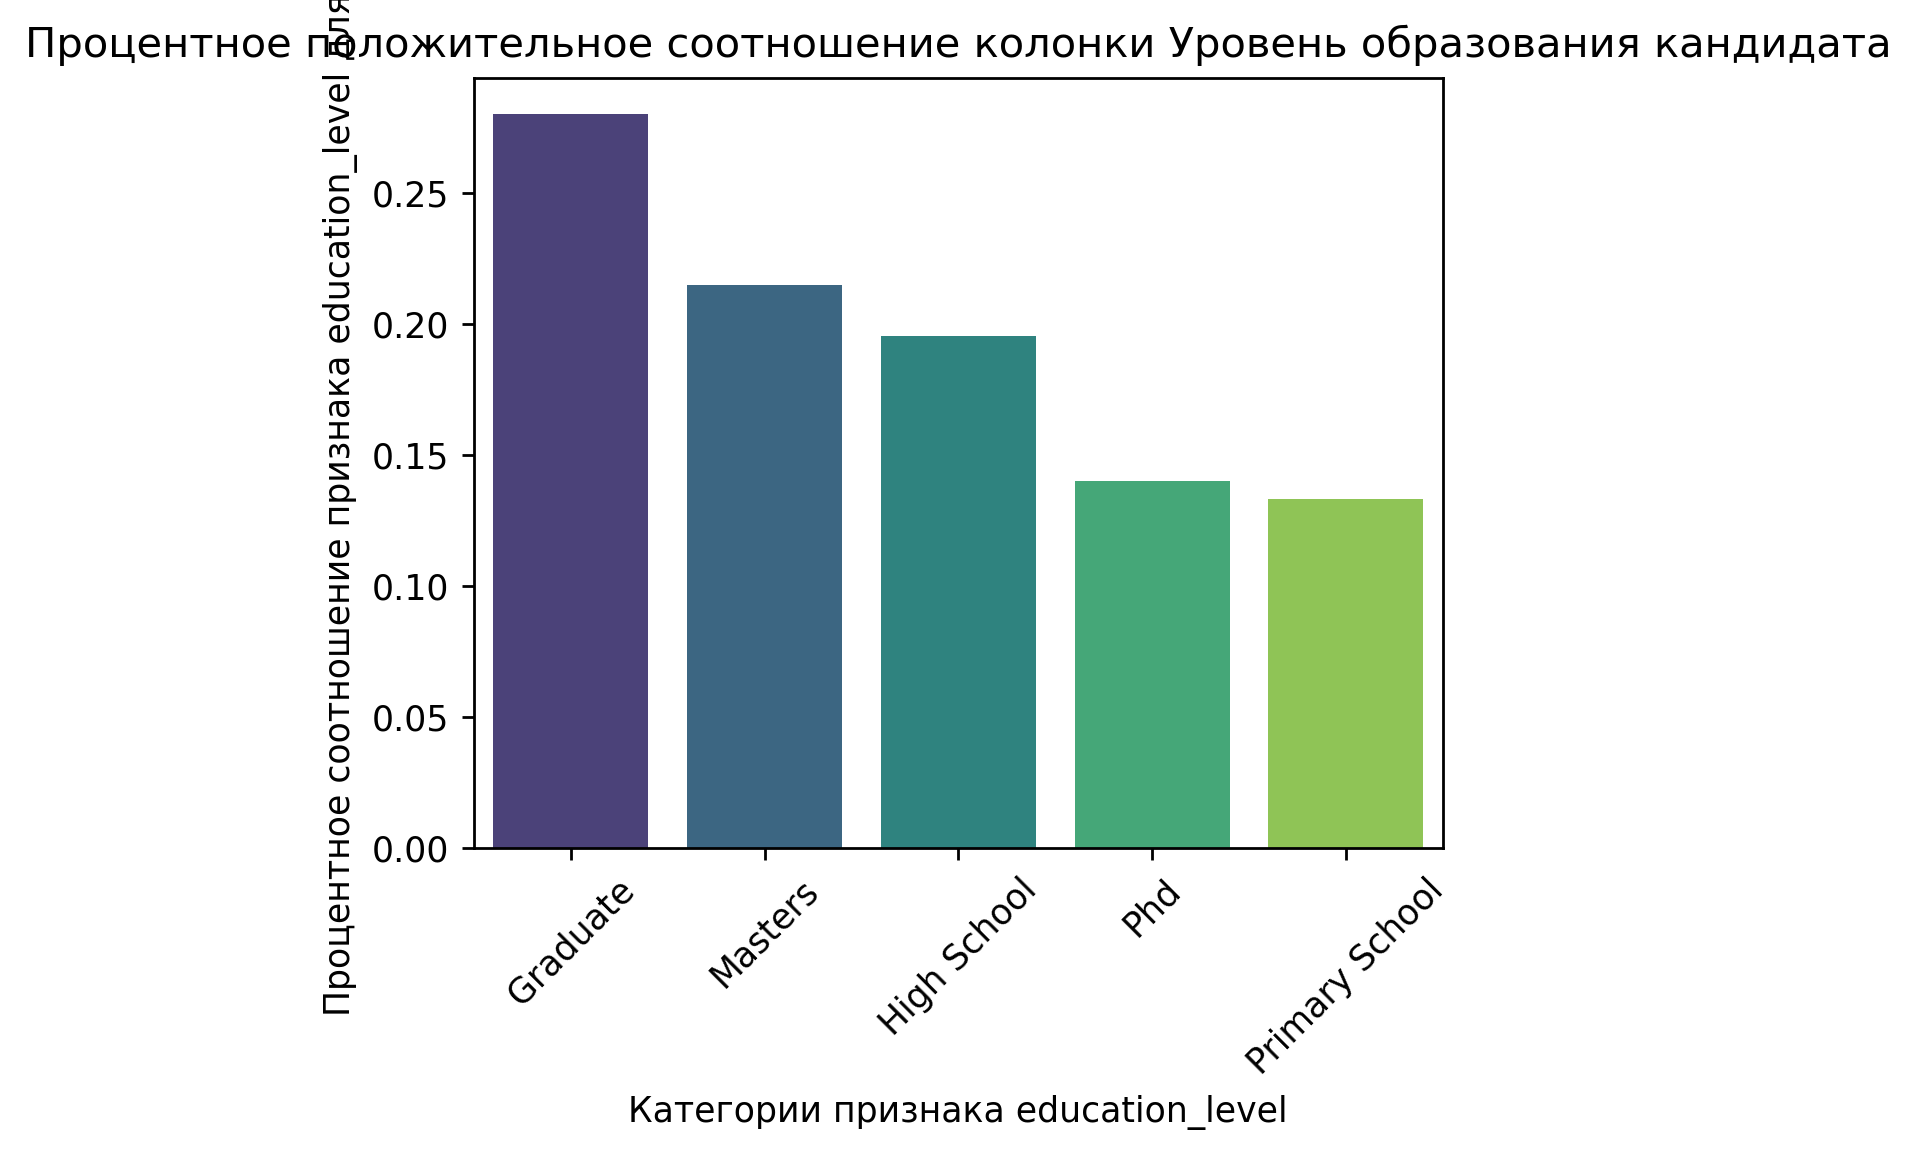

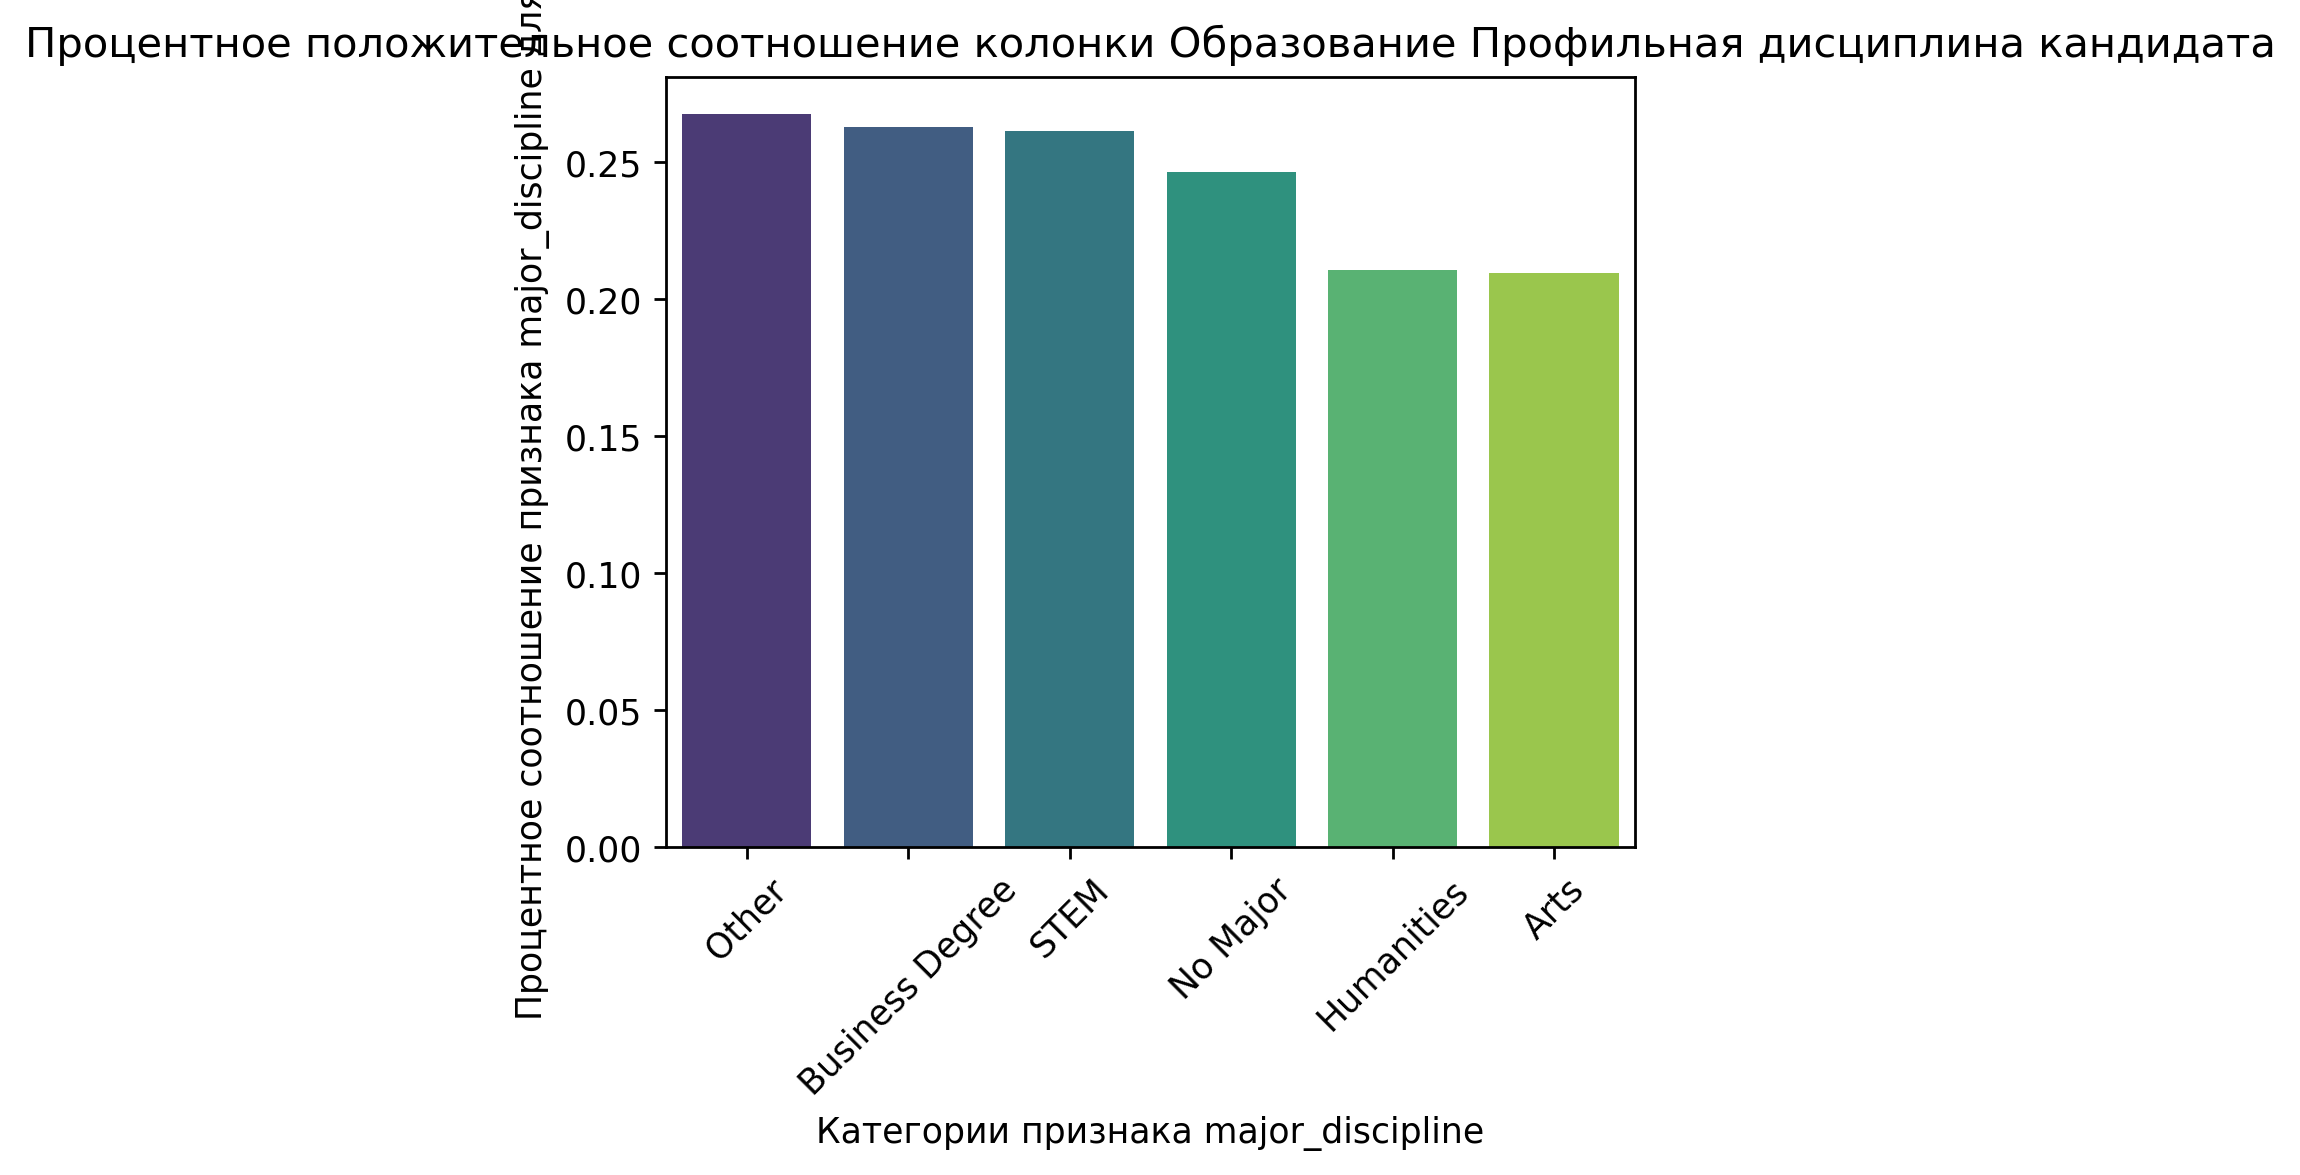

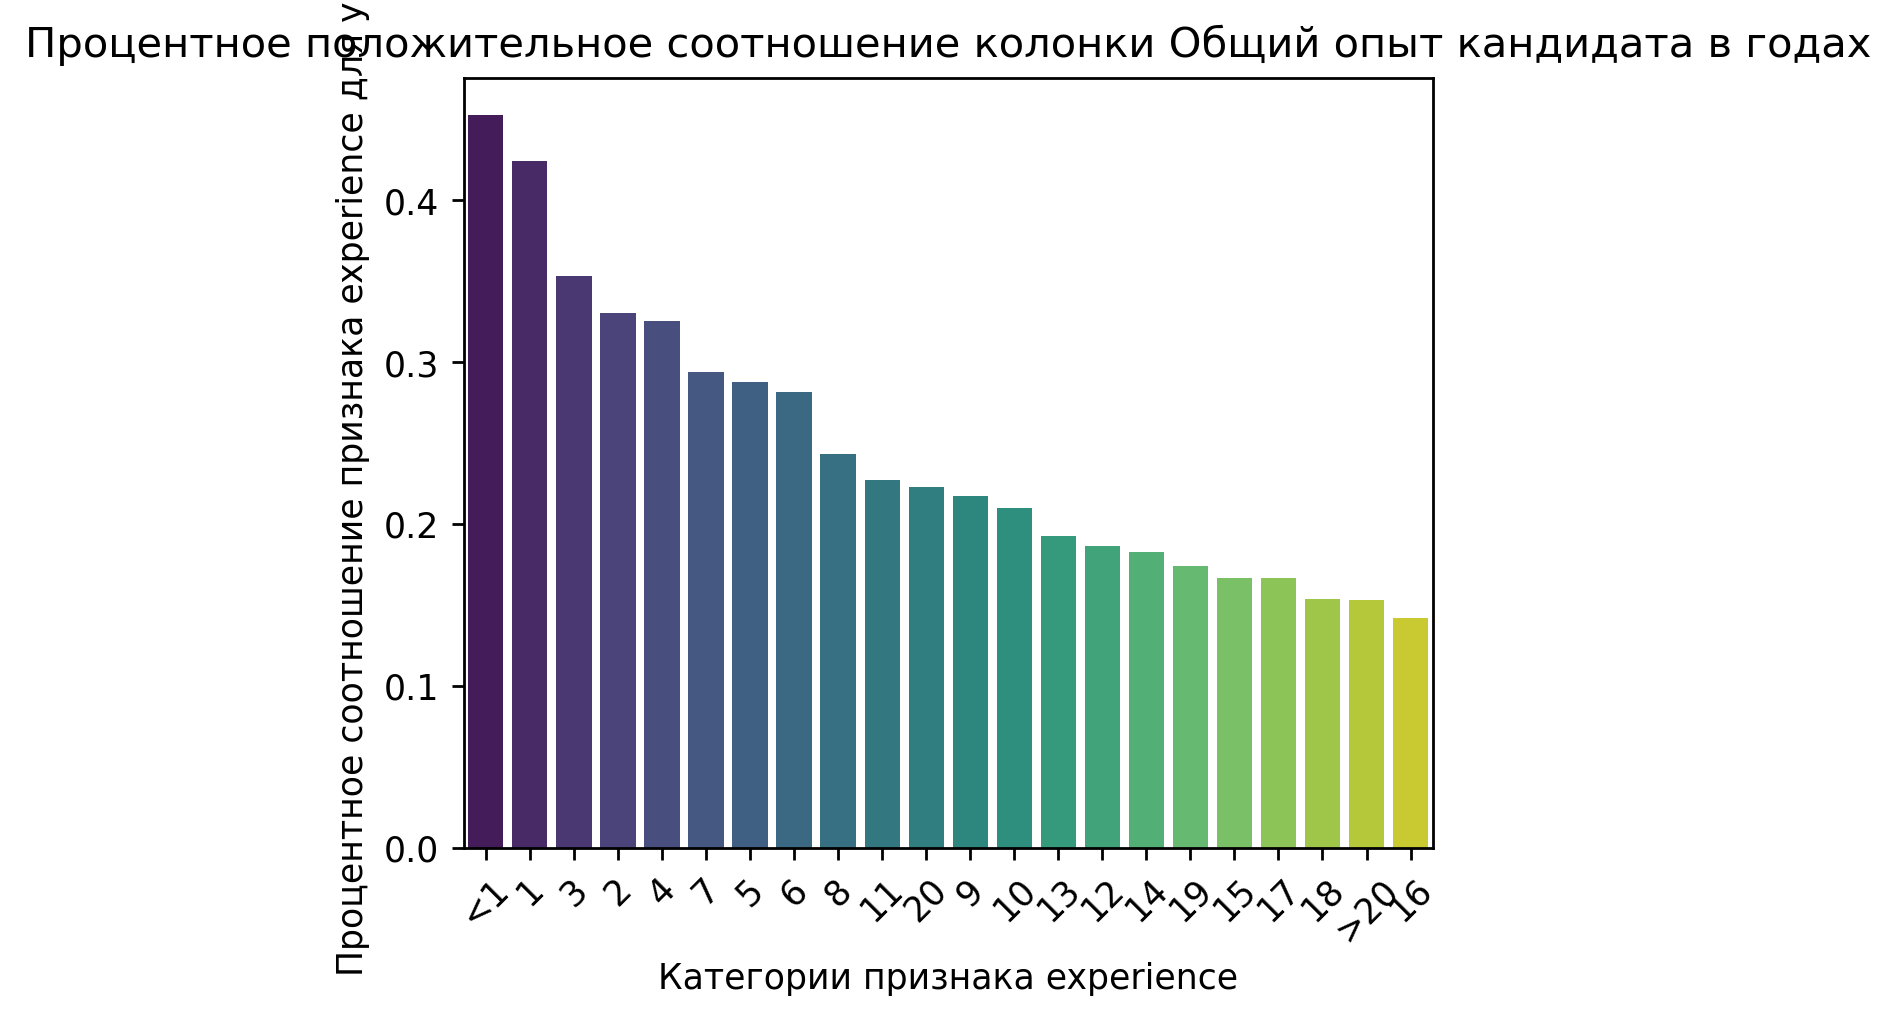

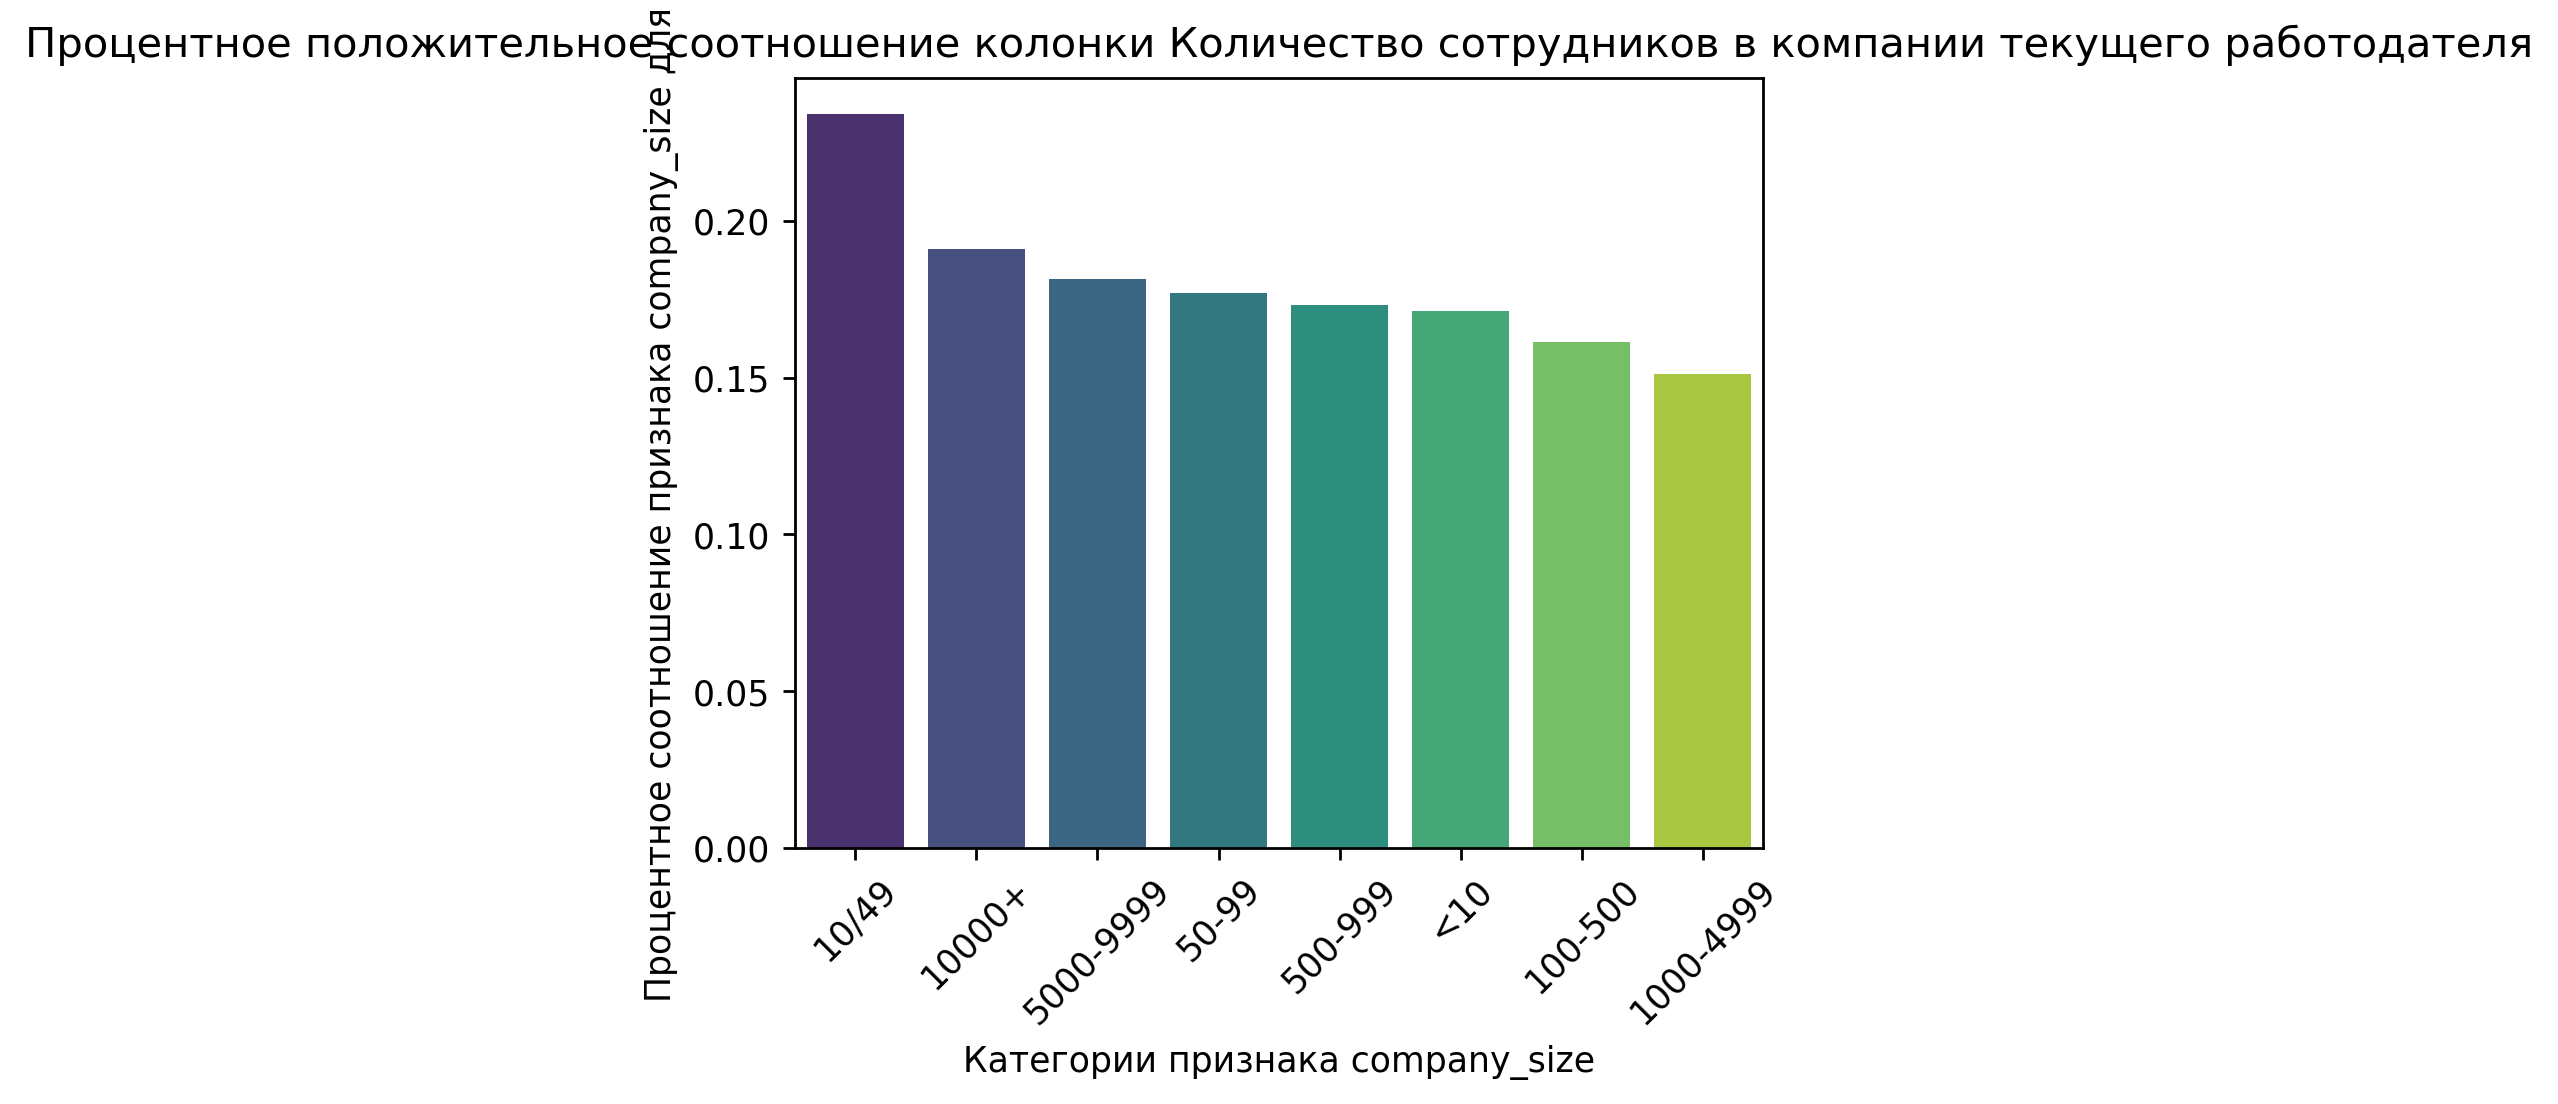

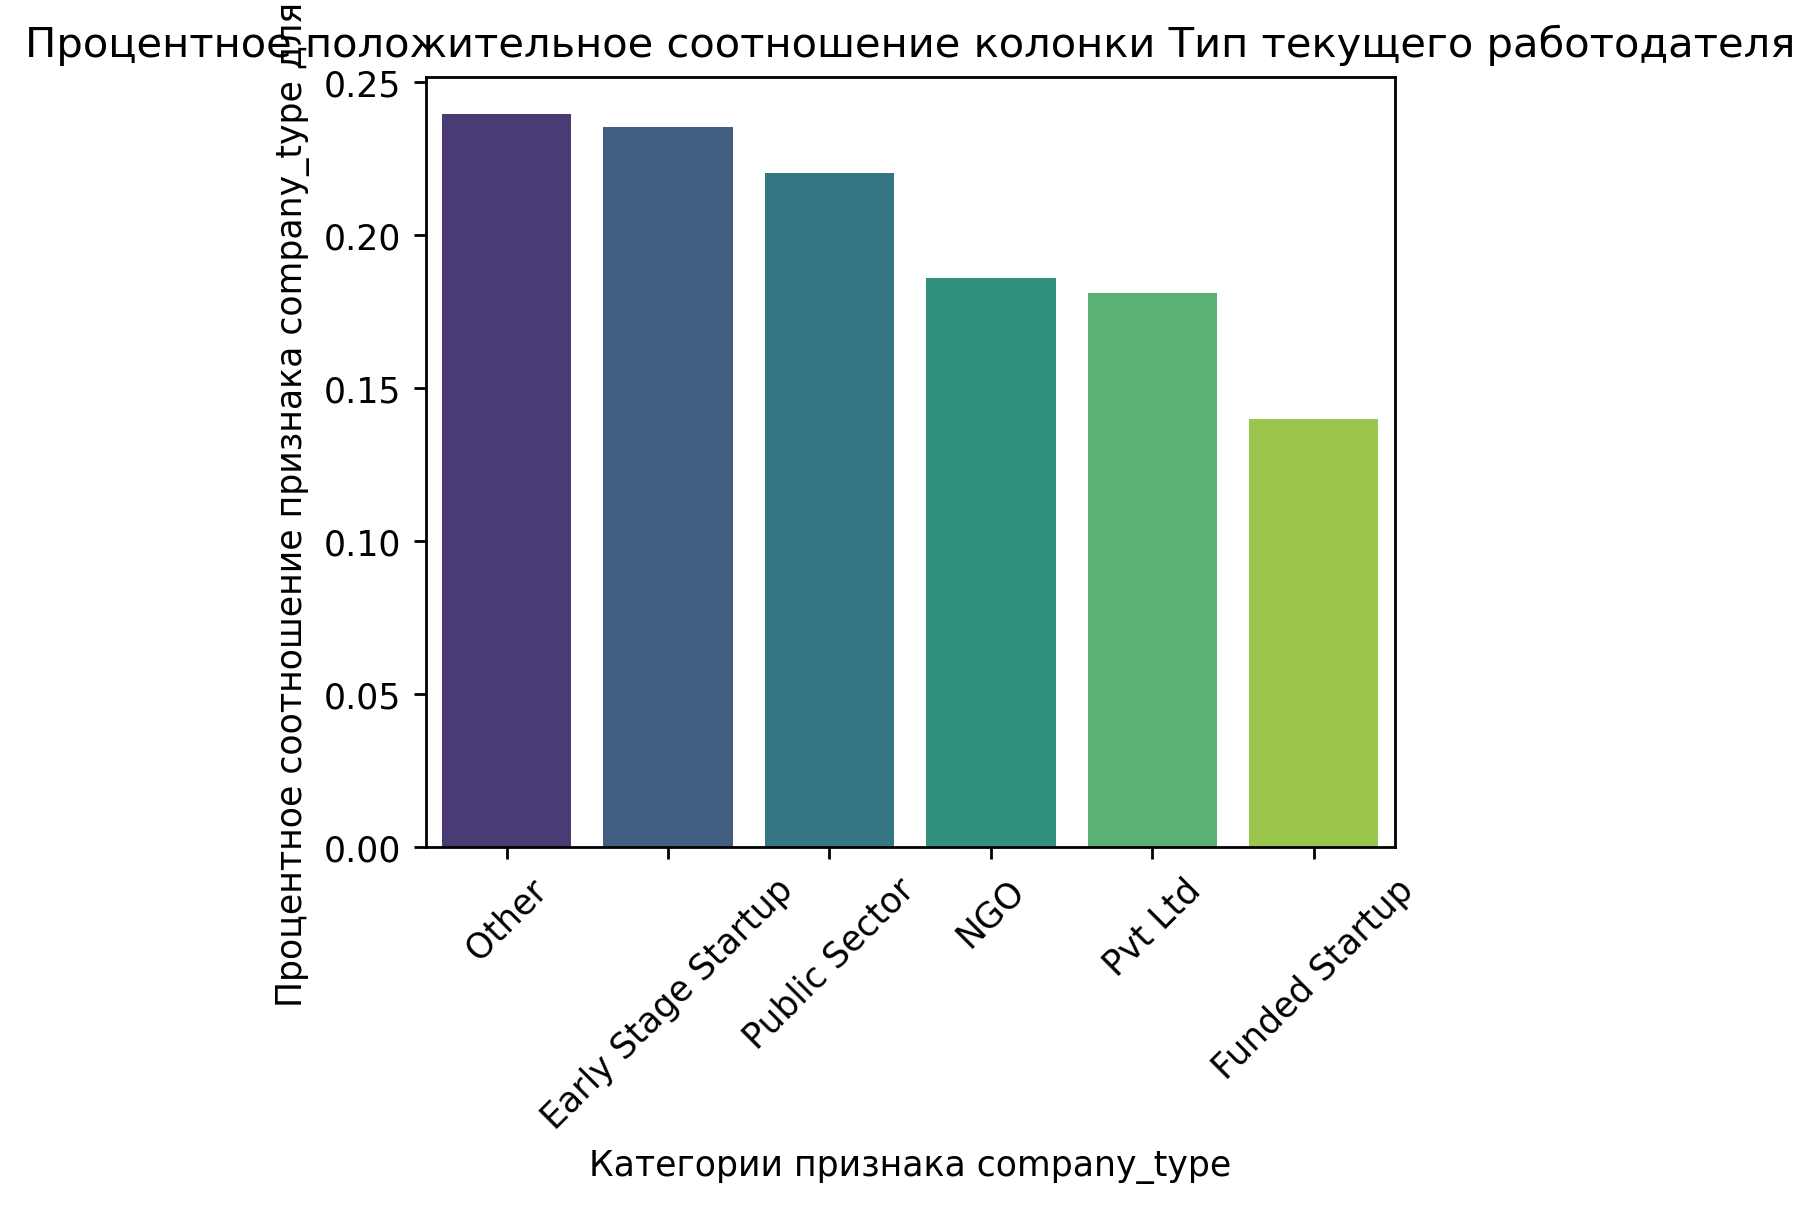

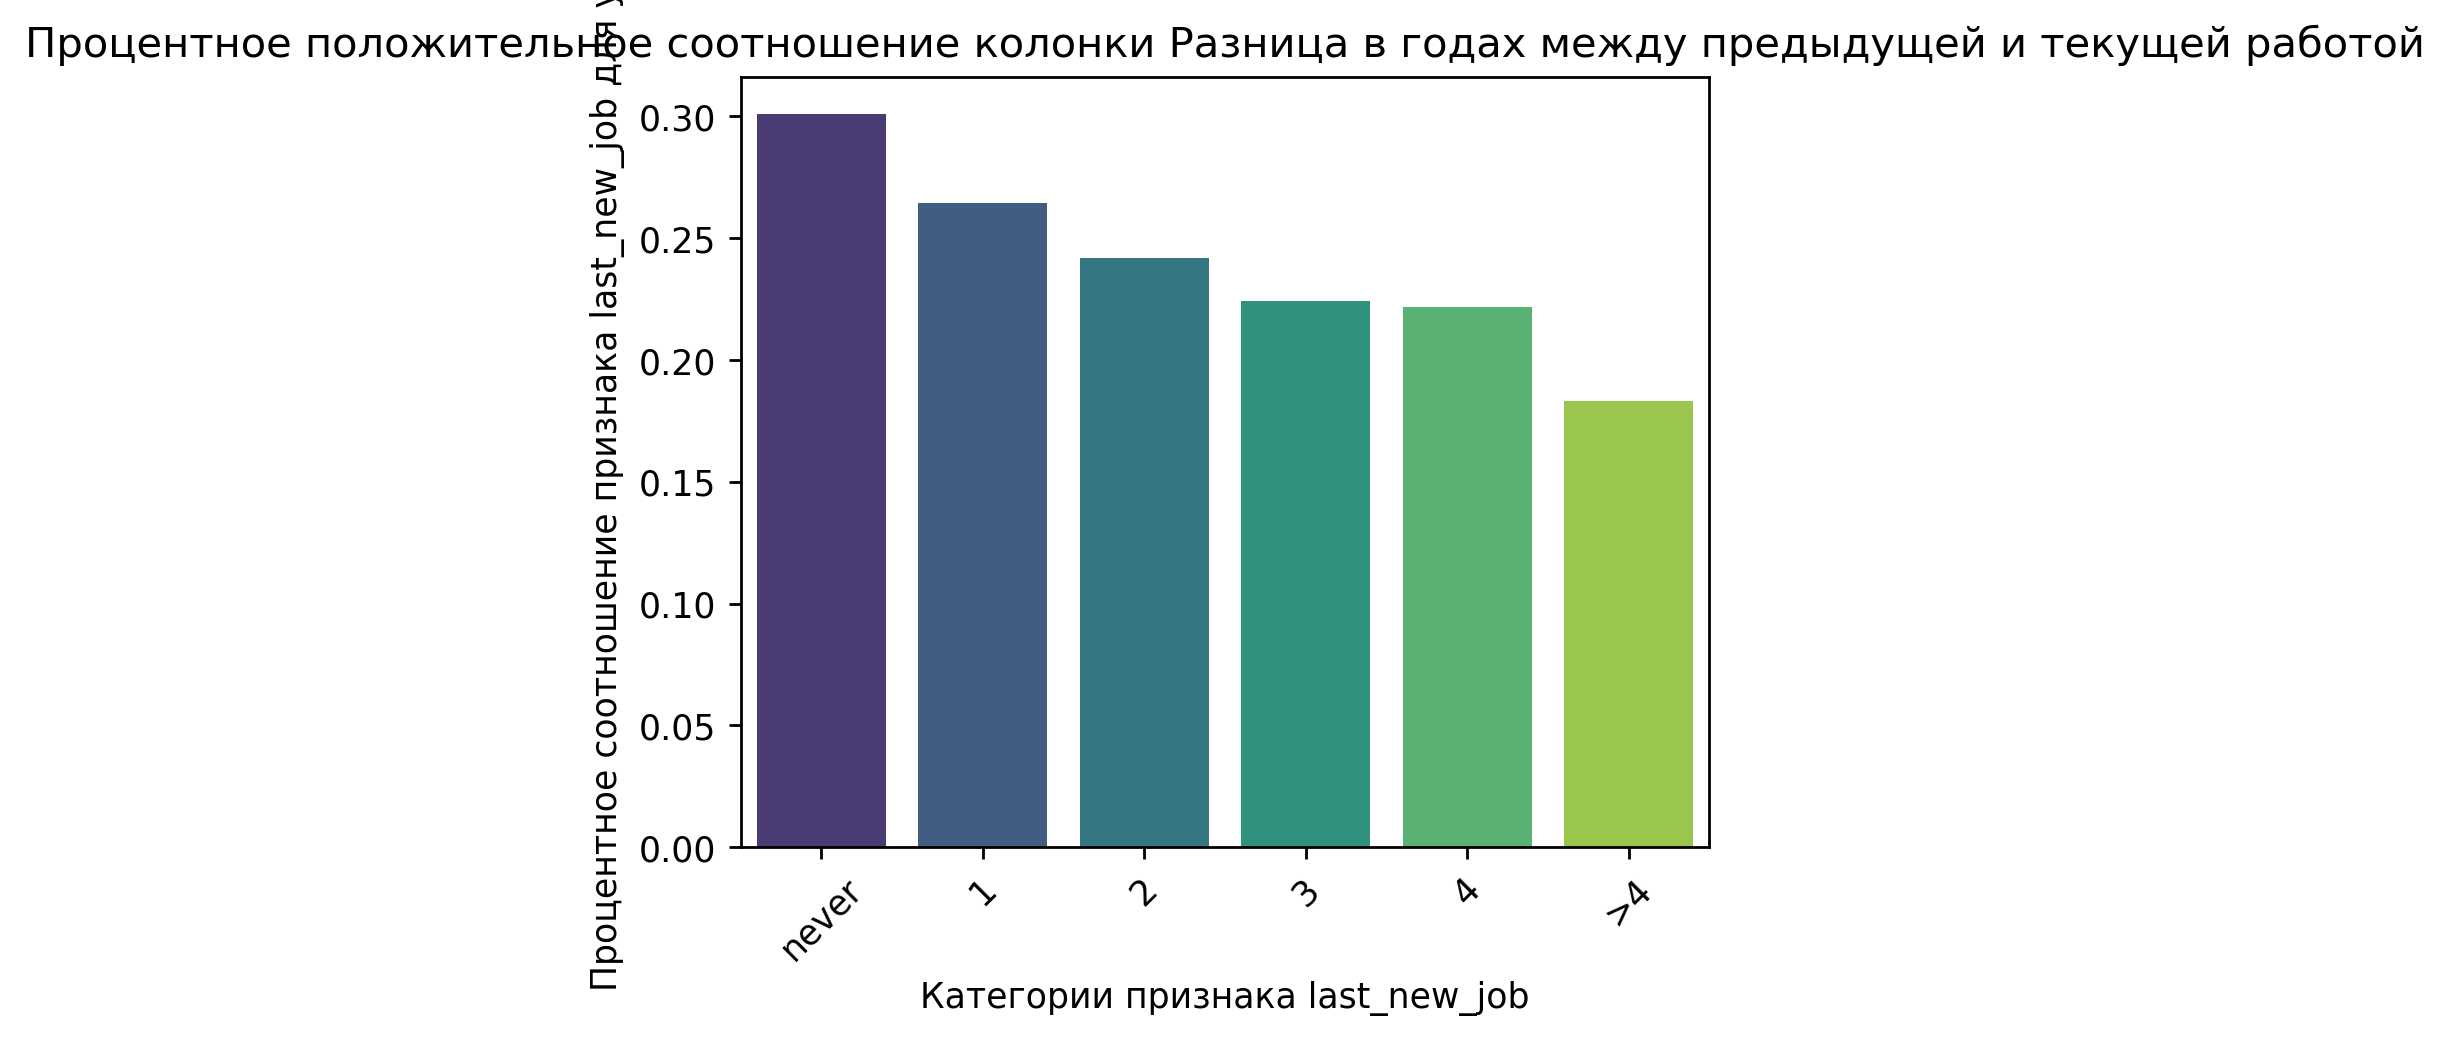

In [117]:
for col in df_cat_columns.drop("target", axis=1).columns:
    plot_conversion_by_category(col, df_cat_columns, feature_descriptions[col])

In [127]:
#Посмотрим пропуски в процентном соотношении
np.round(df_cat_columns.isna().sum() / len(df_cat_columns) * 100, 3)

city                    0.000
gender                 23.619
relevent_experience     0.000
enrolled_university     1.964
education_level         2.411
major_discipline       14.696
experience              0.330
company_size           30.805
company_type           31.812
last_new_job            2.180
target                 10.020
dtype: float64

### Анализ
- В двух колонках пропусков по 30% процетов, можно заполнить KNN, но для этого очень мало вещественных колонок, одна очень плохо коррелирует с таргетных значением, тогда заполним пропуски с помощью KNN, далее проведем эксперимент построение модели с данными признаками и без них, выберем модель, чей результат лучше

In [138]:
#Заполним пропуски с помощью KNN
isnull_columns = df_cat_columns.drop(["target", "city", "relevent_experience"], axis=1).isna().sum().index
for col in isnull_columns:
    fillna_model = KNeighborsClassifier(n_neighbors=7)
    null_index = df_cat_columns[df_cat_columns[col].isnull()].index
    not_null_index = df_cat_columns[df_cat_columns[col].notna()].index
    X_train = df_num_columns.loc[not_null_index][["city_development_index", "training_hours"]]
    y_train = df_cat_columns.loc[not_null_index][col]

    X_missing = df_num_columns.loc[null_index][["city_development_index", "training_hours"]]

    fillna_model.fit(X_train, y_train)
    print(f"Количество пропусков в колонке: {col}={X_missing.shape[0]}")
    df_cat_columns.loc[null_index, col] = fillna_model.predict(X_missing)
print("Все пропуски заполнены!")

Количество пропусков в колонке: gender=5016
Количество пропусков в колонке: enrolled_university=417
Количество пропусков в колонке: education_level=512
Количество пропусков в колонке: major_discipline=3121
Количество пропусков в колонке: experience=70
Количество пропусков в колонке: company_size=6542
Количество пропусков в колонке: company_type=6756
Количество пропусков в колонке: last_new_job=463
Все пропуски заполнены!


In [140]:
print(f"Количество пропусков: {df_cat_columns.drop("target", axis=1).isna().sum().sum()}")

Количество пропусков: 0


In [151]:
coding_columns =  list(df_cat_columns.drop("target", axis=1).columns)

### Кодировка колонок

In [168]:
#Объединим колонки в единый dataframe
full_df = pd.concat([df_num_columns, df_cat_columns.drop("target", axis=1)], axis=1)

In [1]:
full_df.head()

NameError: name 'full_df' is not defined

In [170]:
#Удалим индексы
full_df.reset_index(drop=True, inplace=True)

In [171]:
#Закодируем колонки
cv = KFold(n_splits=30, shuffle=True, random_state=42)

for col in coding_columns:
    if full_df[col].nunique() <= 5:
        ohe = pd.get_dummies(data=full_df[col], prefix=col, drop_first=True, dtype="int")
        full_df = pd.concat([full_df, ohe], axis=1)
        full_df.drop(col, axis=1, inplace=True)
    else:
        mte_column = f"{col}_mte"
        full_df[mte_column] = 0.0
        for train_index, val_index in cv.split(full_df):
            map_values = full_df.iloc[train_index].groupby(col)["target"].mean().to_dict()
            mte_values = full_df.loc[val_index, col].map(map_values)

            noise = np.random.uniform(0.99, 1.01, size=len(mte_values))

            full_df.loc[val_index, mte_column] = mte_values * noise

        mean = full_df["target"].mean()
        full_df[mte_column].fillna(mean, inplace=True)

        full_df.drop(col, axis=1, inplace=True)

print("Все признаки были закодированы!")

Все признаки были закодированы!


In [243]:
col_1 = full_df["city_mte"] - full_df["city_mte"].mean()
col_2 = full_df["city_development_index"] - full_df["city_development_index"].mean()
cov = np.mean(col_1 * col_2)

In [247]:
cov / (np.sqrt(full_df.city_mte.var()) * np.sqrt(full_df.city_development_index.var()))

np.float64(-0.8618953129826876)

### Посмотрим распределение колонок, где больше 2-х уник. значений

In [172]:
histplotcolumns = list(full_df.nunique()[full_df.nunique() > 2].index)

In [183]:
def drow_histplot(df, col):
    fig = plt.figure(figsize=(2, 1.5), dpi=250)
    plt.title(col)
    sns.histplot(data=df, x=col)
    plt.show()

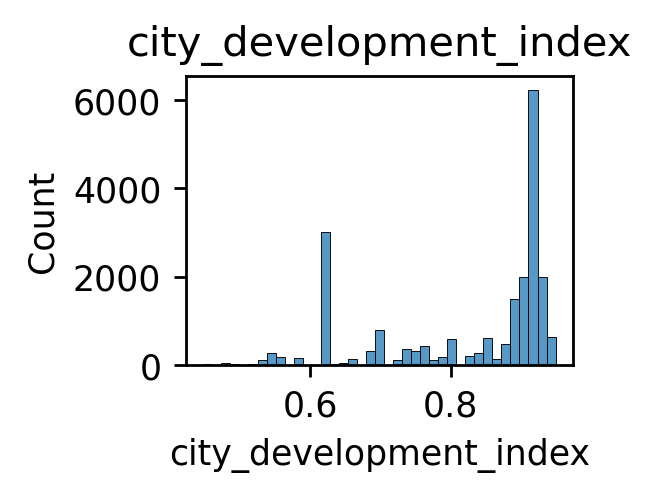

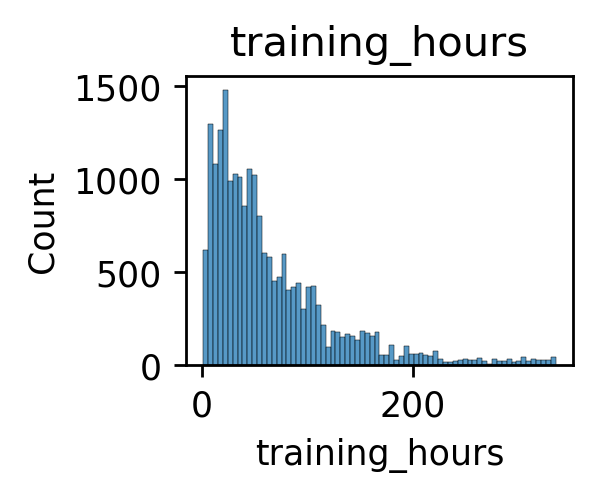

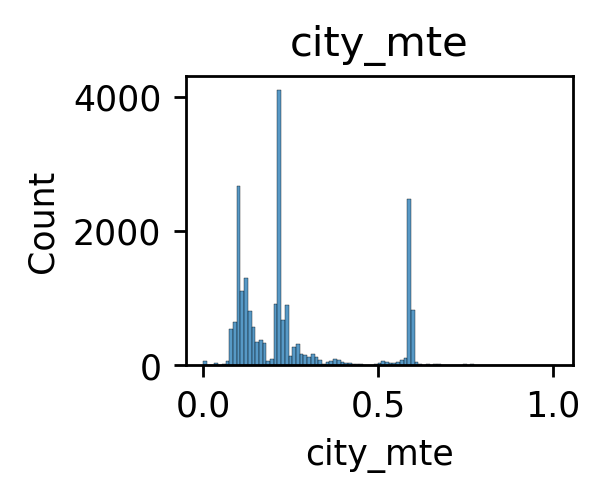

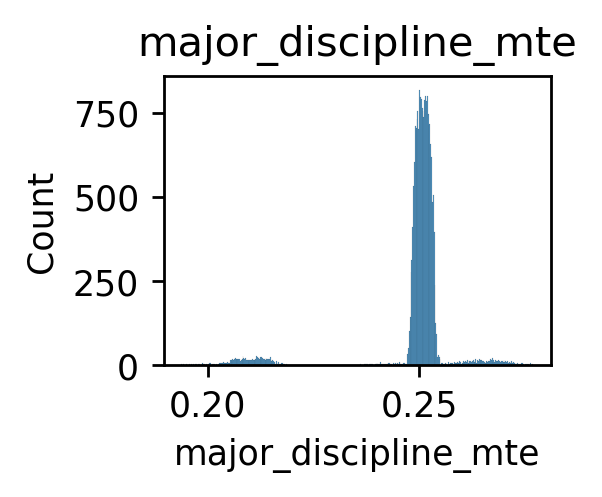

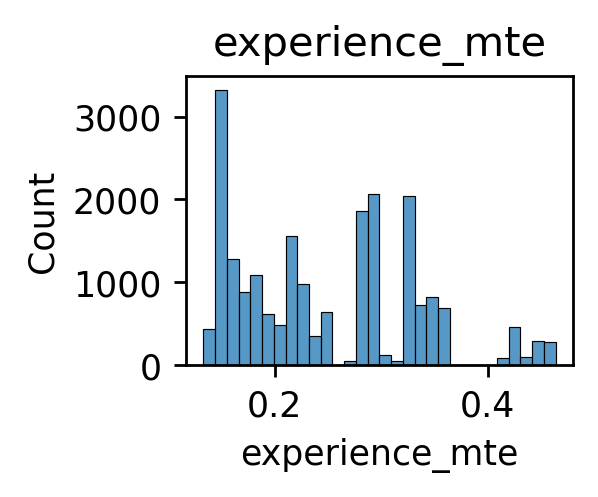

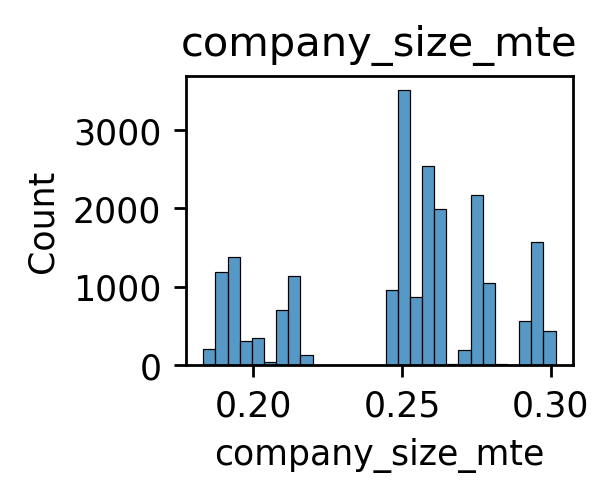

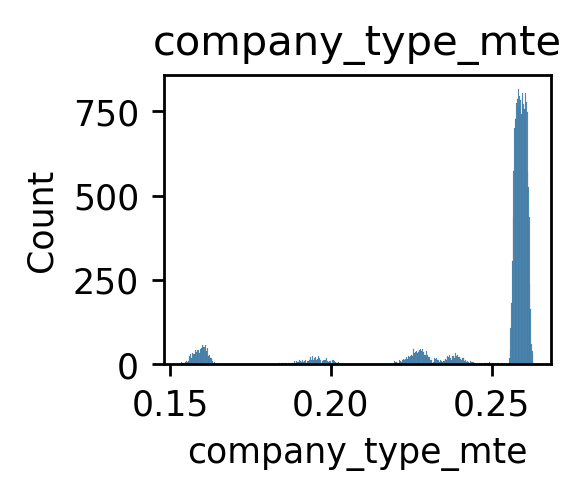

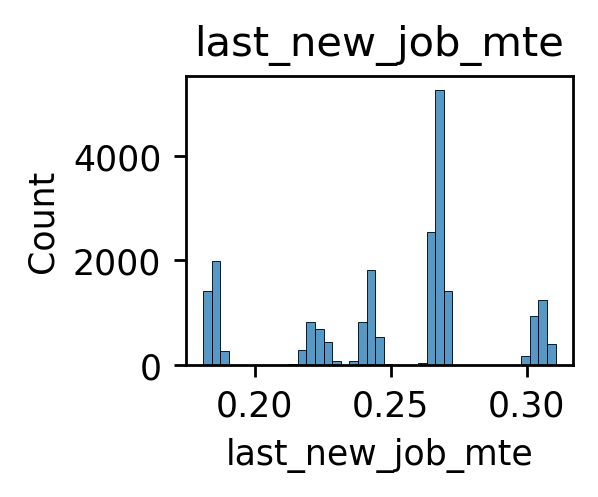

In [184]:
for col in histplotcolumns:
    drow_histplot(full_df, col)

In [ ]:
fig = plt.figure(figsize=(15, 15), dpi=400)
sns.heatmap(full_df.corr(), annot=True, linewidths=1)
plt.show()

In [185]:
train_index, test_index = full_df[full_df["target"].notna()].index, full_df[full_df["target"].isnull()].index

In [237]:
X_train, y_train = full_df.iloc[train_index].drop("target", axis=1), full_df.iloc[train_index]["target"]
X_test, y_test = full_df.iloc[test_index].drop("target", axis=1), full_df.iloc[test_index]["target"]

### Построим базовую модель, замерив качество на кросс-валиации

In [235]:
accuracy_average_score, pr_average_score, roc_average_score = 0, 0, 0
cv = KFold(n_splits=10, shuffle=True, random_state=42)
iteration = 0
accuracy_average, pr_average, roc_average = [], [], [] 
for val_index, test_index in cv.split(X_train):
    X_val, X_test = X_train.iloc[val_index], X_train.iloc[test_index]
    y_val, y_test = y_train.iloc[val_index], y_train.iloc[test_index]

    scaler = StandardScaler()
    X_val_scaled = scaler.fit_transform(X_val)
    X_test_scaled = scaler.fit_transform(X_test)

    model = LogisticRegression()
    model.fit(X_val_scaled, y_val)

    accuracy_average.append(accuracy_score(y_test, model.predict(X_test_scaled)))
    pr_average.append(average_precision_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
    roc_average.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))

accuracy_average_score = round(float(np.mean(accuracy_average)), 3)
pr_average_score = round(float(np.mean(pr_average)), 3)
roc_average_score = round(float(np.mean(roc_average)), 3)

In [236]:
print(f"accuracy_average_score: {accuracy_average_score}")
print(f"pr_average_score: {pr_average_score}")
print(f"roc_average_score: {roc_average_score}")

accuracy_average_score: 0.776
pr_average_score: 0.503
roc_average_score: 0.761


In [189]:
X_train_not_binary_col = X_train[histplotcolumns]

### Проведем эксперимент
- Генерация признаков с помощью PolynomialFeature

Не будем использовать признаки, где всего 2 уникальных значения, то есть бинарных

In [211]:
#Генерация признаков с помощью PolynomialFeature
best_params = []
cv = KFold(n_splits=10, shuffle=True, random_state=42)
for degree in range(1, 4):

    pipe = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                    ("scaler", StandardScaler()),
                    ("model", LogisticRegression(penalty="elasticnet", max_iter=500, class_weight="balanced", solver="saga"))])

    param_grid = {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__l1_ratio": [0.25, 0.5, 0.75]
    }

    grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, verbose=1, cv=4, scoring="average_precision")
    
    grid.fit(X_train_not_binary_col, y_train)

    best_param = {
        "penalty": "elasticnet",
        "max_iter": 1000,
        "class_weight": "balanced",
        "solver": "saga",
        "C": grid.best_params_["model__C"],
        "l1_ratio": grid.best_params_["model__l1_ratio"]
    }
    best_params.append(best_param)
    print(degree)

Fitting 4 folds for each of 15 candidates, totalling 60 fits
1
Fitting 4 folds for each of 15 candidates, totalling 60 fits
2
Fitting 4 folds for each of 15 candidates, totalling 60 fits
3
Fitting 4 folds for each of 15 candidates, totalling 60 fits


KeyboardInterrupt: 

In [219]:
accuracy_average_score, pr_average_score, roc_average_score = [], [], [] 
degrees = [1, 2, 3]
cv = KFold(n_splits=10, shuffle=True, random_state=42)
for best_param, degree in zip(best_params, degrees):
    accuracy_average, pr_average, roc_average = [], [], [] 
    for val_index, test_index in cv.split(X_train_not_binary_col):
        X_val, X_test = X_train_not_binary_col.iloc[val_index], X_train_not_binary_col.iloc[test_index]
        y_val, y_test = y_train.iloc[val_index], y_train.iloc[test_index]

        transform = PolynomialFeatures(degree=degree, include_bias=False)
        X_val_poly = transform.fit_transform(X_val)
        X_test_poly = transform.transform(X_test)

        scaler = StandardScaler()
        X_val_scaled = scaler.fit_transform(X_val_poly)
        X_test_scaled = scaler.fit_transform(X_test_poly)

        model = LogisticRegression(**best_param)
        model.fit(X_val_scaled, y_val)

        accuracy_average.append(accuracy_score(y_test, model.predict(X_test_scaled)))
        pr_average.append(average_precision_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
        roc_average.append(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))

    print(f"Итерация: {degree} завершена!")
        
    accuracy_average_score.append(round(float(np.mean(accuracy_average)), 3))
    pr_average_score.append(round(float(np.mean(pr_average)), 3))
    roc_average_score.append(round(float(np.mean(roc_average)), 3))

Итерация: 1 завершена!
Итерация: 2 завершена!
Итерация: 3 завершена!


In [220]:
print(f"accuracy_average_score: {accuracy_average_score}")
print(f"pr_average_score: {pr_average_score}")
print(f"roc_average_score: {roc_average_score}")

accuracy_average_score: [0.746, 0.721, 0.737]
pr_average_score: [0.485, 0.483, 0.487]
roc_average_score: [0.738, 0.74, 0.738]


### Видно, что различного прироста особо не добавляется, тогда просто используем решающие деревья

In [240]:
pipe = Pipeline([("poly", PolynomialFeatures(degree=degree, include_bias=False)),
                    ("scaler", StandardScaler()),
                    ("model", DecisionTreeClassifier())])

param_grid = {
    "model__max_depth": [6, 7, 8, 9, 10],
    "model__min_samples_split": [1, 2, 3, 4],
    "model__min_samples_leaf": [1, 2, 3, 4],
    "model__min_weight_fraction_leaf": [0.015, 0.025, 0.04]
}
grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, verbose=1, cv=4, scoring="average_precision")
    
grid.fit(X_train, y_train)

Fitting 4 folds for each of 240 candidates, totalling 960 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('poly',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('scaler', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 2, 3, 4],
                         'model__min_samples_split': [1, 2, 3, 4],
                         'model__min_weight_fraction_leaf': [0.015, 0.025,
                                                             0.04]},
             scoring='average_precision', verbose=1)

In [241]:
print("Лучшие параметры:", grid.best_params_)
print("Лучший average_precision:", grid.best_score_)

Лучшие параметры: {'model__max_depth': 8, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__min_weight_fraction_leaf': 0.015}
Лучший average_precision: 0.480898495396924
